In [3]:
import warnings
warnings.filterwarnings('ignore')

### Dataset Sources

#### Beat Acute Myeloid Leukemia (AML) 1.0 was accessed on 13Mar2023 from https://registry.opendata.aws/beataml. OHSU BeatAML Datasets Link: https://ctd2-data.nci.nih.gov/Public/OHSU-1/BeatAML_Waves1_2/

#### OpenCell Datasets Link: https://opencell.czbiohub.org/download


### Check Pre-requisites from the 01-setup Folder

In [4]:
%store -r setup_instance_check_passed

In [5]:
try:
    setup_instance_check_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++")

In [6]:
print(setup_instance_check_passed)

True


In [7]:
%store -r setup_dependencies_passed

In [8]:
try:
    setup_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")

In [9]:
print(setup_dependencies_passed)

True


In [10]:
%store -r setup_s3_bucket_passed

In [11]:
try:
    setup_s3_bucket_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++")

In [12]:
print(setup_s3_bucket_passed)

True


In [13]:
%store -r setup_iam_roles_passed

In [14]:
try:
    setup_iam_roles_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++")

In [15]:
print(setup_iam_roles_passed)

False


In [16]:
if not setup_instance_check_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_dependencies_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_s3_bucket_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_iam_roles_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [17]:
import boto3
import sagemaker
import pandas as pd
import time
from time import gmtime, strftime

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)


## S3 Original Dataset Location

### Importing Raw Datasets from AWS S3. Use the AWS Command Line Interface (CLI) to list the S3 bucket content using the following CLI Commands:

In [18]:
!aws s3 ls s3://ads508rawdatasets/CSV/OHSU_BeatAML_ClinicalSummary/

2023-03-27 03:13:36          0 
2023-03-27 03:13:59     712668 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv


In [19]:
!aws s3 ls s3://ads508rawdatasets/CSV/OpenCell_ProteinInteraction/

2023-03-27 03:15:14          0 
2023-03-27 03:17:18    4568928 opencell-protein-interactions.csv


### Set S3 Source Location
#### BeatAML Clinical Summary

In [20]:
s3_public_path_clsm = "s3://ads508rawdatasets/CSV/OHSU_BeatAML_ClinicalSummary/"

In [21]:
%store s3_public_path_clsm

Stored 's3_public_path_clsm' (str)


In [22]:
print(s3_public_path_clsm)

s3://ads508rawdatasets/CSV/OHSU_BeatAML_ClinicalSummary/


In [23]:
!aws s3 ls $s3_public_path_clsm

2023-03-27 03:13:36          0 
2023-03-27 03:13:59     712668 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv


In [24]:
#BeatAML OpenCell Protein Interaction 
s3_public_path_pi = "s3://ads508rawdatasets/CSV/OpenCell_ProteinInteraction/"

In [25]:
%store s3_public_path_pi

Stored 's3_public_path_pi' (str)


In [26]:
print(s3_public_path_pi)

s3://ads508rawdatasets/CSV/OpenCell_ProteinInteraction/


In [27]:
!aws s3 ls $s3_public_path_pi

2023-03-27 03:15:14          0 
2023-03-27 03:17:18    4568928 opencell-protein-interactions.csv


In [28]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/team4rawdatasets?prefix=CSV/Input/&region=us-east-1">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

### Athena Database
#### PyAthena is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena

In [29]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [30]:
ingest_create_athena_db_passed = False

In [31]:
database_name = "bcr"

In [32]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [33]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [34]:
statement0 = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement0)

CREATE DATABASE IF NOT EXISTS bcr


In [ ]:
pd.read_sql(statement0, conn)

### Verify the Database has been created successfully

In [35]:
statement00 = "SHOW DATABASES"

df_show = pd.read_sql(statement00, conn)
df_show.head(5)

database_name
0     aws508bcr
1       default

In [36]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [37]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


### Athena Table Created Through AWS Glue Crawler

In [38]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="top" href="https://us-east-1.console.aws.amazon.com/glue/home?region=us-east-1#/v2/data-catalog/tables">AWS Glue Catalog</a></b>'.format(
            region
        )
    )
)

In [39]:
# Set Athena database & table
table_clsm = "ohsu_beataml_clinicalsummary"
table_pi = "opencell_proteininteraction"

In [40]:
#Athena SQL Code
statement1 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_pi
)

print(statement1)


SELECT *
FROM bcr.opencell_proteininteraction 



In [ ]:
pi = pd.read_sql(statement1, conn)

### Data Cleaning
### Import Tools:

In [41]:
!pip install klib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 3.1 MB/s eta 0:00:0000:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In [42]:
import numpy as np
import seaborn as sns
import klib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

## BeatAML Clinical Summary

### OHSU BeatAML Clinical Summary Table

In [43]:
statement2 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_clsm
)

print(statement2)


SELECT *
FROM bcr.ohsu_beataml_clinicalsummary 



In [ ]:
clsm = pd.read_sql(statement2, conn)

In [44]:
import numpy as np
import seaborn as sns
import klib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [45]:
!aws s3 cp 's3://ads508rawdatasets/OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv' ./data/

download: s3://ads508rawdatasets/OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv to data/OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv


In [46]:
!aws s3 cp 's3://ads508rawdatasets/opencell-protein-interactions.csv' ./data/

download: s3://ads508rawdatasets/opencell-protein-interactions.csv to data/opencell-protein-interactions.csv


In [47]:
import csv

clsm = pd.read_csv('s3://ads508rawdatasets/OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv')
clsm.head(5)

LabId  PatientId consensus_sex inferred_sex inferred_ethnicity  \
0  09-00705        163          Male         Male              White   
1  10-00136        174          Male         Male              White   
2  10-00172        175        Female         Male              White   
3  10-00507         45        Female       Female              White   
4  10-00542        174          Male         Male              White   

   centerID CEBPA_Biallelic  ageAtDiagnosis  isRelapse  isDenovo  ...  STAG2  \
0         1               n            73.0      False      True  ...    NaN   
1         1               n            69.0      False      True  ...    NaN   
2         1               n            59.0      False      True  ...    NaN   
3         1               n            70.0      False      True  ...    NaN   
4         1               n            69.0       True     False  ...    NaN   

  STAT3  SUZ12  TCL1A TET2 TP53 TYK2 U2AF1  WT1 ZRSR2  
0   NaN    NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  
1   NaN    NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  
2   NaN    NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  
3   NaN    NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  
4   NaN    NaN    NaN  NaN  NaN  NaN   NaN  NaN   NaN  

[5 rows x 159 columns]

In [48]:
pi = pd.read_csv('s3://ads508rawdatasets/opencell-protein-interactions.csv')
pi.head(5)

target_gene_name interactor_gene_name   target_ensg_id interactor_ensg_id  \
0             AAMP               ARGLU1  ENSG00000127837    ENSG00000134884   
1             AAMP              CWF19L2  ENSG00000127837    ENSG00000152404   
2             AAMP              PRPF40A  ENSG00000127837    ENSG00000196504   
3             AAMP                RPL10  ENSG00000127837    ENSG00000147403   
4             AAMP                RSRC1  ENSG00000127837    ENSG00000174891   

                              interactor_uniprot_ids       pval  enrichment  \
0                           Q9NWB6;Q9NWB6-3;Q9NWB6-2   5.495914    2.868131   
1             Q2TBE0;Q2TBE0-2;H7C3G7;Q2TBE0-3;H0YE03   5.480125    2.889502   
2  A0A3F2YNY6;O75400-2;O75400-3;O75400;H0YG38;F5H578   5.321102    3.228531   
3                 X1WI28;P27635;B8A6G2;A6QRI9;Q96L21  15.156173    4.847218   
4  Q96IZ7-2;Q96IZ7;H7C5Q0;C9J713;C9J367;C9J8Q2;C9...   5.929453    3.239392   

   interaction_stoichiometry  abundance_stoichiometry  
0                   0.128618                 0.222927  
1                   0.022009                 0.063036  
2                   0.001582                 0.742017  
3                   0.521148                13.146910  
4                   0.013171                 0.210926

In [49]:
clsm

LabId  PatientId consensus_sex inferred_sex inferred_ethnicity  \
0    09-00705        163          Male         Male              White   
1    10-00136        174          Male         Male              White   
2    10-00172        175        Female         Male              White   
3    10-00507         45        Female       Female              White   
4    10-00542        174          Male         Male              White   
..        ...        ...           ...          ...                ...   
667  17-00072       4366          Male         Male              White   
668  17-00077       4317        Female       Female              White   
669  17-00093       4379        Female       Female              Black   
670  17-00094       4380          Male         Male              White   
671  17-00096       2747          Male         Male              White   

     centerID CEBPA_Biallelic  ageAtDiagnosis  isRelapse  isDenovo  ...  \
0           1               n            73.0      False      True  ...   
1           1               n            69.0      False      True  ...   
2           1               n            59.0      False      True  ...   
3           1               n            70.0      False      True  ...   
4           1               n            69.0       True     False  ...   
..        ...             ...             ...        ...       ...  ...   
667         1               n            70.0      False     False  ...   
668         1               n            72.0      False     False  ...   
669         2               n            43.0      False     False  ...   
670         6               n            57.0      False     False  ...   
671         6               n            62.0      False     False  ...   

     STAG2 STAT3  SUZ12  TCL1A TET2      TP53 TYK2 U2AF1       WT1 ZRSR2  
0      NaN   NaN    NaN    NaN  NaN       NaN  NaN   NaN       NaN   NaN  
1      NaN   NaN    NaN    NaN  NaN       NaN  NaN   NaN       NaN   NaN  
2      NaN   NaN    NaN    NaN  NaN       NaN  NaN   NaN       NaN   NaN  
3      NaN   NaN    NaN    NaN  NaN       NaN  NaN   NaN       NaN   NaN  
4      NaN   NaN    NaN    NaN  NaN       NaN  NaN   NaN       NaN   NaN  
..     ...   ...    ...    ...  ...       ...  ...   ...       ...   ...  
667    NaN   NaN    NaN    NaN  NaN  negative  NaN   NaN  negative   NaN  
668    NaN   NaN    NaN    NaN  NaN  negative  NaN   NaN  negative   NaN  
669    NaN   NaN    NaN    NaN  NaN       NaN  NaN   NaN       NaN   NaN  
670    NaN   NaN    NaN    NaN  NaN       NaN  NaN   NaN       NaN   NaN  
671    NaN   NaN    NaN    NaN  NaN       NaN  NaN   NaN       NaN   NaN  

[672 rows x 159 columns]

In [50]:
clsm = clsm.replace('', np.NAN)
clsm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Columns: 159 entries, LabId to ZRSR2
dtypes: bool(9), float64(22), int64(7), object(121)
memory usage: 793.5+ KB


In [51]:
clsm.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 159 columns):
 #    Column                                         Dtype  
---   ------                                         -----  
 0    LabId                                          object 
 1    PatientId                                      int64  
 2    consensus_sex                                  object 
 3    inferred_sex                                   object 
 4    inferred_ethnicity                             object 
 5    centerID                                       int64  
 6    CEBPA_Biallelic                                object 
 7    ageAtDiagnosis                                 float64
 8    isRelapse                                      bool   
 9    isDenovo                                       bool   
 10   isTransformed                                  bool   
 11   finalFusion                                    object 
 12   specificDxAtAcquisition_MDSMPN    

GridSpec(6, 6)

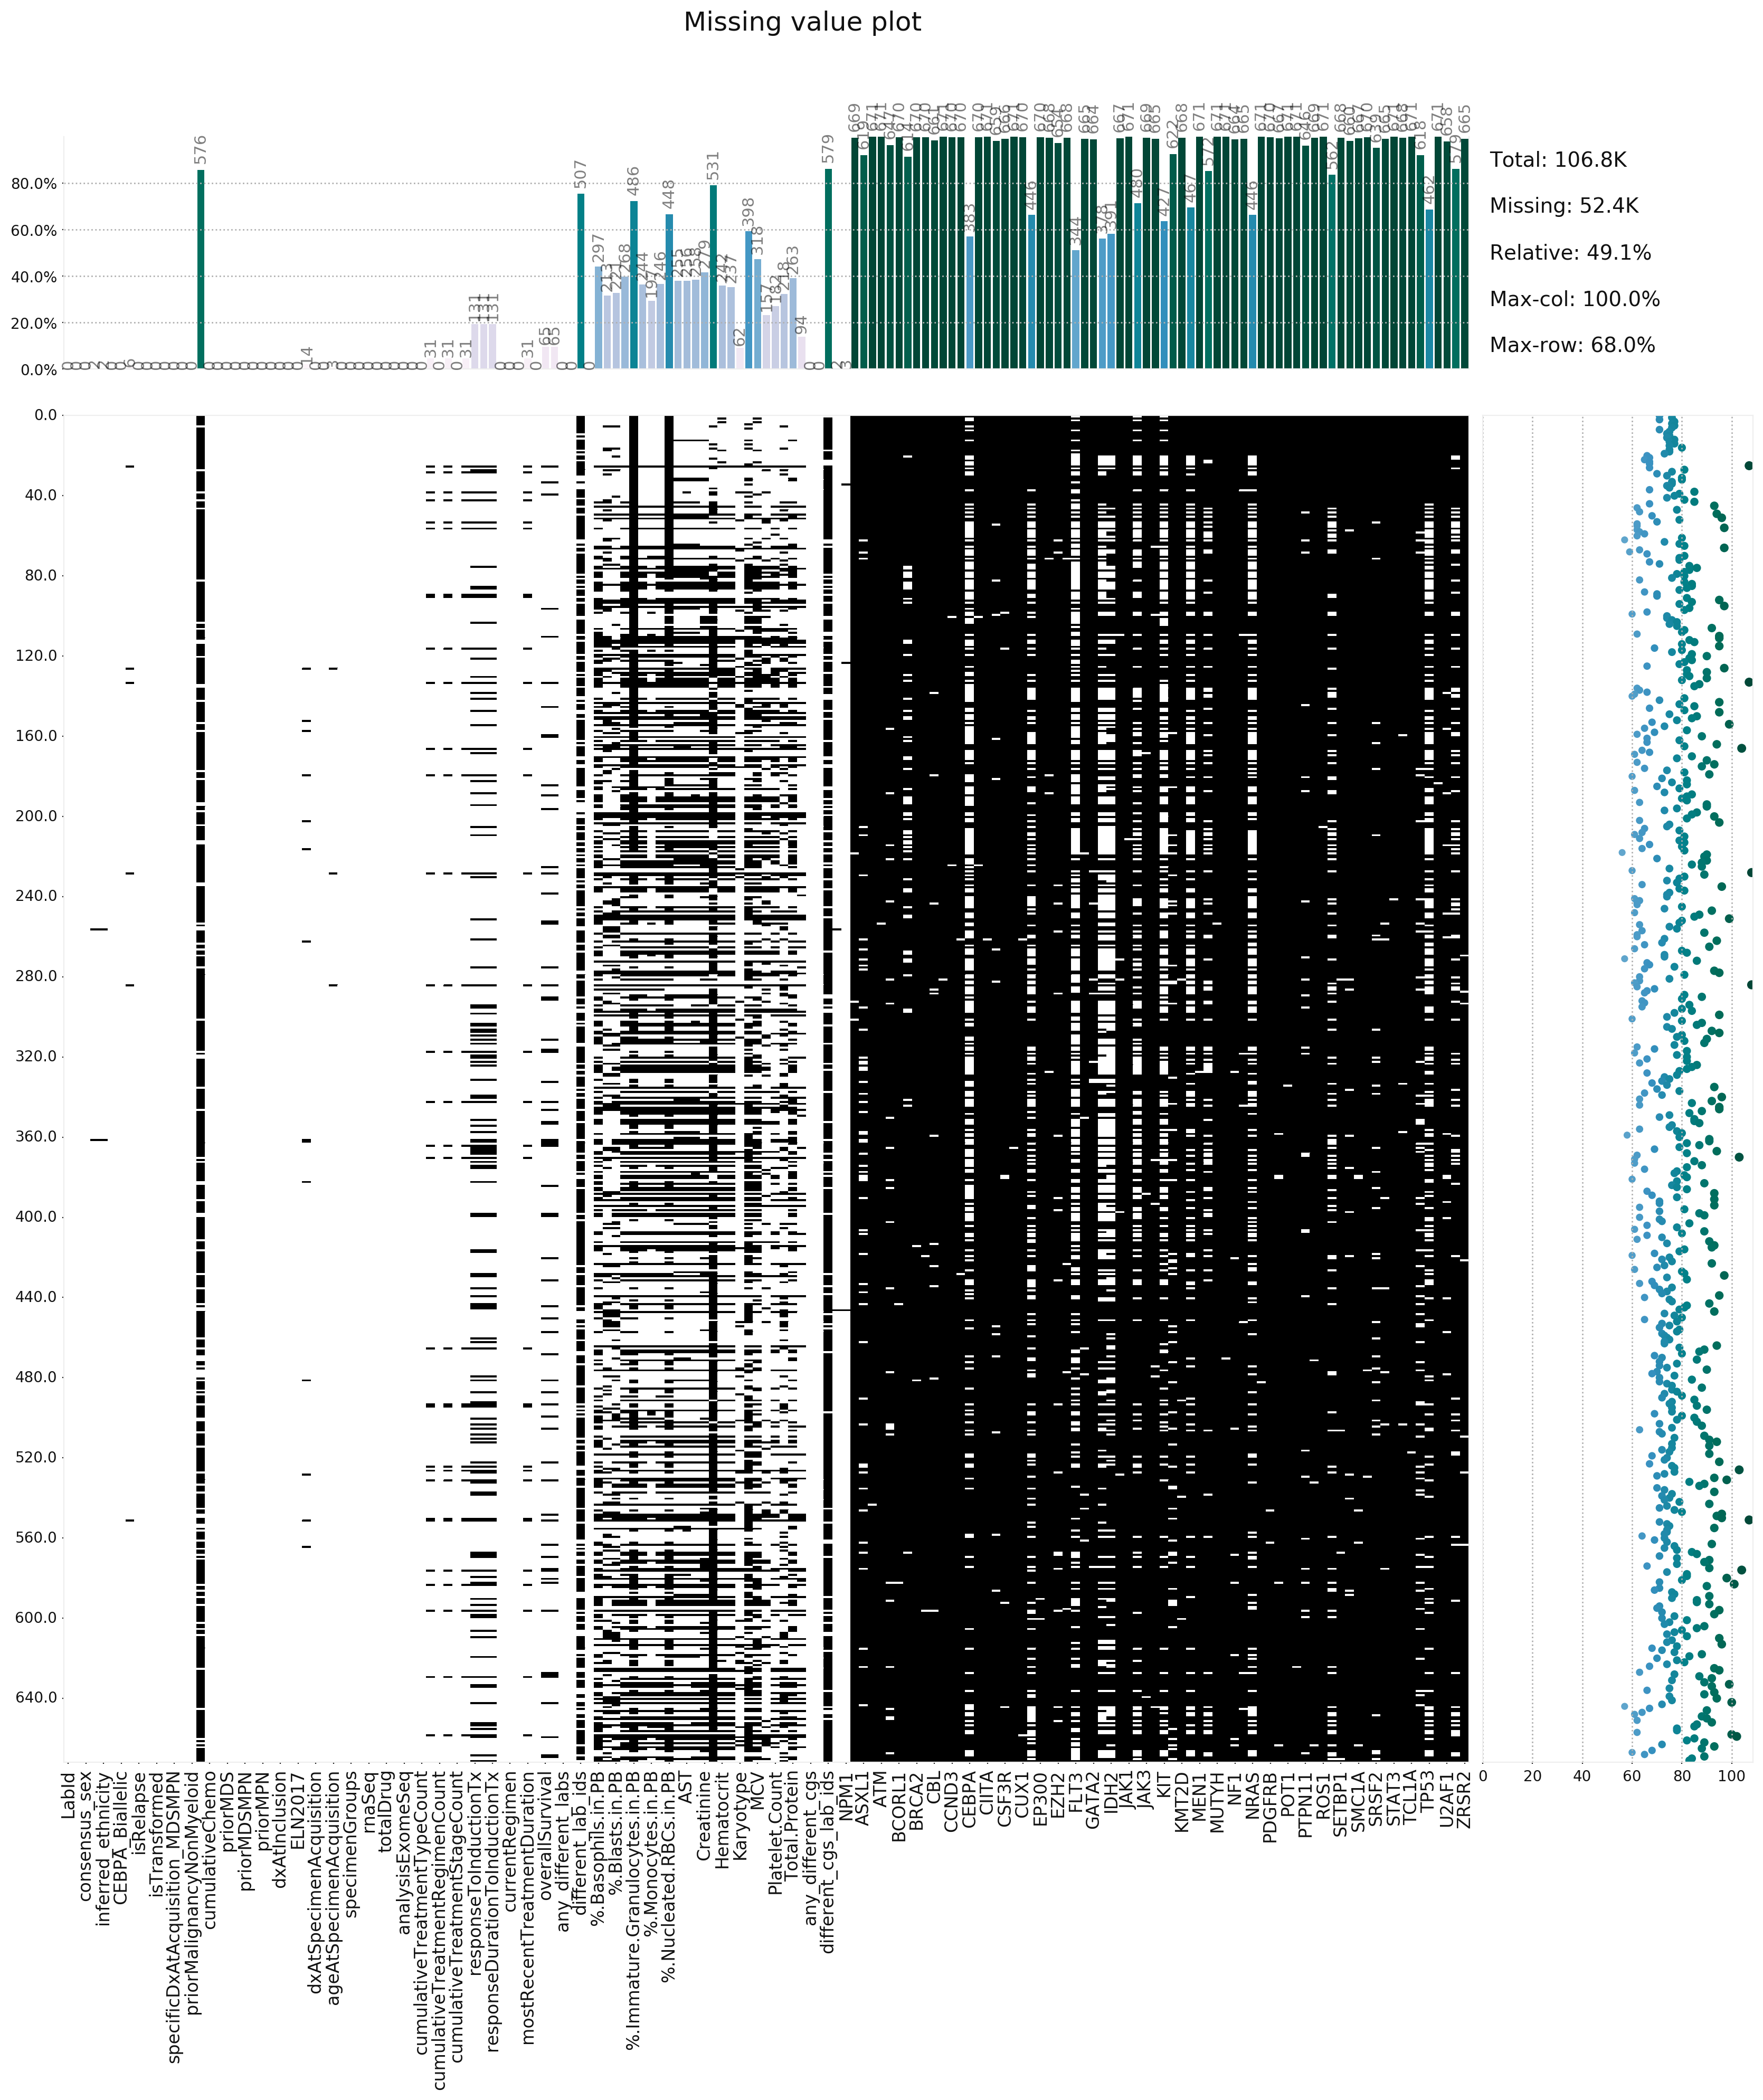

In [52]:
klib.missingval_plot(clsm)

### Create new dataframe to retain relevant features for further use

In [53]:
clsm_cut = pd.DataFrame(clsm[['LabId', 'PatientId', 'consensus_sex', 'inferred_ethnicity', 'isRelapse',
                             'isTransformed', 'priorMalignancyNonMyeloid', 'priorMDS', 'priorMDSMPN', 'priorMPN',
                             'ELN2017', 'dxAtSpecimenAcquisition', 'vitalStatus', 'overallSurvival', '%.Blasts.in.BM', 
                              '%.Blasts.in.PB', 'FLT3-ITD', 'NPM1']])
clsm_cut

LabId  PatientId consensus_sex inferred_ethnicity  isRelapse  \
0    09-00705        163          Male              White      False   
1    10-00136        174          Male              White      False   
2    10-00172        175        Female              White      False   
3    10-00507         45        Female              White      False   
4    10-00542        174          Male              White       True   
..        ...        ...           ...                ...        ...   
667  17-00072       4366          Male              White      False   
668  17-00077       4317        Female              White      False   
669  17-00093       4379        Female              Black      False   
670  17-00094       4380          Male              White      False   
671  17-00096       2747          Male              White      False   

     isTransformed priorMalignancyNonMyeloid priorMDS priorMDSMPN priorMPN  \
0            False                         n        n           n        n   
1            False                         n        n           n        n   
2            False                         n        n           n        n   
3            False                         n        n           n        n   
4            False                         n        n           n        n   
..             ...                       ...      ...         ...      ...   
667           True                         n        n           n        y   
668          False                         n        n           n        n   
669           True                         n        n           n        y   
670           True                         n        n           n        y   
671           True                         n        n           y        n   

                     ELN2017  \
0    FavorableOrIntermediate   
1                    Adverse   
2      IntermediateOrAdverse   
3    FavorableOrIntermediate   
4                    Adverse   
..                       ...   
667             Intermediate   
668                Favorable   
669             Intermediate   
670                  Adverse   
671             Intermediate   

                               dxAtSpecimenAcquisition vitalStatus  \
0    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
1    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
2    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
3    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
4    ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
..                                                 ...         ...   
667  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...        Dead   
668  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...     Unknown   
669  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...     Unknown   
670  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...       Alive   
671  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...       Alive   

     overallSurvival %.Blasts.in.BM %.Blasts.in.PB  FLT3-ITD      NPM1  
0              425.0             94             97  positive  positive  
1              419.0             80             19  positive  negative  
2              541.0             91             99  positive  negative  
3              511.0             97             97  positive  positive  
4              419.0             87             80  positive  negative  
..               ...            ...            ...       ...       ...  
667            362.0            NaN           53.2  negative  negative  
668              NaN             90             74  negative  negative  
669              NaN            NaN             48  positive  negative  
670            153.0             20            NaN  negative  negative  
671            256.0            NaN            NaN  negative  negative  

[672 rows x 18 columns]

In [54]:
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LabId                      672 non-null    object 
 1   PatientId                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         670 non-null    object 
 4   isRelapse                  672 non-null    bool   
 5   isTransformed              672 non-null    bool   
 6   priorMalignancyNonMyeloid  672 non-null    object 
 7   priorMDS                   672 non-null    object 
 8   priorMDSMPN                672 non-null    object 
 9   priorMPN                   672 non-null    object 
 10  ELN2017                    672 non-null    object 
 11  dxAtSpecimenAcquisition    672 non-null    object 
 12  vitalStatus                672 non-null    object 
 13  overallSurvival            607 non-null    float64

In [55]:
clsm_cut.describe()

PatientId  overallSurvival
count   672.000000       607.000000
mean   2088.020833       441.881384
std     973.372734       479.180429
min      17.000000        -1.000000
25%    1450.750000       167.000000
50%    2016.000000       323.000000
75%    2501.500000       555.000000
max    4380.000000      5305.000000

### % Blasts Attributes Numerical Prep
#### %.blasts.in.bm Attribute:

In [56]:
#Attribute Transformation - %.Blasts.in.BM'
#Identify unique values in %.Blasts.in.BM'
clsm_cut['%.Blasts.in.BM'].unique()

array(['94', '80', '91', '97', '87', nan, '40', '75', '83', '95', '85',
       '90', '70', '92', '72', '68', '88', '36', '81', '93', '34', '77.5',
       '46', '65', '50', '76', '71', '60', '73', '55', '0.5', '30', '62',
       '18', '82', '28', '41', '64', '84', '21', '51', '17', '49.4', '32',
       '29', '25', '59.3', '66', '20', '52', '54', '22', '10', '12', '13',
       '67', '39', '25.9', '45', '37', '78', '8', '3', '54.8', '74', '96',
       '4', '86.1', '42', '56', '69', '79', '33', '9', '0.4', '51.5',
       '15', '5', '24', '7', '2', '6', '1', '58', '>50', '35', '86',
       '93.2', '0', '27', '89.6', '23', '98', '19', '91.8', '>95', '57',
       '71.5', '78.3', '63', '1.5', '53.74', '59.5', '44', '42.5', '26',
       '3.5', '48', '26.3', '47', '88.5'], dtype=object)

In [57]:
# > and < will be changed to whole numbers less than or greater than.
clsm_cut['%.Blasts.in.BM'] = clsm_cut['%.Blasts.in.BM'].replace(['>50'], 51)
clsm_cut['%.Blasts.in.BM'] = clsm_cut['%.Blasts.in.BM'].replace(['>95'], 96)

clsm_cut['%.Blasts.in.BM'].unique()

array(['94', '80', '91', '97', '87', nan, '40', '75', '83', '95', '85',
       '90', '70', '92', '72', '68', '88', '36', '81', '93', '34', '77.5',
       '46', '65', '50', '76', '71', '60', '73', '55', '0.5', '30', '62',
       '18', '82', '28', '41', '64', '84', '21', '51', '17', '49.4', '32',
       '29', '25', '59.3', '66', '20', '52', '54', '22', '10', '12', '13',
       '67', '39', '25.9', '45', '37', '78', '8', '3', '54.8', '74', '96',
       '4', '86.1', '42', '56', '69', '79', '33', '9', '0.4', '51.5',
       '15', '5', '24', '7', '2', '6', '1', '58', 51, '35', '86', '93.2',
       '0', '27', '89.6', '23', '98', '19', '91.8', 96, '57', '71.5',
       '78.3', '63', '1.5', '53.74', '59.5', '44', '42.5', '26', '3.5',
       '48', '26.3', '47', '88.5'], dtype=object)

In [58]:
#Attribute Transformation - %.Blasts.in.PB'
#Identify unique values in %.Blasts.in.PB'
clsm_cut['%.Blasts.in.PB'].unique()

array(['97', '19', '99', '80', nan, '51', '30', '41', '84', '77', '75',
       '63', '60', '96', '66', '45', '93', '9', '82', '15', '33', '0',
       '13', '94', '89', '83', '>90', '78', '72', '59', '32', '6', '29',
       '24', '64', '57', '52', '2.1', '<5', '17', '22', '5', '47', '56',
       '25', '23', '42', '65', '71', '8', '3.5', '66.3', '95', '44', '10',
       '28.6', '18', '58', '67', '40', '92', '54', '1', '2', '20', '28',
       '35', '85', '42.4', '16', '49.1', '14', '88', '46', '7', '0.5',
       '79', '26', '87', '20.4', '68', '48', '5.3', '61', '90', '17.4',
       '57.4', '43.8', '50', '37', '4', '3', '12', '81', '11', '90.5',
       '"rare"', '90.2', '55', 'rare', '39', '31', '86', '47.4', '27.4',
       '39.6', '12.9', '15.4', '9.5', '62', '64.6', '27.8', '69.14',
       '52.2', '91', '67.25', '49', '23.7', '48.6', '98', '74.8', '2.6',
       '43', '29.6', '47.5', '38', '2.5', '25.2', '3.56', '70', '99.2',
       '73', '26.7', '38.5', '7.7', '74', '93.3', '12.1', '11.

In [59]:
#%.Blasts.in.PB attribute has 1 "rare" and 1 'rare' record with no flt3 nor npm1 input. This will be changed to NAN
clsm_cut['%.Blasts.in.PB'] = clsm_cut['%.Blasts.in.PB'].replace(['"rare"'], np.nan)
clsm_cut['%.Blasts.in.PB'] = clsm_cut['%.Blasts.in.PB'].replace(['rare'], np.nan)
# > and < will be changed to whole numbers less than or greater than. 
clsm_cut['%.Blasts.in.PB'] = clsm_cut['%.Blasts.in.PB'].replace(['<5'], 4)
clsm_cut['%.Blasts.in.PB'] = clsm_cut['%.Blasts.in.PB'].replace(['>90'], 91)

clsm_cut['%.Blasts.in.PB'].unique()

array(['97', '19', '99', '80', nan, '51', '30', '41', '84', '77', '75',
       '63', '60', '96', '66', '45', '93', '9', '82', '15', '33', '0',
       '13', '94', '89', '83', 91, '78', '72', '59', '32', '6', '29',
       '24', '64', '57', '52', '2.1', 4, '17', '22', '5', '47', '56',
       '25', '23', '42', '65', '71', '8', '3.5', '66.3', '95', '44', '10',
       '28.6', '18', '58', '67', '40', '92', '54', '1', '2', '20', '28',
       '35', '85', '42.4', '16', '49.1', '14', '88', '46', '7', '0.5',
       '79', '26', '87', '20.4', '68', '48', '5.3', '61', '90', '17.4',
       '57.4', '43.8', '50', '37', '4', '3', '12', '81', '11', '90.5',
       '90.2', '55', '39', '31', '86', '47.4', '27.4', '39.6', '12.9',
       '15.4', '9.5', '62', '64.6', '27.8', '69.14', '52.2', '91',
       '67.25', '49', '23.7', '48.6', '98', '74.8', '2.6', '43', '29.6',
       '47.5', '38', '2.5', '25.2', '3.56', '70', '99.2', '73', '26.7',
       '38.5', '7.7', '74', '93.3', '12.1', '11.2', '92.9', '98.4', '6.8

### From Categorical to Numerical
#### Transform &.blasts.in.bm and %.blasts.in.pb from object to float:

In [60]:
clsm_cut['%.Blasts.in.BM'] = clsm_cut['%.Blasts.in.BM'].astype(float)
clsm_cut['%.Blasts.in.PB'] = clsm_cut['%.Blasts.in.PB'].astype(float)

In [61]:
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LabId                      672 non-null    object 
 1   PatientId                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         670 non-null    object 
 4   isRelapse                  672 non-null    bool   
 5   isTransformed              672 non-null    bool   
 6   priorMalignancyNonMyeloid  672 non-null    object 
 7   priorMDS                   672 non-null    object 
 8   priorMDSMPN                672 non-null    object 
 9   priorMPN                   672 non-null    object 
 10  ELN2017                    672 non-null    object 
 11  dxAtSpecimenAcquisition    672 non-null    object 
 12  vitalStatus                672 non-null    object 
 13  overallSurvival            607 non-null    float64

### clsm_cut Identify Missing Values

GridSpec(6, 6)

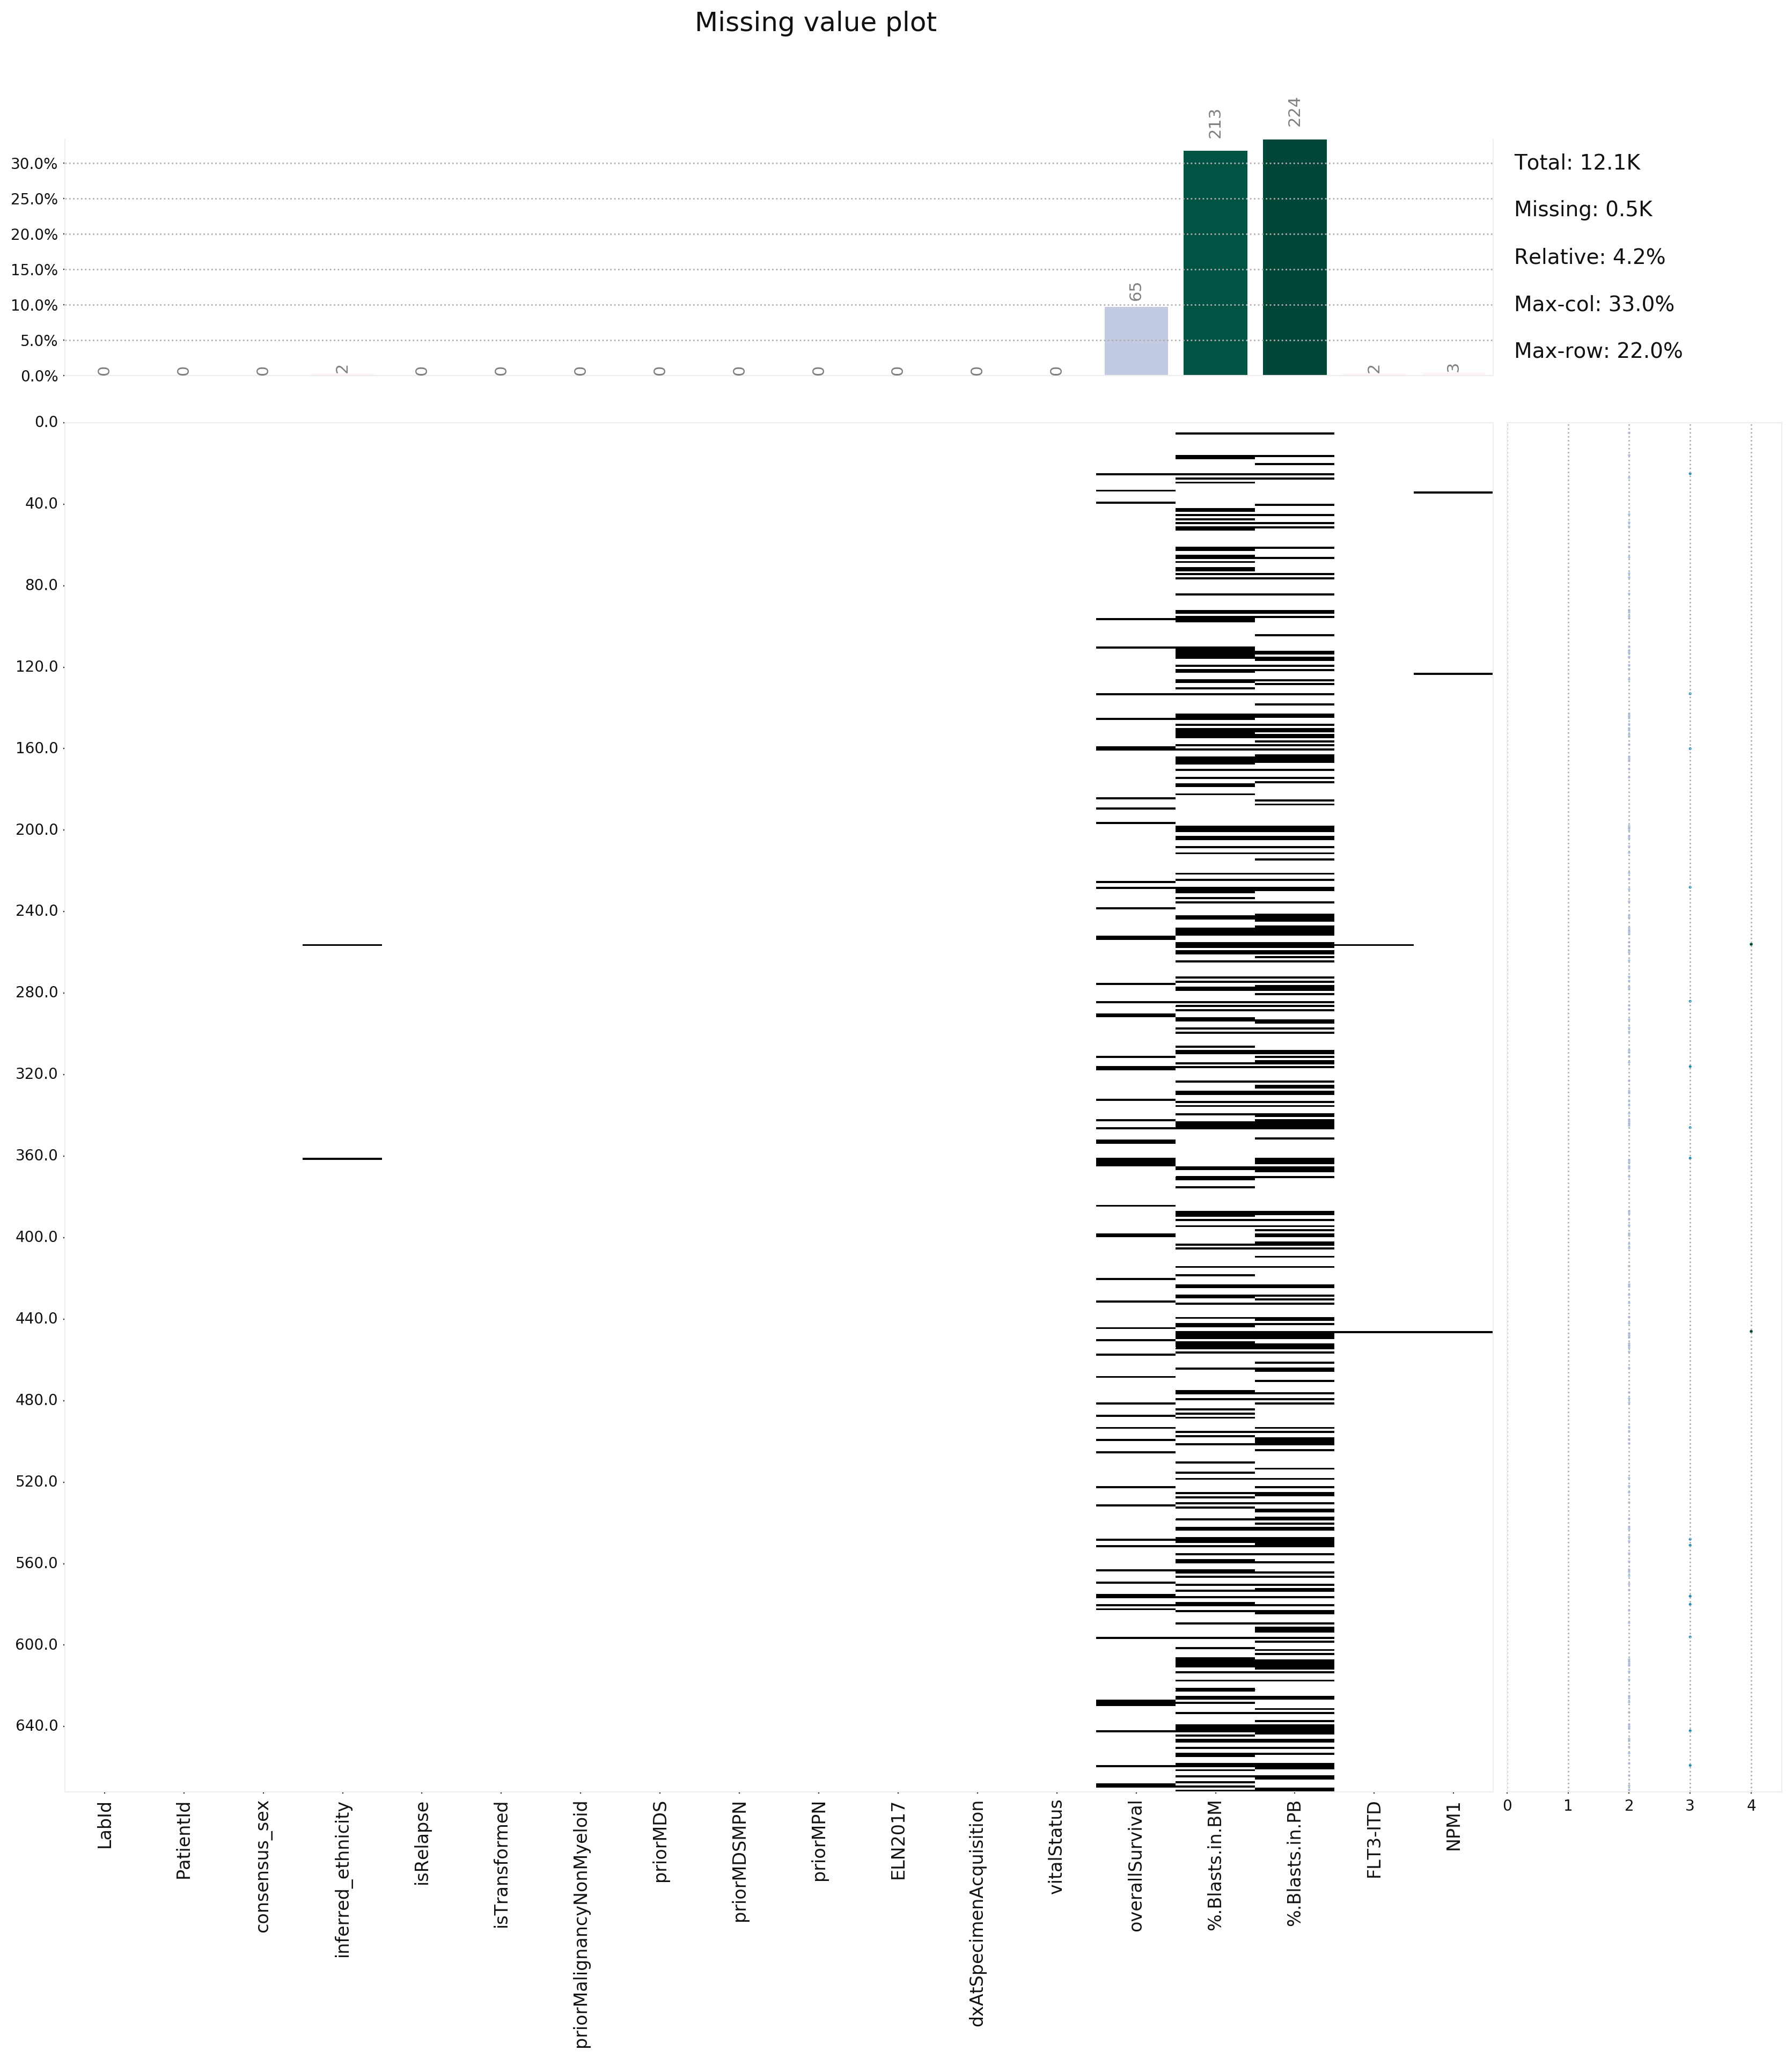

In [62]:
klib.missingval_plot(clsm_cut)

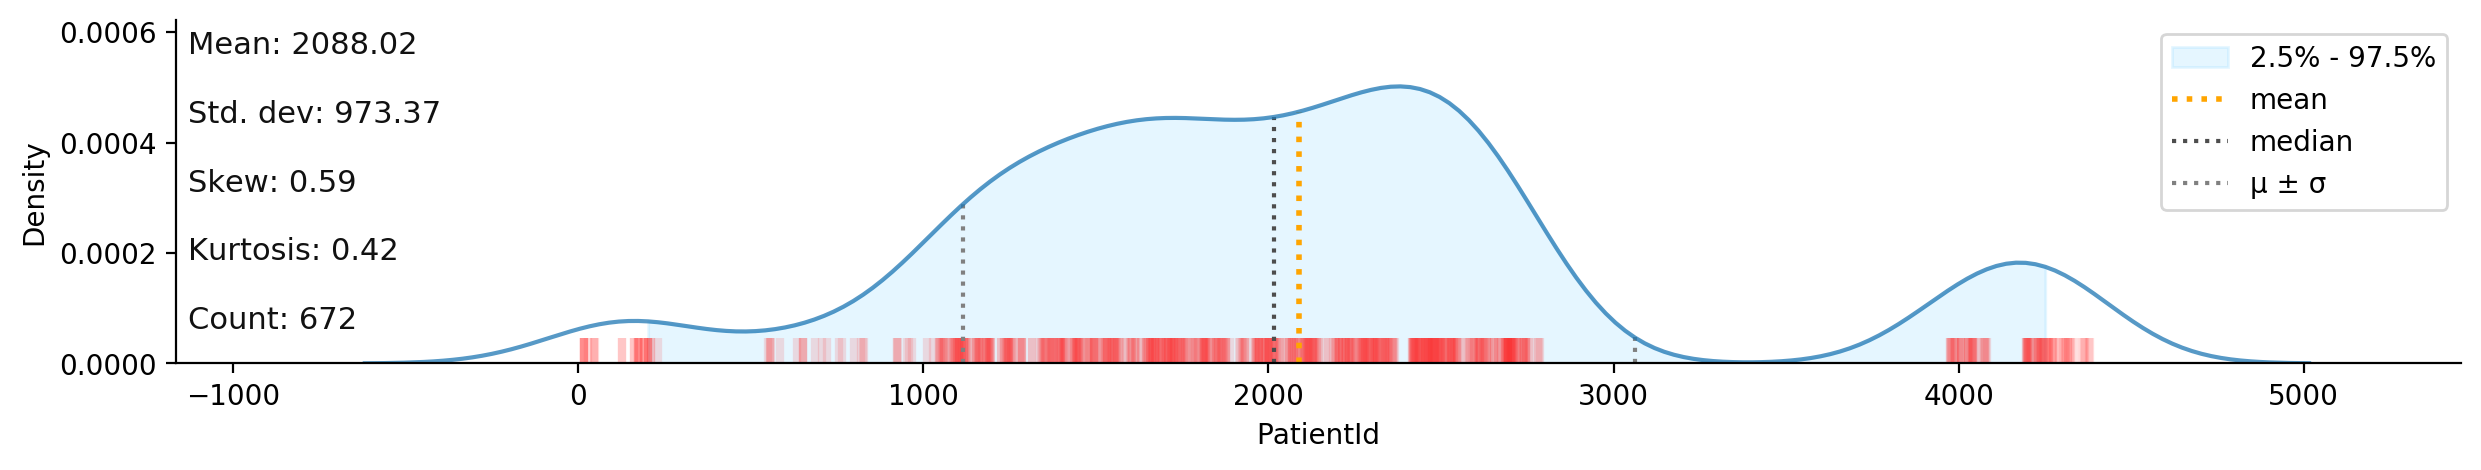

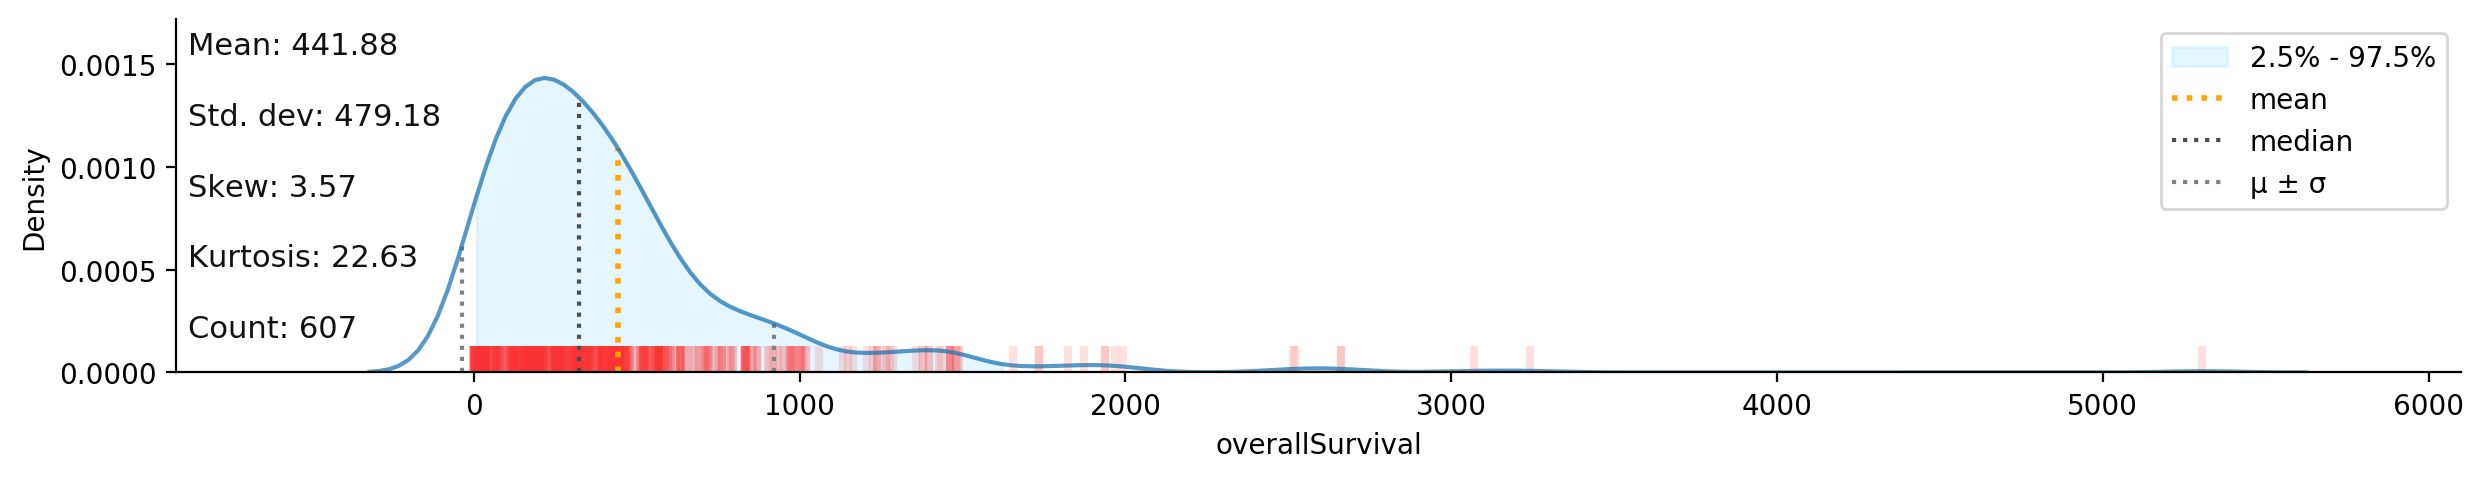

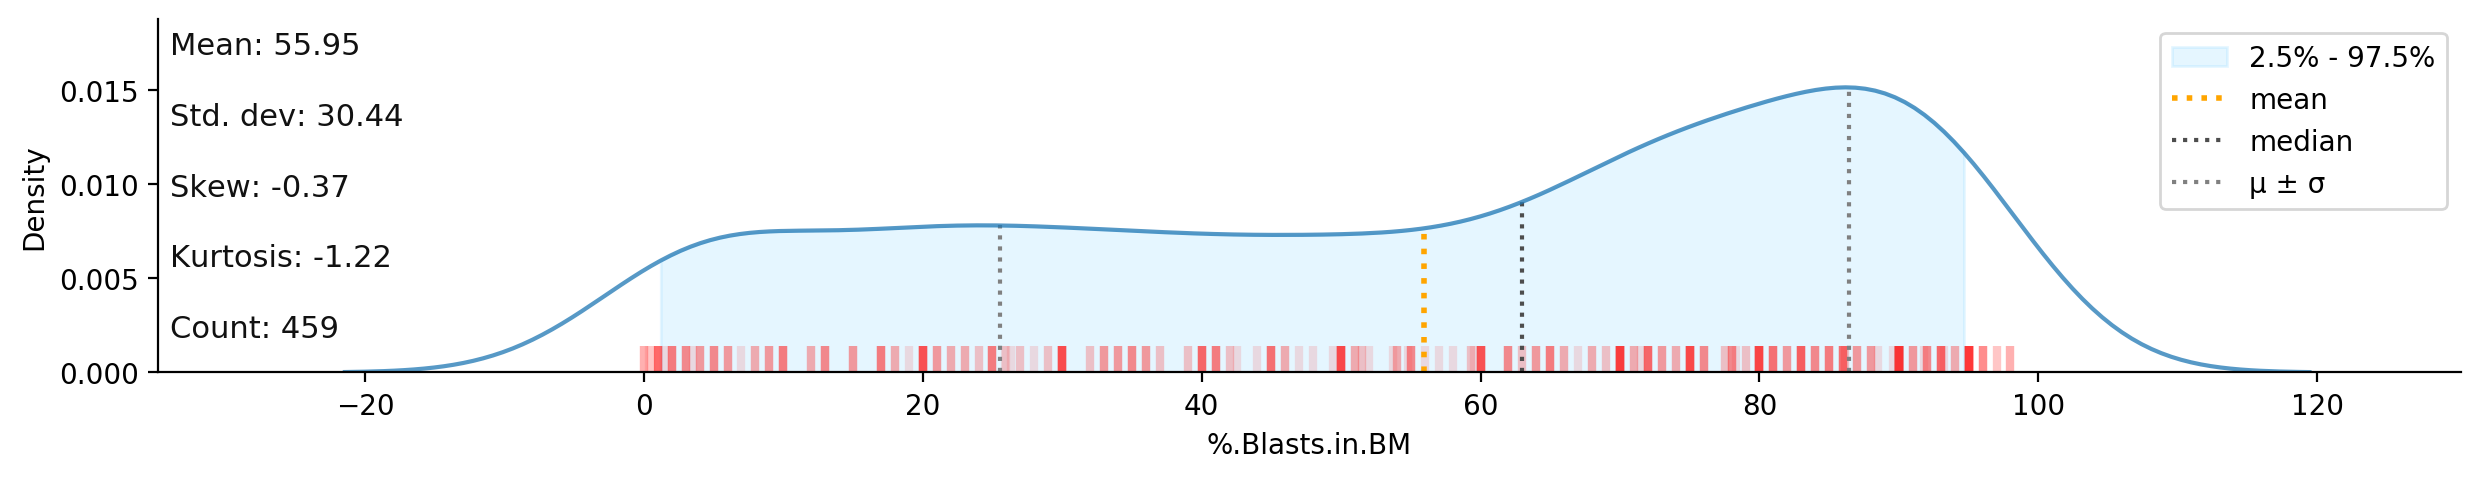

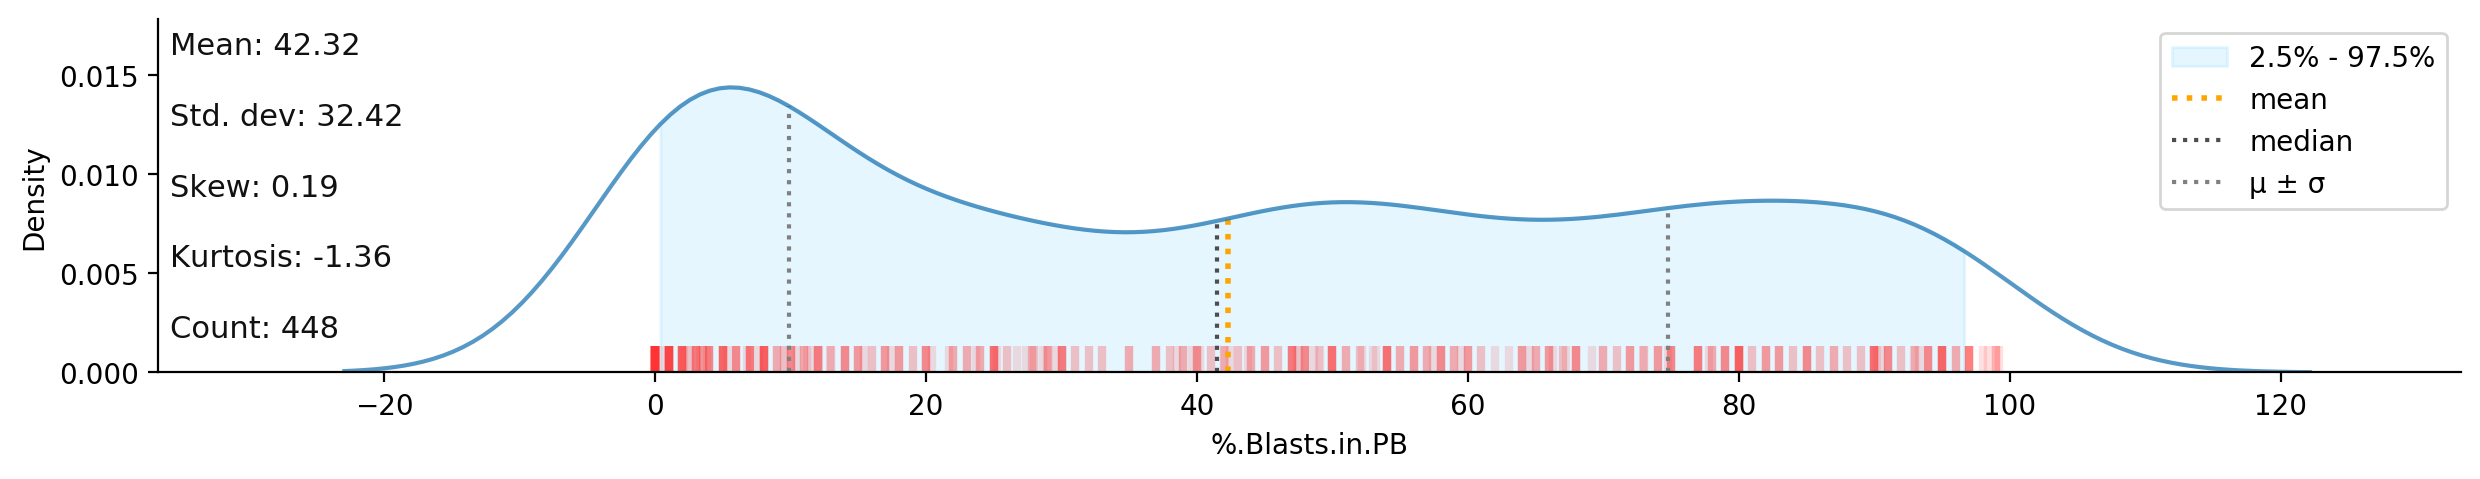

In [63]:
#Replace Missing Value
klib.dist_plot(clsm_cut)

In [64]:
clsm_cut.describe()

PatientId  overallSurvival  %.Blasts.in.BM  %.Blasts.in.PB
count   672.000000       607.000000      459.000000      448.000000
mean   2088.020833       441.881384       55.949325       42.316629
std     973.372734       479.180429       30.440925       32.418249
min      17.000000        -1.000000        0.000000        0.000000
25%    1450.750000       167.000000       30.000000       10.000000
50%    2016.000000       323.000000       63.000000       41.500000
75%    2501.500000       555.000000       83.000000       72.000000
max    4380.000000      5305.000000       98.000000       99.200000

In [65]:
#From distibution, skewness suggest median is the best representation. 
clsm_cut['overallSurvival'] = clsm_cut['overallSurvival'].fillna(clsm_cut['overallSurvival'].median())
clsm_cut['%.Blasts.in.BM'] = clsm_cut['%.Blasts.in.BM'].fillna(clsm_cut['%.Blasts.in.BM'].median())
clsm_cut['%.Blasts.in.PB'] = clsm_cut['%.Blasts.in.PB'].fillna(clsm_cut['%.Blasts.in.PB'].median())

In [66]:
#Replace categorical NaN with unknown
clsm_cut = clsm_cut.replace(np.nan, 'unknown', regex=True)

In [67]:
#Determine mode of inferred_ethnicity
clsm_cut['inferred_ethnicity'].mode()

0    White
dtype: object

In [68]:
#In inferred_ethnicity, replace mode of unknown to white:
clsm_cut['inferred_ethnicity'] = clsm_cut['inferred_ethnicity'].replace(['unknown'], 'white')

clsm_cut['inferred_ethnicity'].unique()

array(['White', 'HispNative', 'AdmixedBlack', 'Asian', 'Black',
       'AdmixedAsian', 'white', 'AdmixedWhite', 'AdmixedHispNative'],
      dtype=object)

In [69]:
#Determine mode of flt3-itd
clsm_cut['FLT3-ITD'].mode()

0    negative
dtype: object

In [70]:
#In flt3-itd, replace mode of unknown to negative:
clsm_cut['FLT3-ITD'] = clsm_cut['FLT3-ITD'].replace(['unknown'], 'negative')
clsm_cut['FLT3-ITD'].unique()

array(['positive', 'negative'], dtype=object)

In [71]:
clsm_cut['NPM1'].mode()

0    negative
dtype: object

In [72]:
#In npm1, replace mode of unknown to negative:
clsm_cut['NPM1'] = clsm_cut['NPM1'].replace(['unknown'], 'negative')
clsm_cut['NPM1'].unique()

array(['positive', 'negative'], dtype=object)

In [73]:
#Check for missing values
klib.missingval_plot(clsm_cut)

No missing values found in the dataset.


In [74]:
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LabId                      672 non-null    object 
 1   PatientId                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         672 non-null    object 
 4   isRelapse                  672 non-null    bool   
 5   isTransformed              672 non-null    bool   
 6   priorMalignancyNonMyeloid  672 non-null    object 
 7   priorMDS                   672 non-null    object 
 8   priorMDSMPN                672 non-null    object 
 9   priorMPN                   672 non-null    object 
 10  ELN2017                    672 non-null    object 
 11  dxAtSpecimenAcquisition    672 non-null    object 
 12  vitalStatus                672 non-null    object 
 13  overallSurvival            672 non-null    float64

### Check for Duplicates

In [75]:
#Remove duplicated columns
clsm_cut = clsm_cut.drop_duplicates(ignore_index=True)
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   LabId                      672 non-null    object 
 1   PatientId                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         672 non-null    object 
 4   isRelapse                  672 non-null    bool   
 5   isTransformed              672 non-null    bool   
 6   priorMalignancyNonMyeloid  672 non-null    object 
 7   priorMDS                   672 non-null    object 
 8   priorMDSMPN                672 non-null    object 
 9   priorMPN                   672 non-null    object 
 10  ELN2017                    672 non-null    object 
 11  dxAtSpecimenAcquisition    672 non-null    object 
 12  vitalStatus                672 non-null    object 
 13  overallSurvival            672 non-null    float64

In [76]:
clsm_cut.duplicated().sum()

0

### Data Exploration

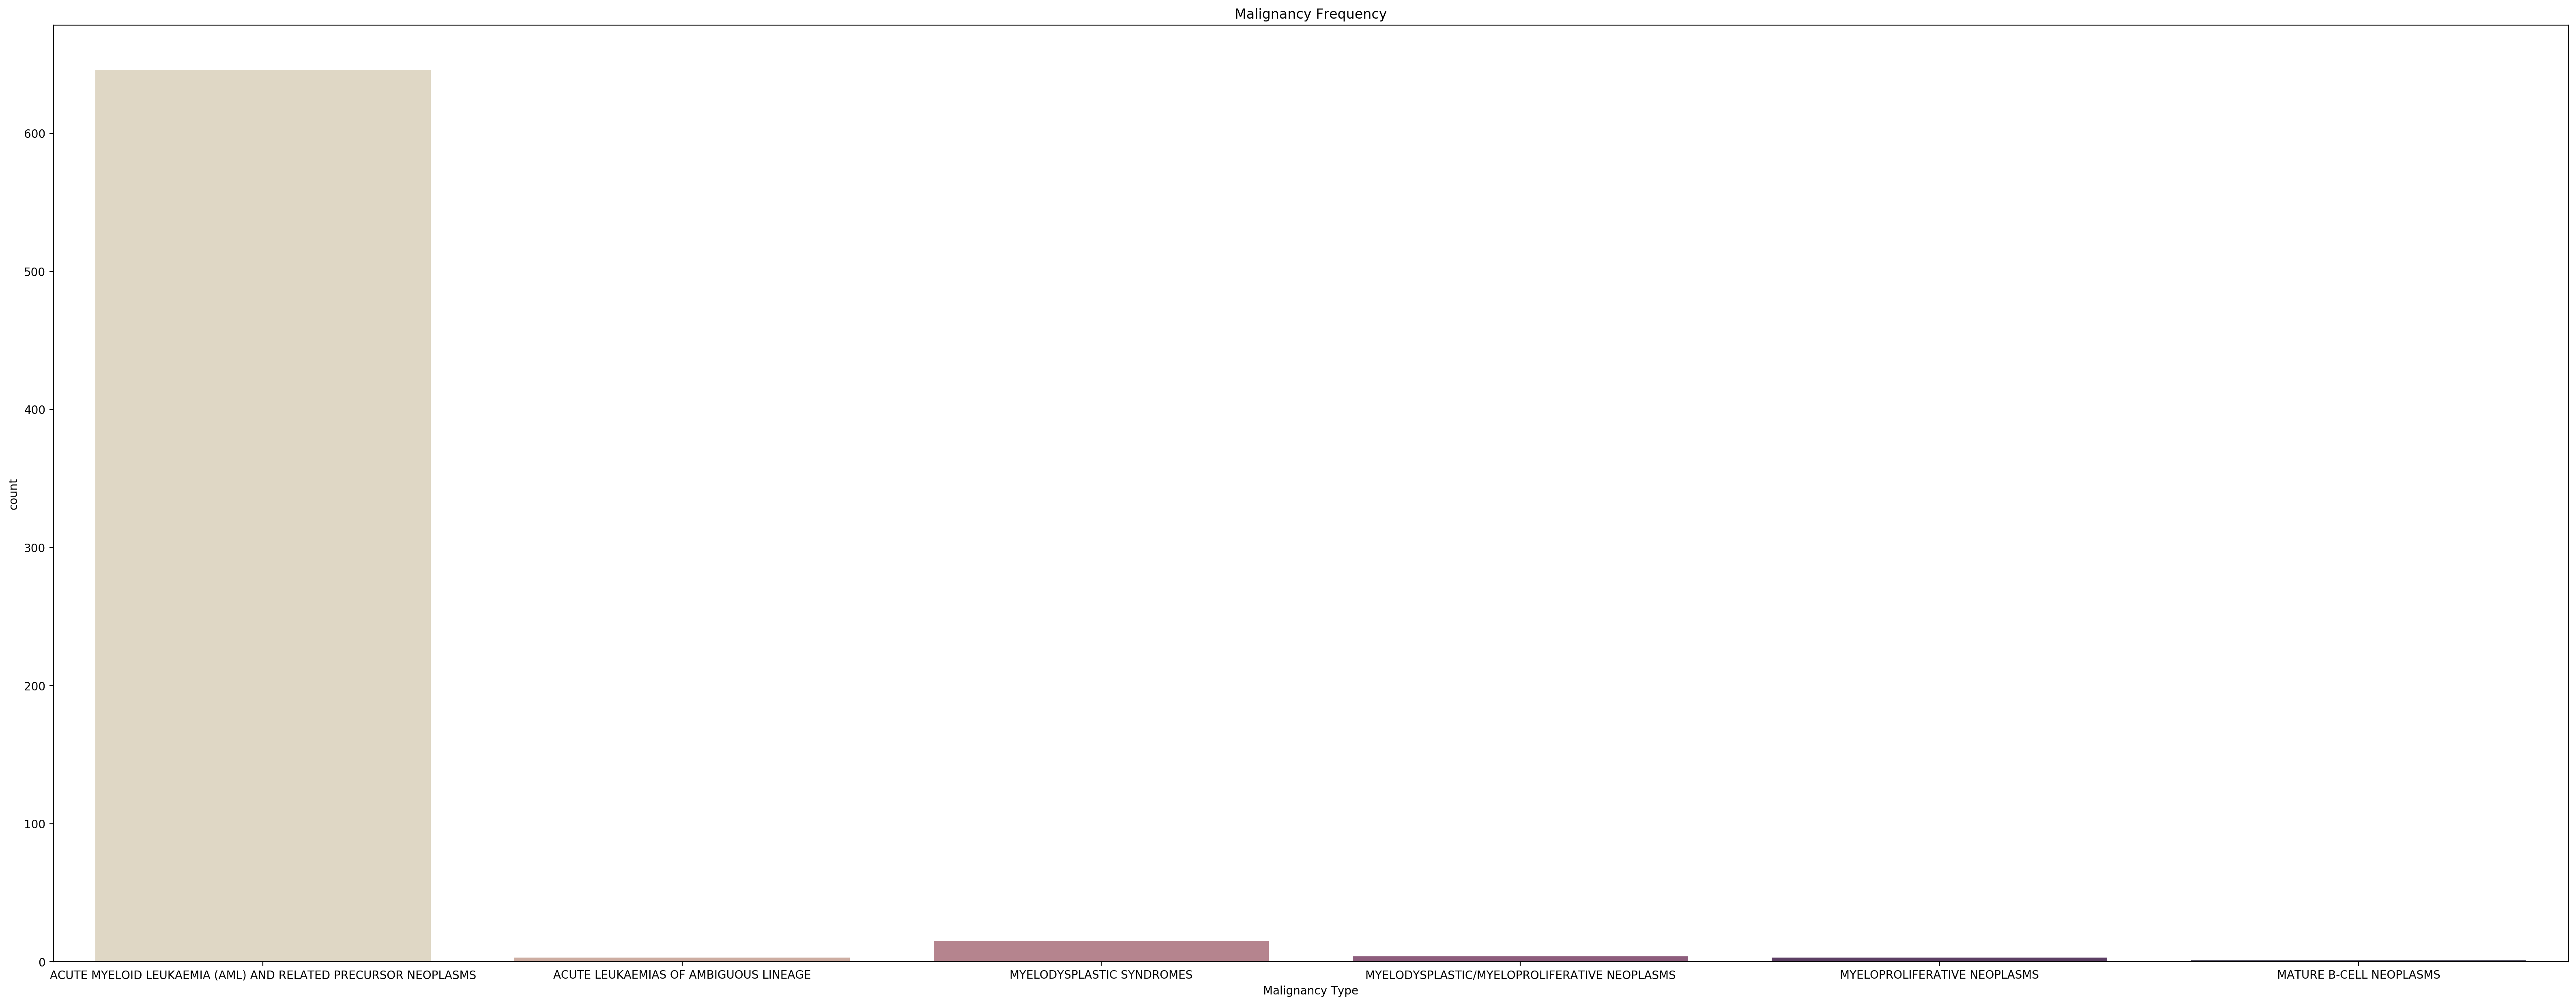

In [77]:
#Data Visualization - "dxAtSpecimenAcquisition
sns.countplot(x=clsm_cut["dxAtSpecimenAcquisition"], palette = "ch:s=-.2,r=.6")
plt.xlabel('Malignancy Type')
plt.title('Malignancy Frequency')
plt.gcf().set_size_inches(40, 15)

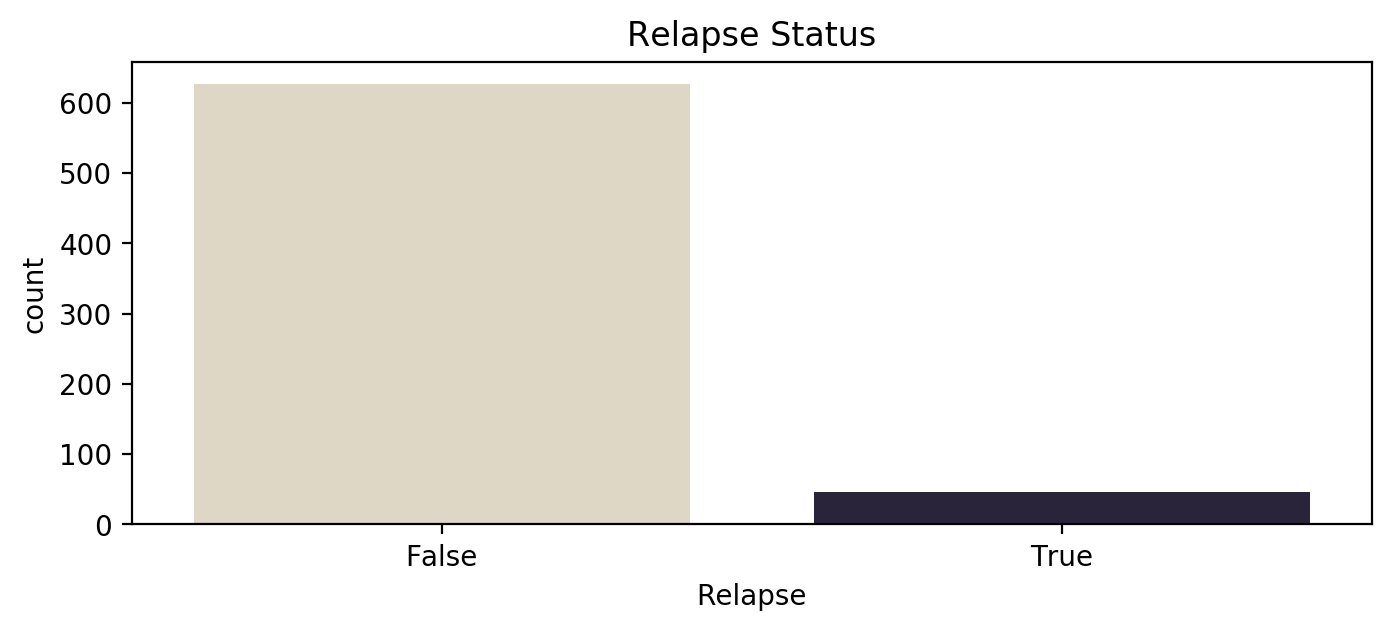

In [78]:
#Data Visualization - "isRelapse"
sns.countplot(x=clsm_cut["isRelapse"], palette = "ch:s=-.2,r=.6")
plt.xlabel('Relapse')
plt.title('Relapse Status')
plt.gcf().set_size_inches(8, 3)

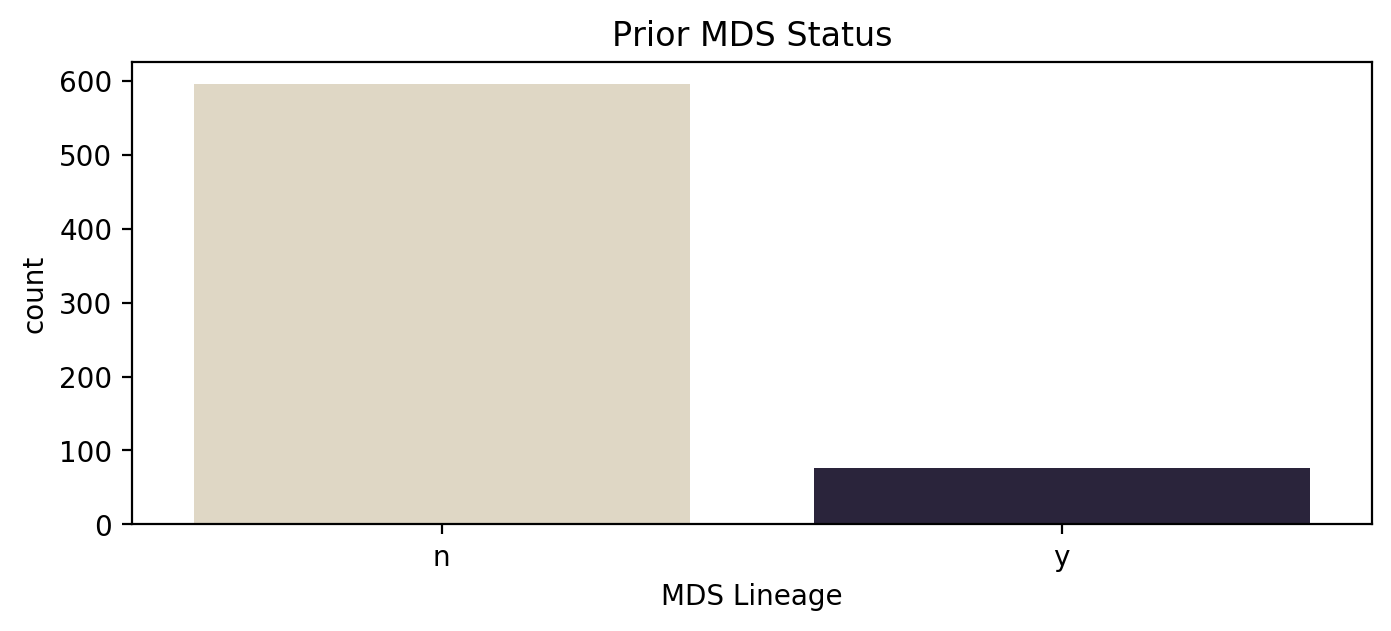

In [79]:
#Data Visualization - "priorMDS"
sns.countplot(x=clsm_cut["priorMDS"], palette = "ch:s=-.2,r=.6")
plt.xlabel('MDS Lineage')
plt.title('Prior MDS Status')
plt.gcf().set_size_inches(8, 3)

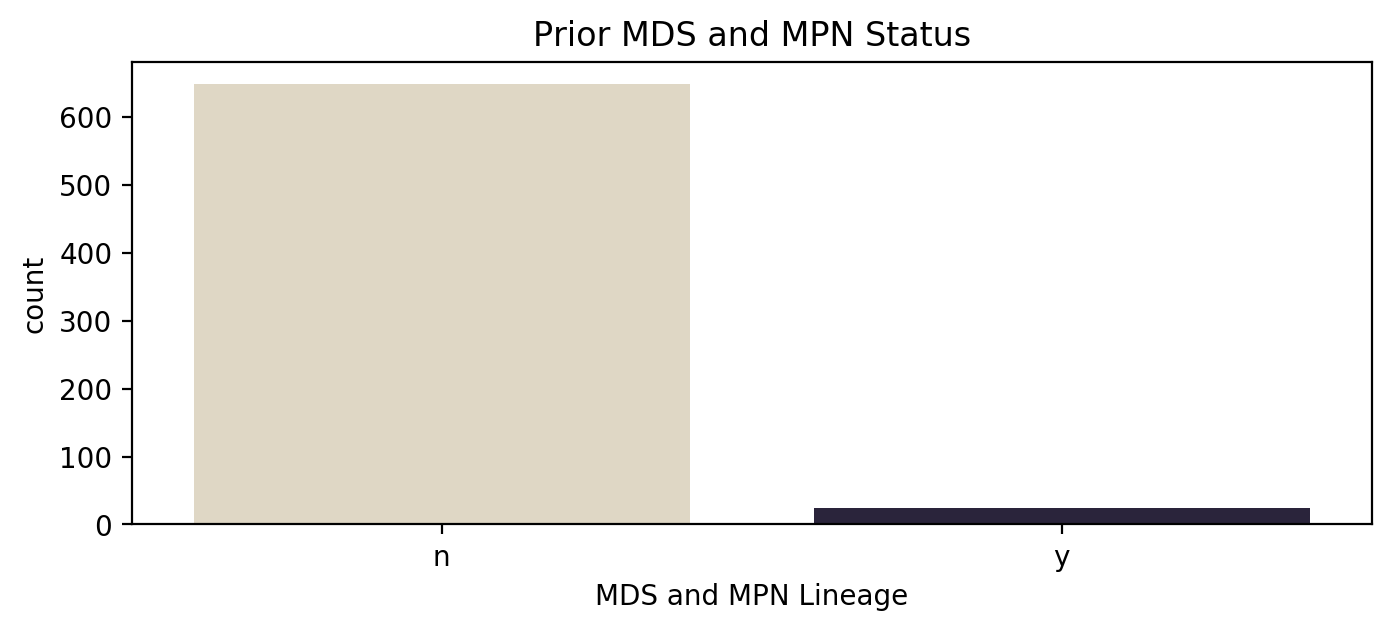

In [80]:
#Data Visualization - "priorMDSMPN"
sns.countplot(x=clsm_cut["priorMDSMPN"], palette = "ch:s=-.2,r=.6")
plt.xlabel('MDS and MPN Lineage')
plt.title('Prior MDS and MPN Status')
plt.gcf().set_size_inches(8, 3)

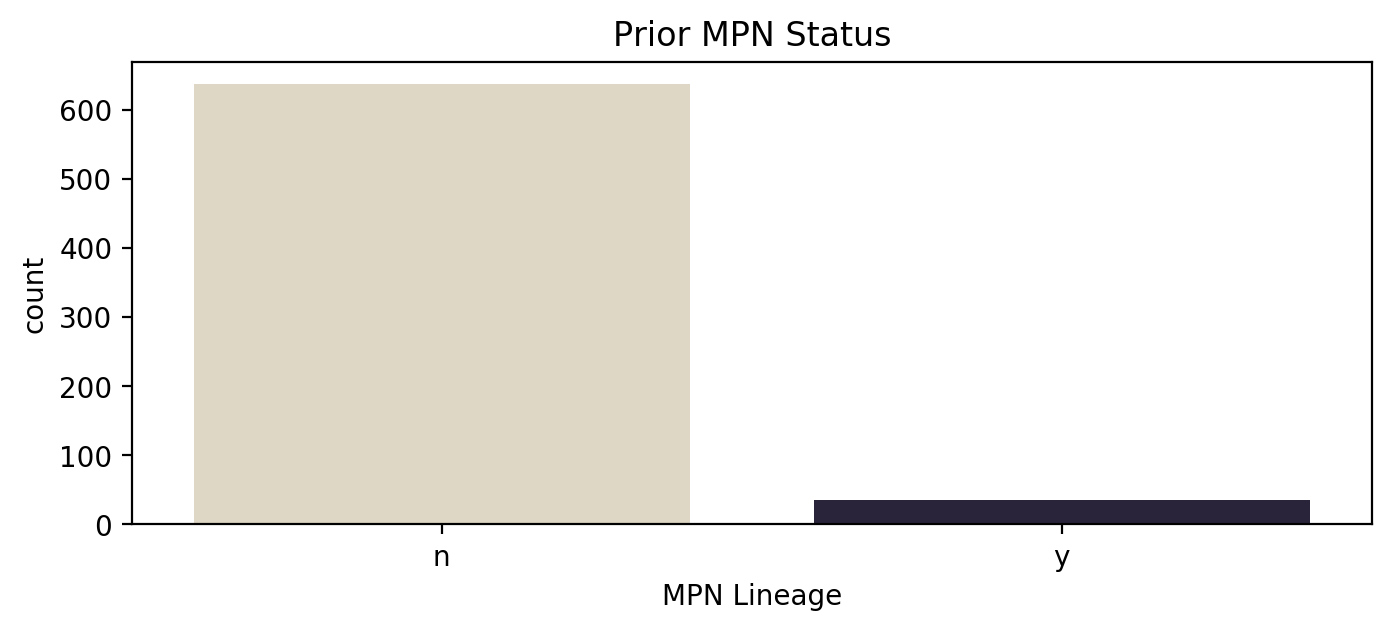

In [81]:
#Data Visualization - "priorMPN"
sns.countplot(x=clsm_cut["priorMPN"], palette = "ch:s=-.2,r=.6")
plt.xlabel('MPN Lineage')
plt.title('Prior MPN Status')
plt.gcf().set_size_inches(8, 3)

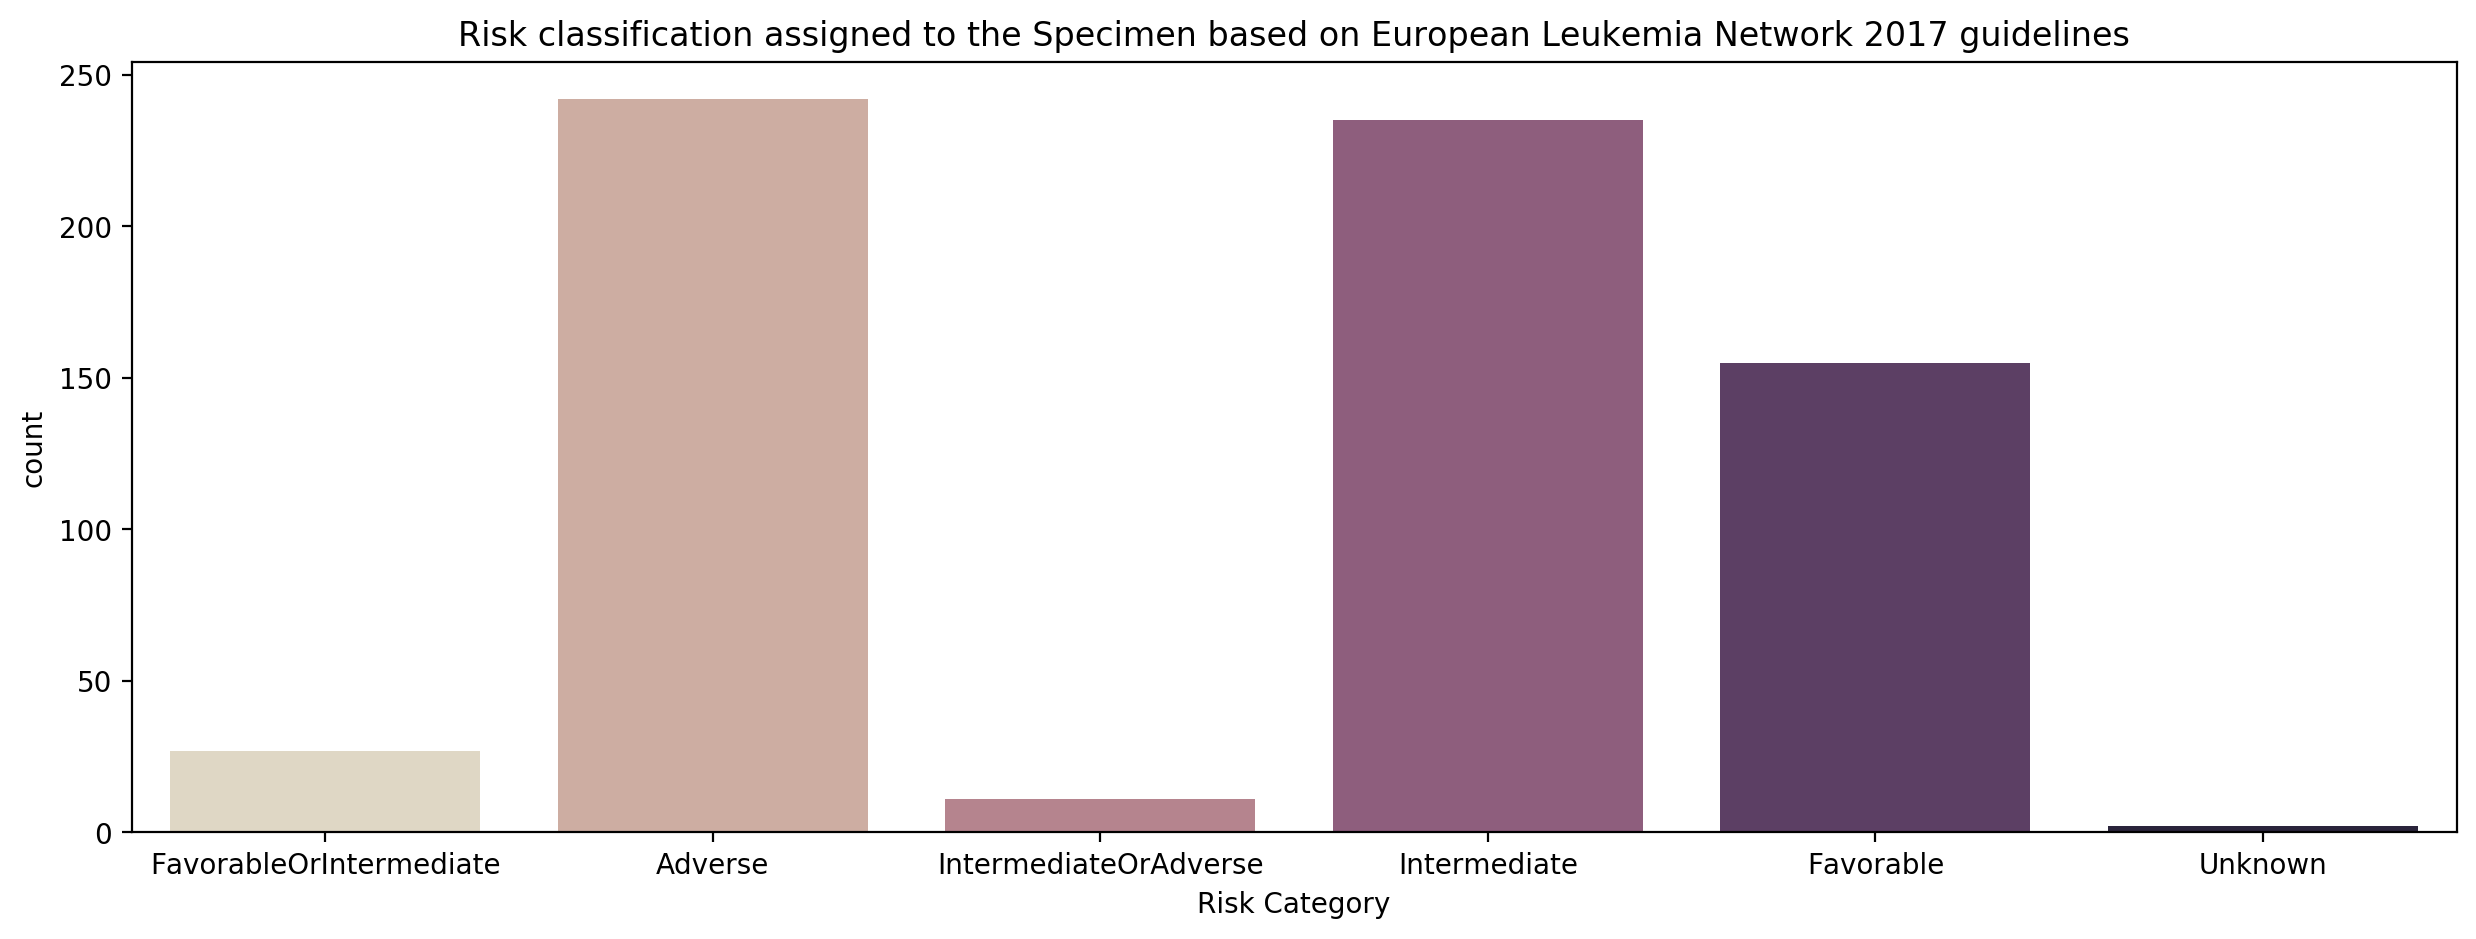

In [82]:
#Data Visualization - "ELN2017"
sns.countplot(x=clsm_cut["ELN2017"], palette = "ch:s=-.2,r=.6")
plt.xlabel('Risk Category')
plt.title('Risk classification assigned to the Specimen based on European Leukemia Network 2017 guidelines')
plt.gcf().set_size_inches(15, 5)

Text(0.5, 1.0, 'Survival Against NPM1 Mutation')

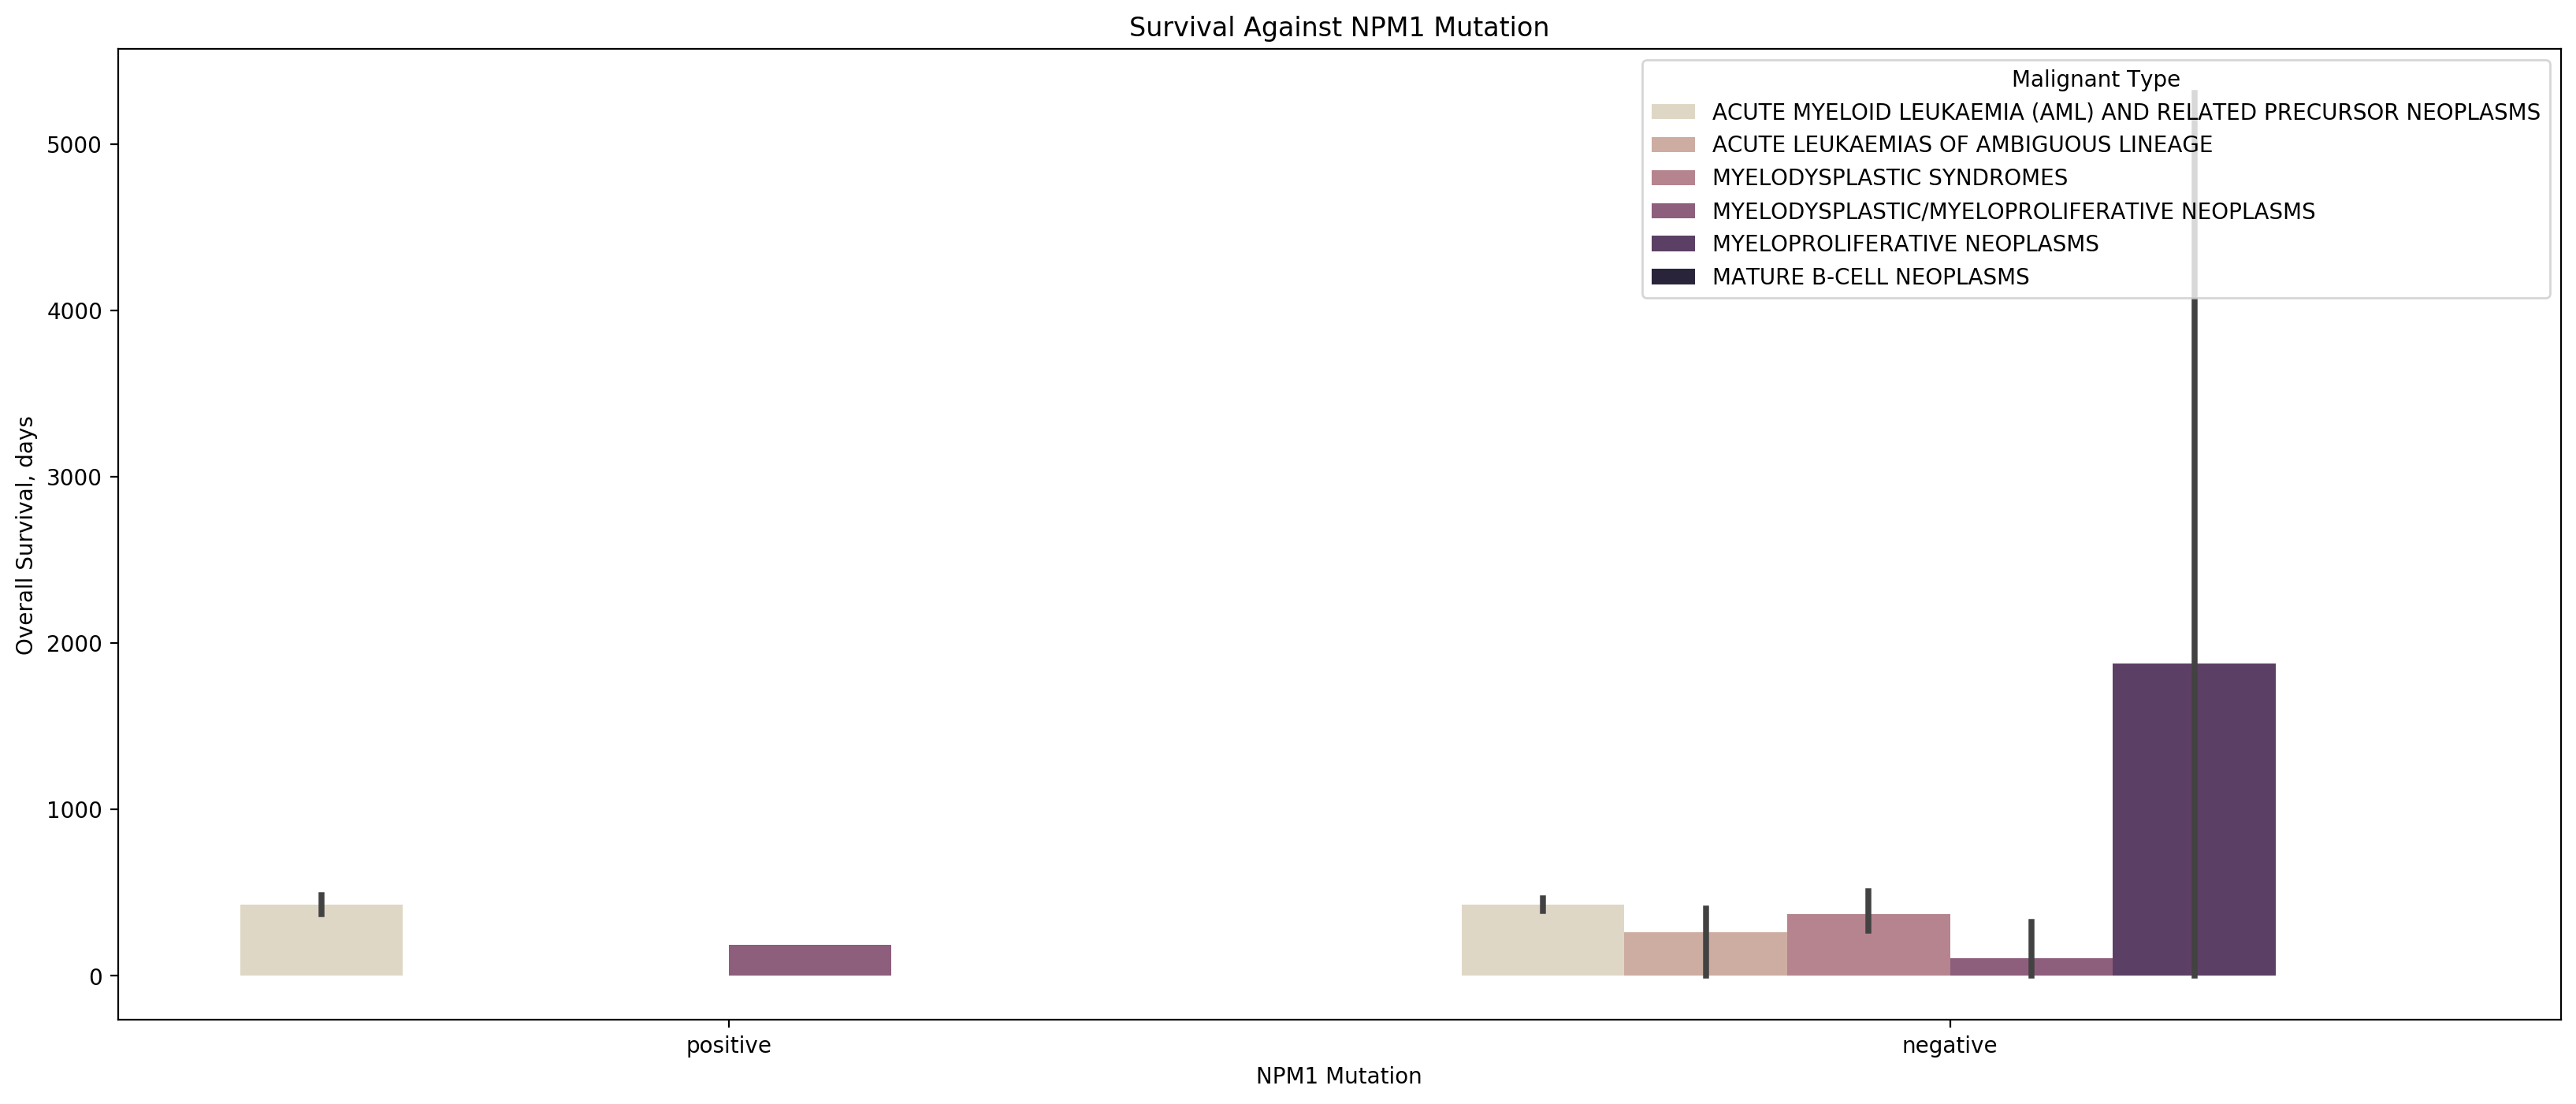

In [83]:
sns.barplot(data= clsm_cut,x = 'NPM1', y = 'overallSurvival', 
            hue = 'dxAtSpecimenAcquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against NPM1 Mutation")

Text(0.5, 1.0, 'Survival Against FLT3-ITD Mutation')

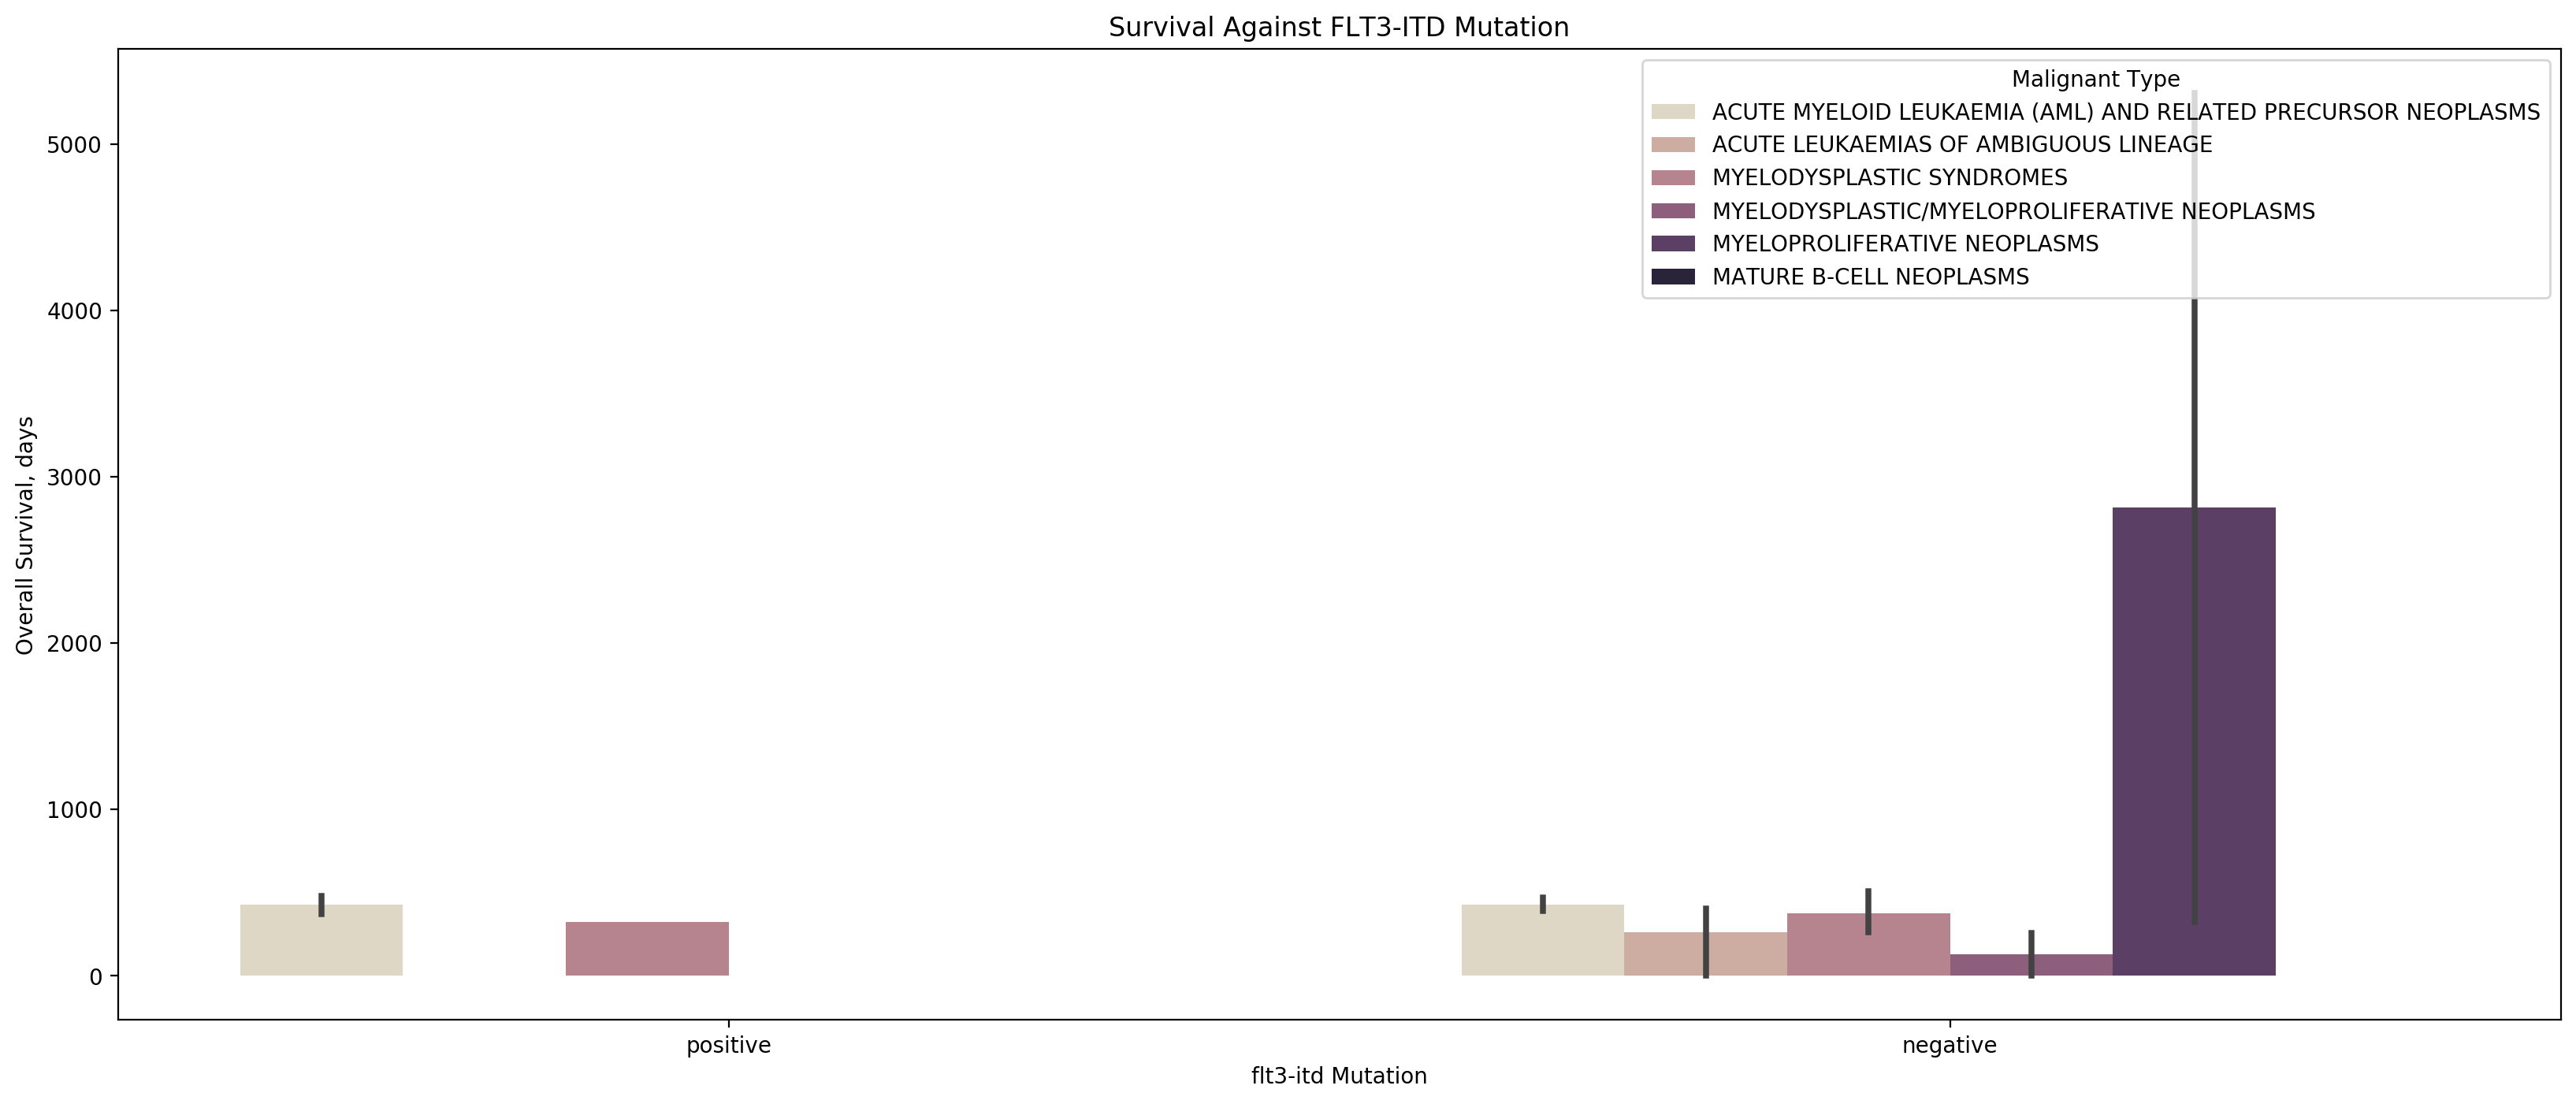

In [84]:
sns.barplot(data= clsm_cut,x = 'FLT3-ITD', y = 'overallSurvival', 
            hue = 'dxAtSpecimenAcquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('flt3-itd Mutation')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against FLT3-ITD Mutation")

Text(0.5, 1.0, 'Survival Against Risk classification assigned to the Specimen based on European Leukemia Network 2017 guidelines')

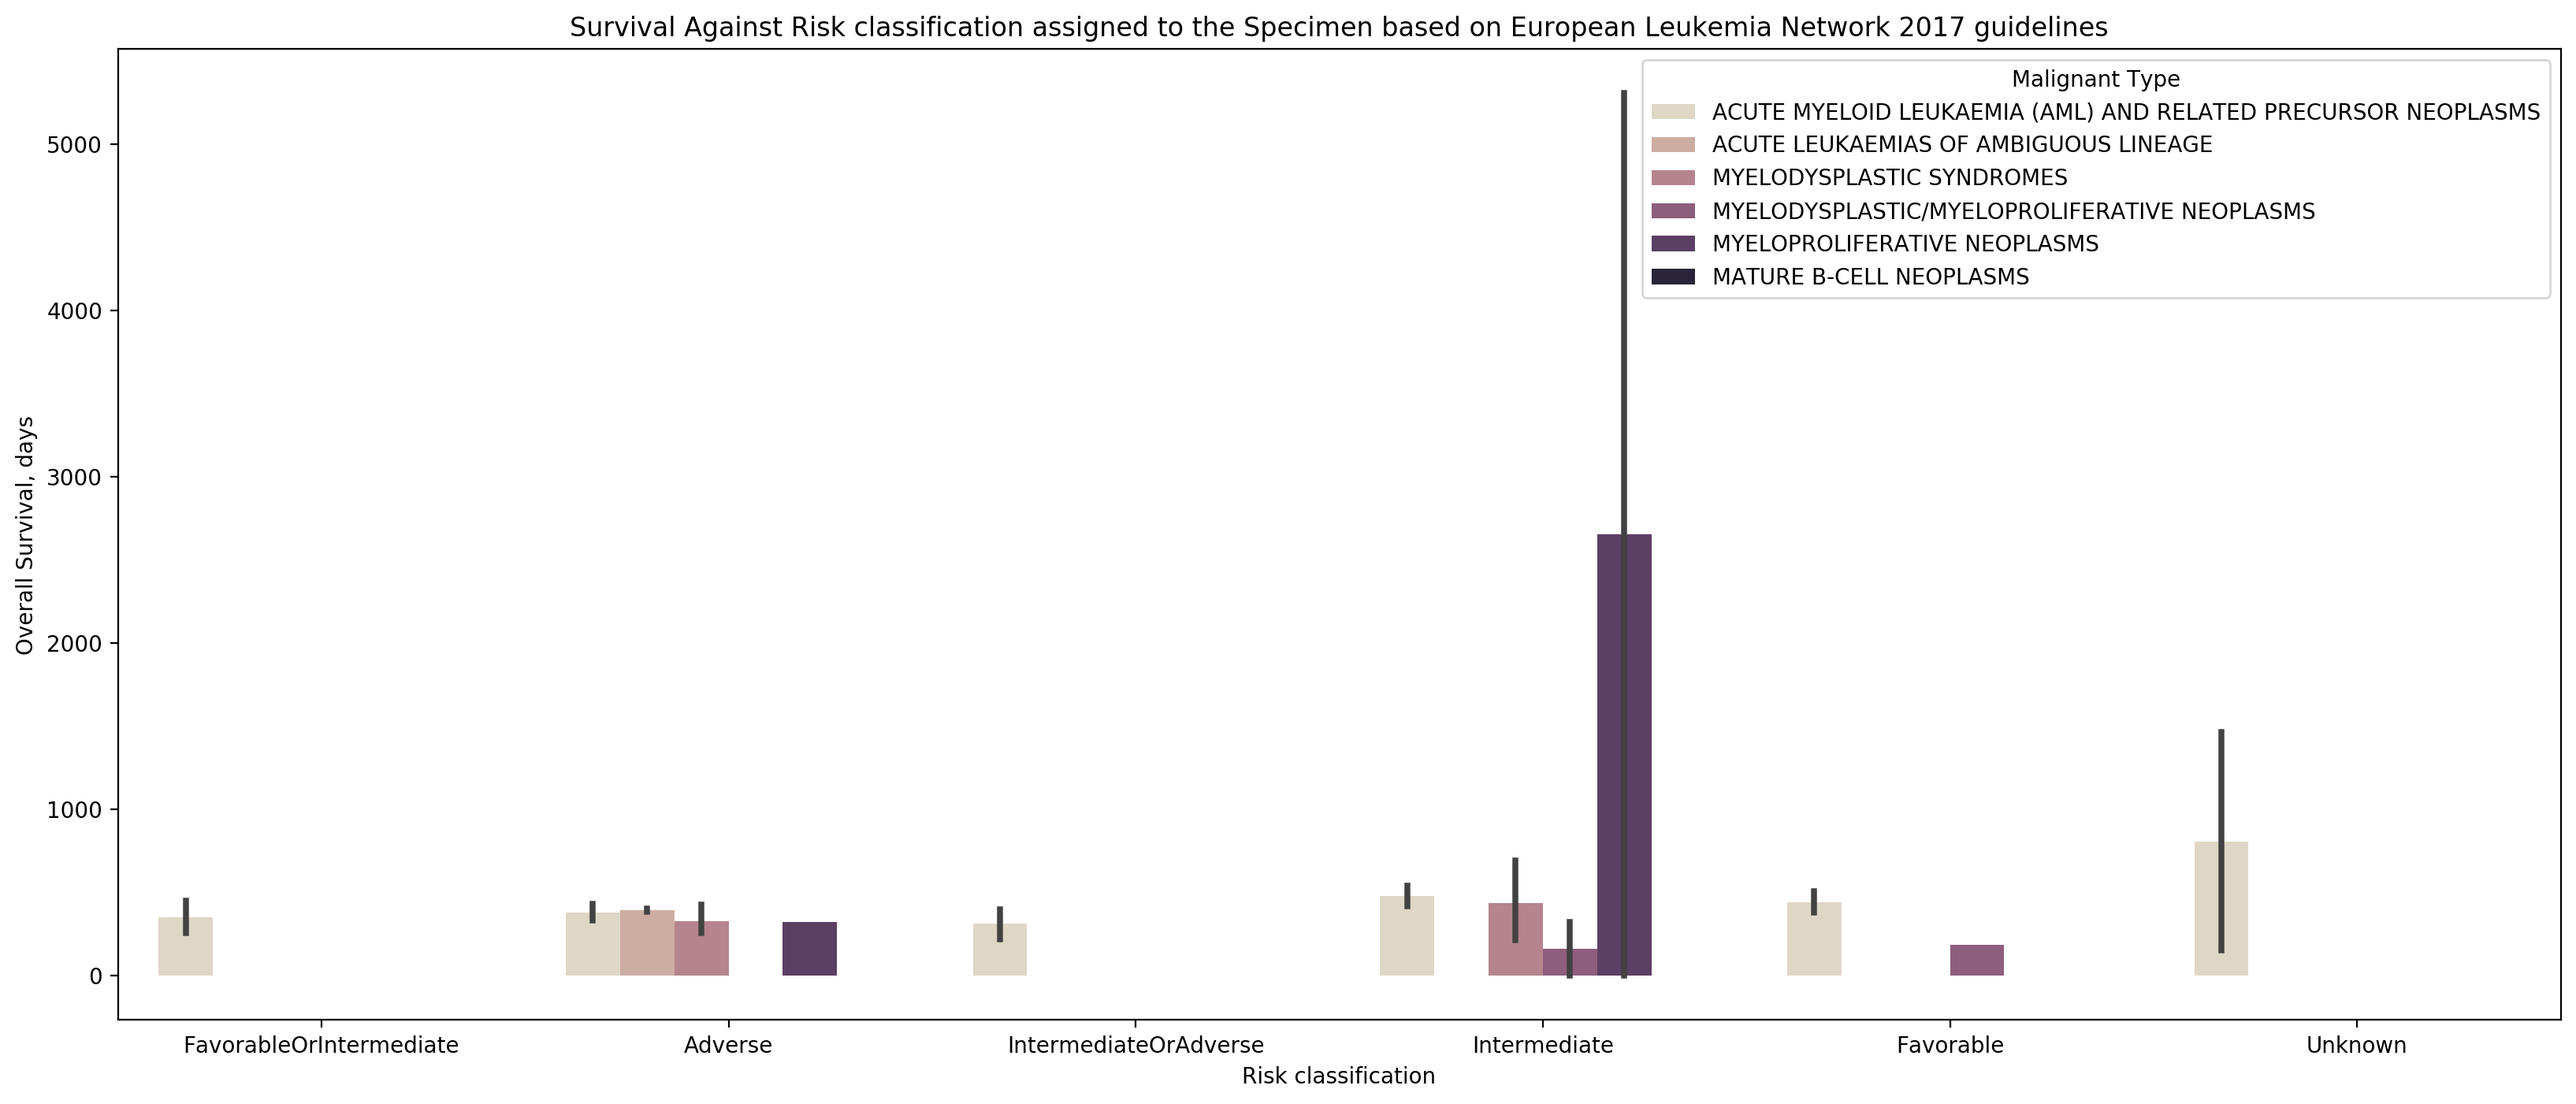

In [85]:
sns.barplot(data= clsm_cut,x = 'ELN2017', y = 'overallSurvival', 
            hue = 'dxAtSpecimenAcquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Risk classification')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Risk classification assigned to the Specimen based on European Leukemia Network 2017 guidelines")

Text(0.5, 1.0, 'Survival Against Prior MDS Diagnosis')

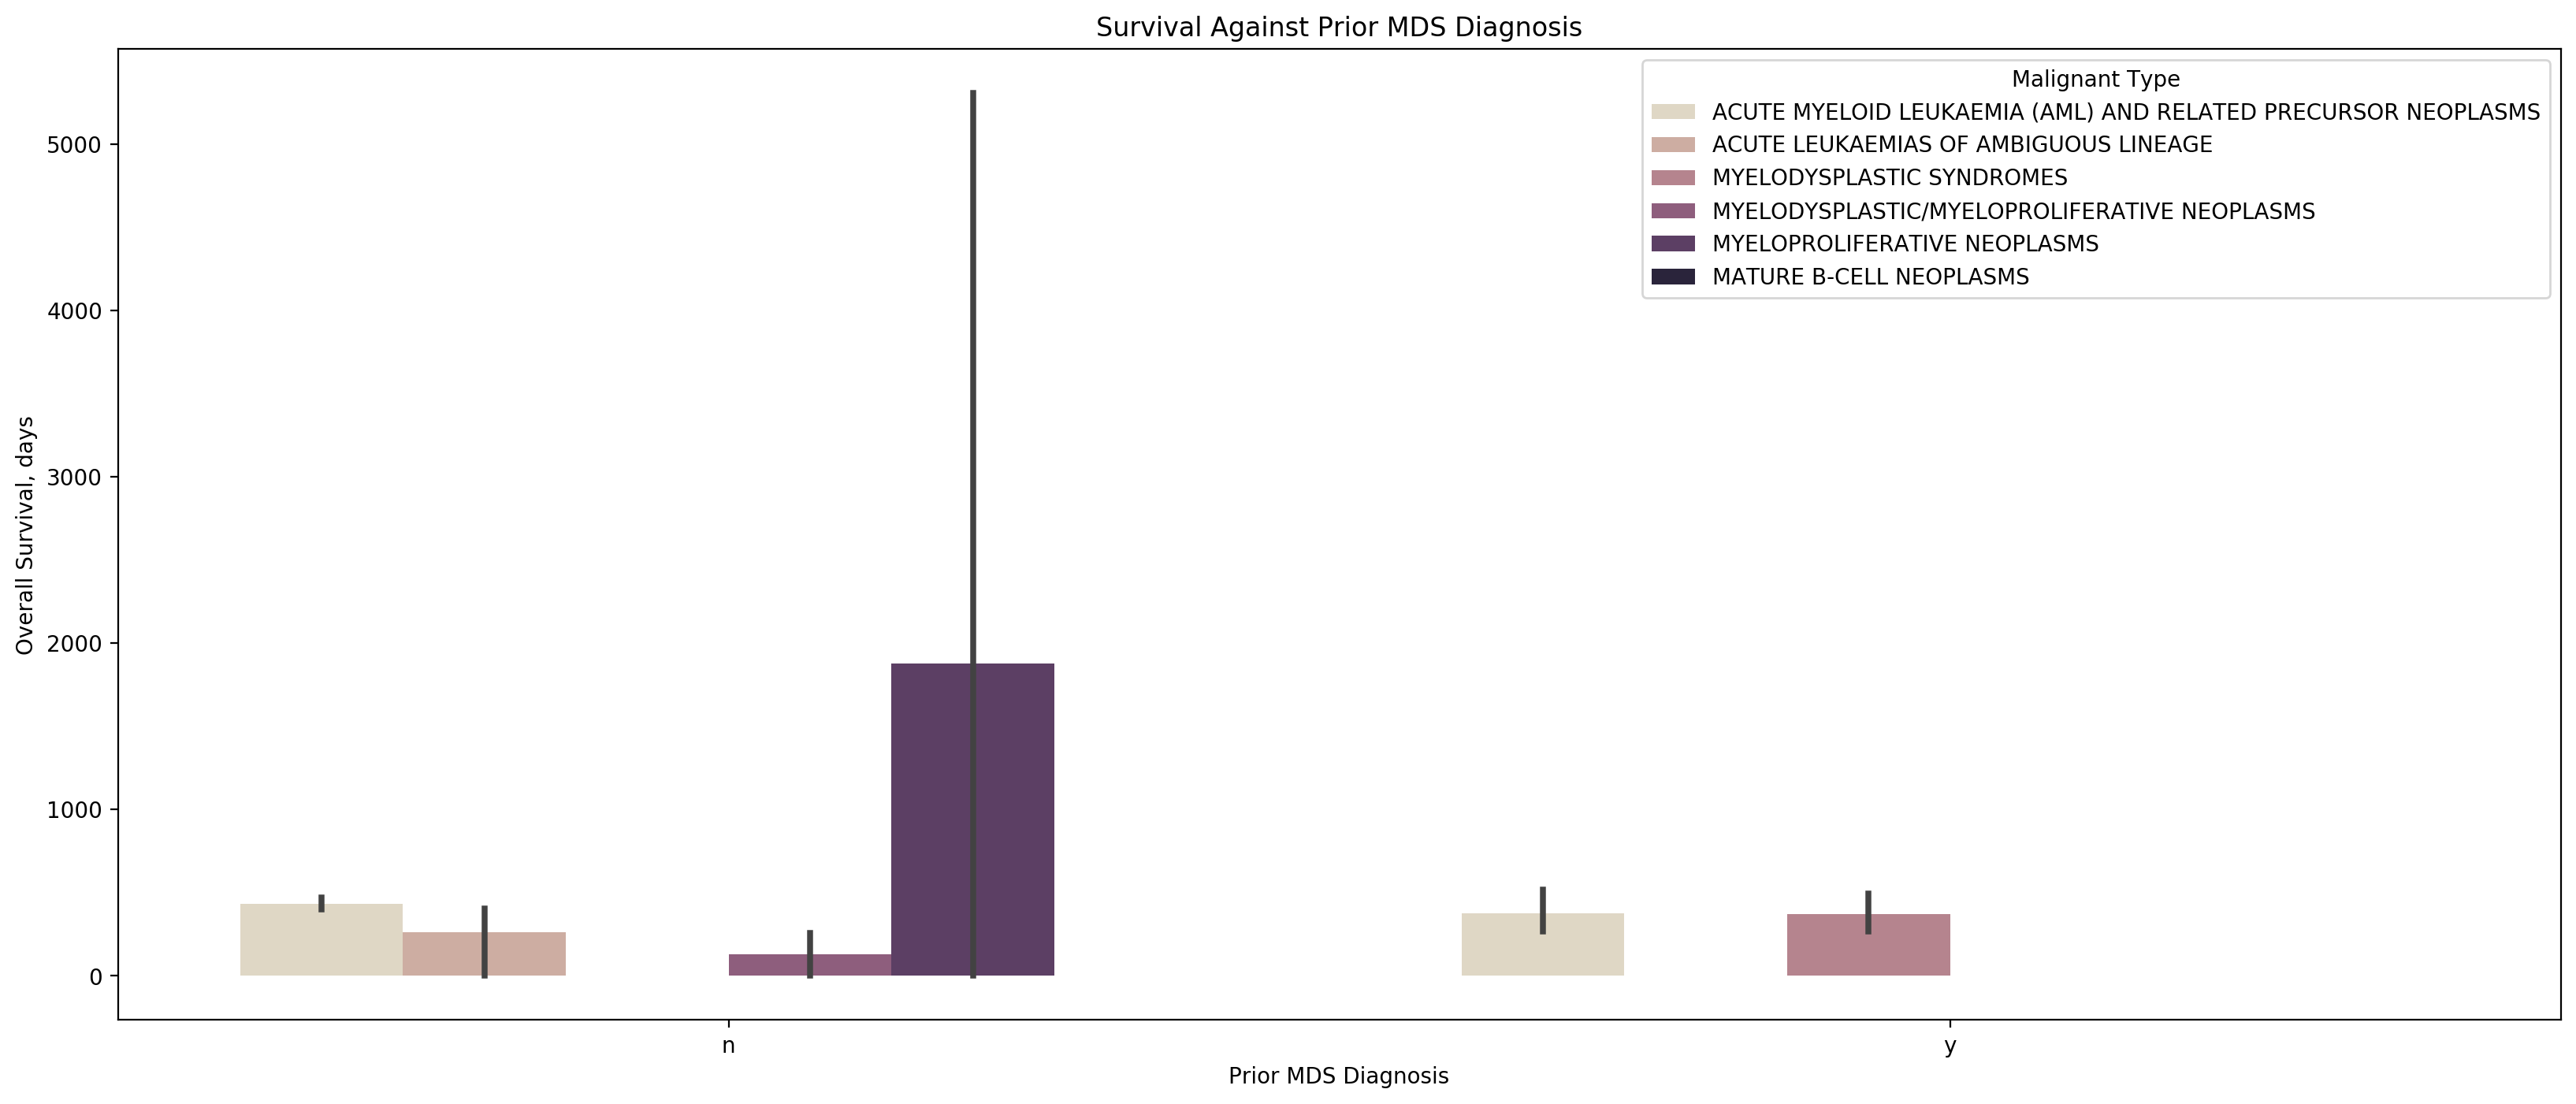

In [86]:
sns.barplot(data= clsm_cut,x = 'priorMDS', y = 'overallSurvival', 
            hue = 'dxAtSpecimenAcquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Prior MDS Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior MDS Diagnosis")

Text(0.5, 1.0, 'Survival Against Prior MDS and MPN Diagnosis')

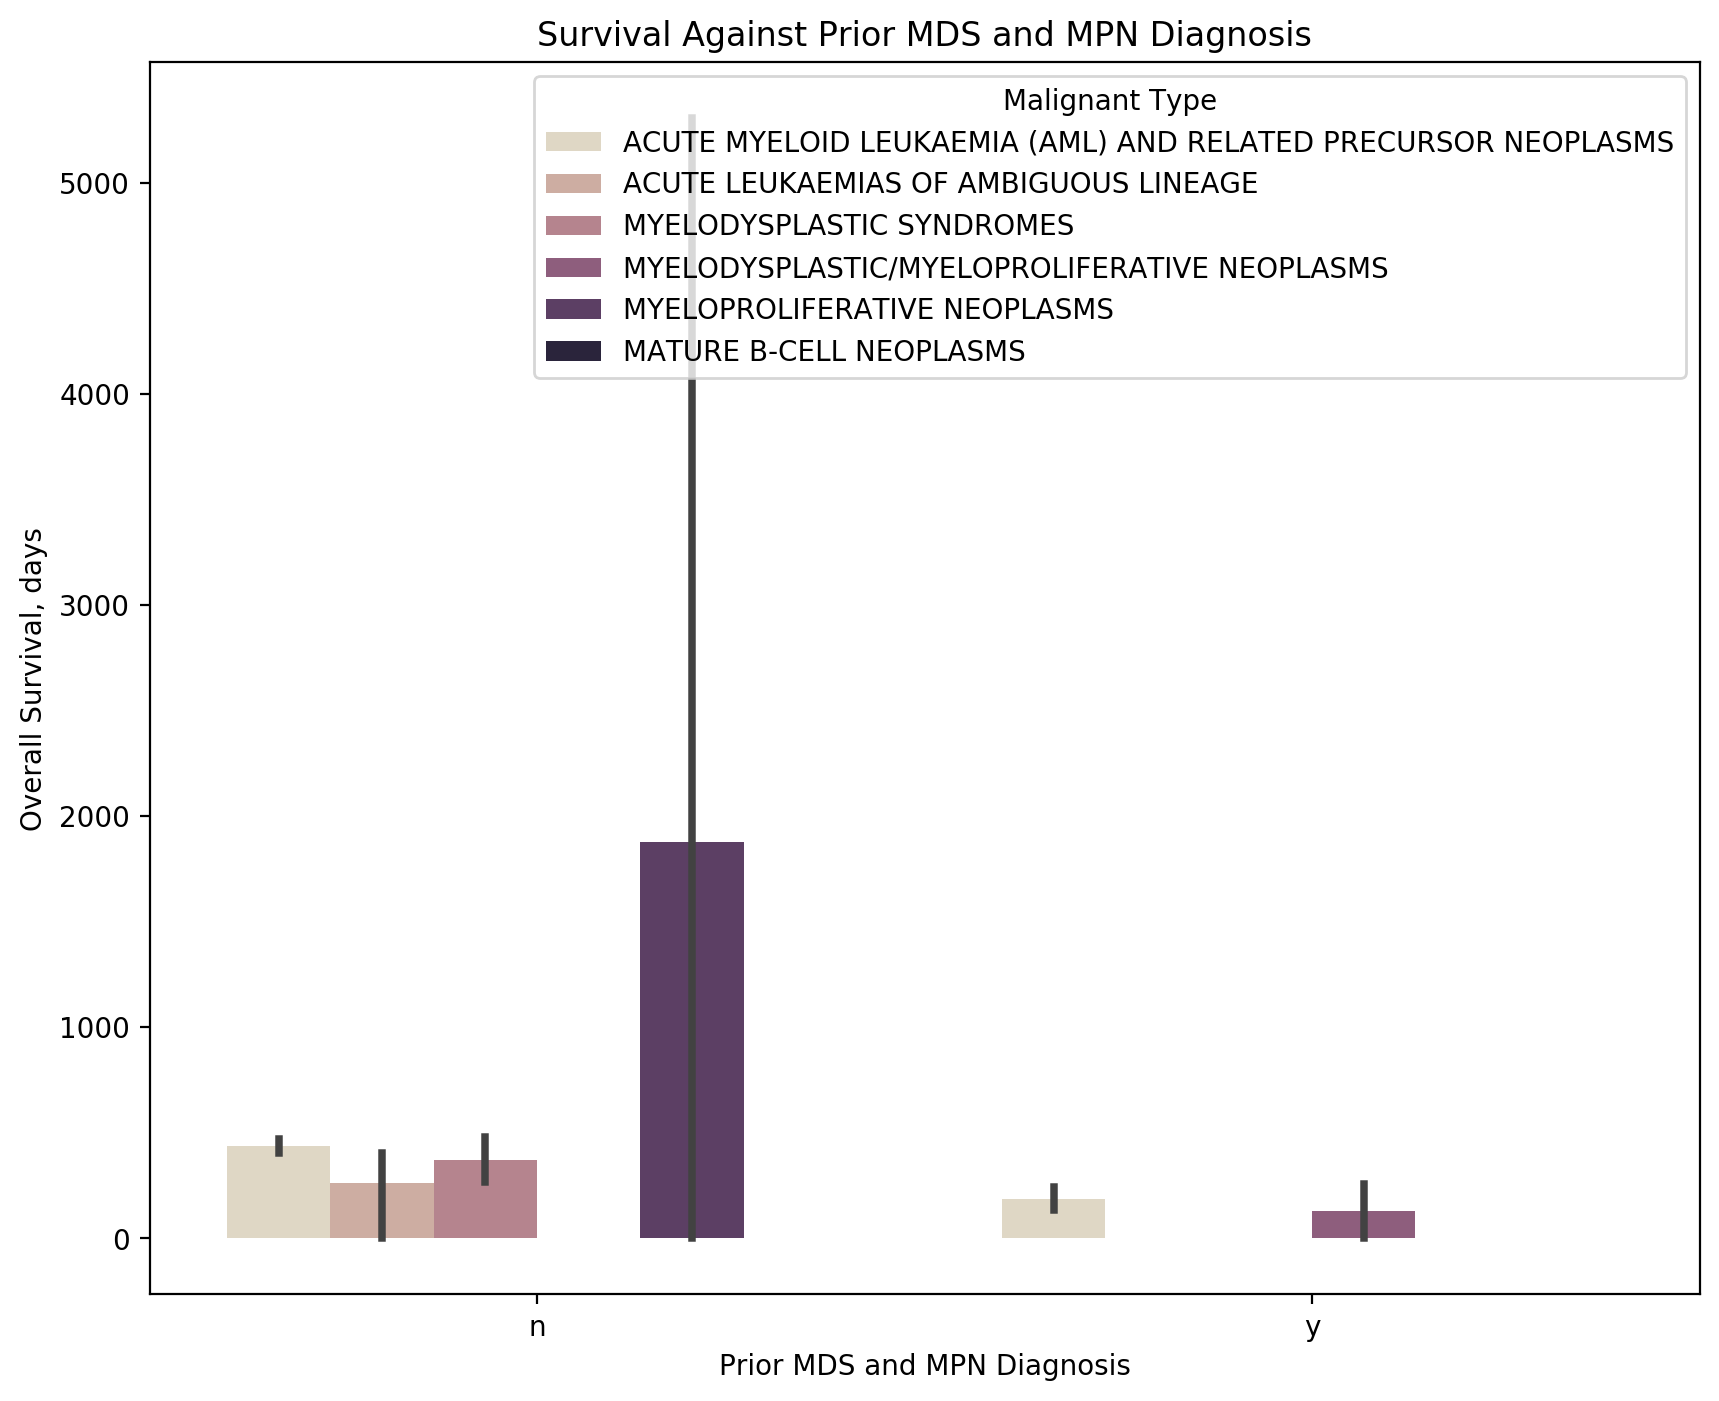

In [87]:
sns.barplot(data= clsm_cut,x = 'priorMDSMPN', y = 'overallSurvival', 
            hue = 'dxAtSpecimenAcquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(10, 8)
plt.xlabel('Prior MDS and MPN Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior MDS and MPN Diagnosis")

Text(0.5, 1.0, 'Survival Against Prior MPN Diagnosis')

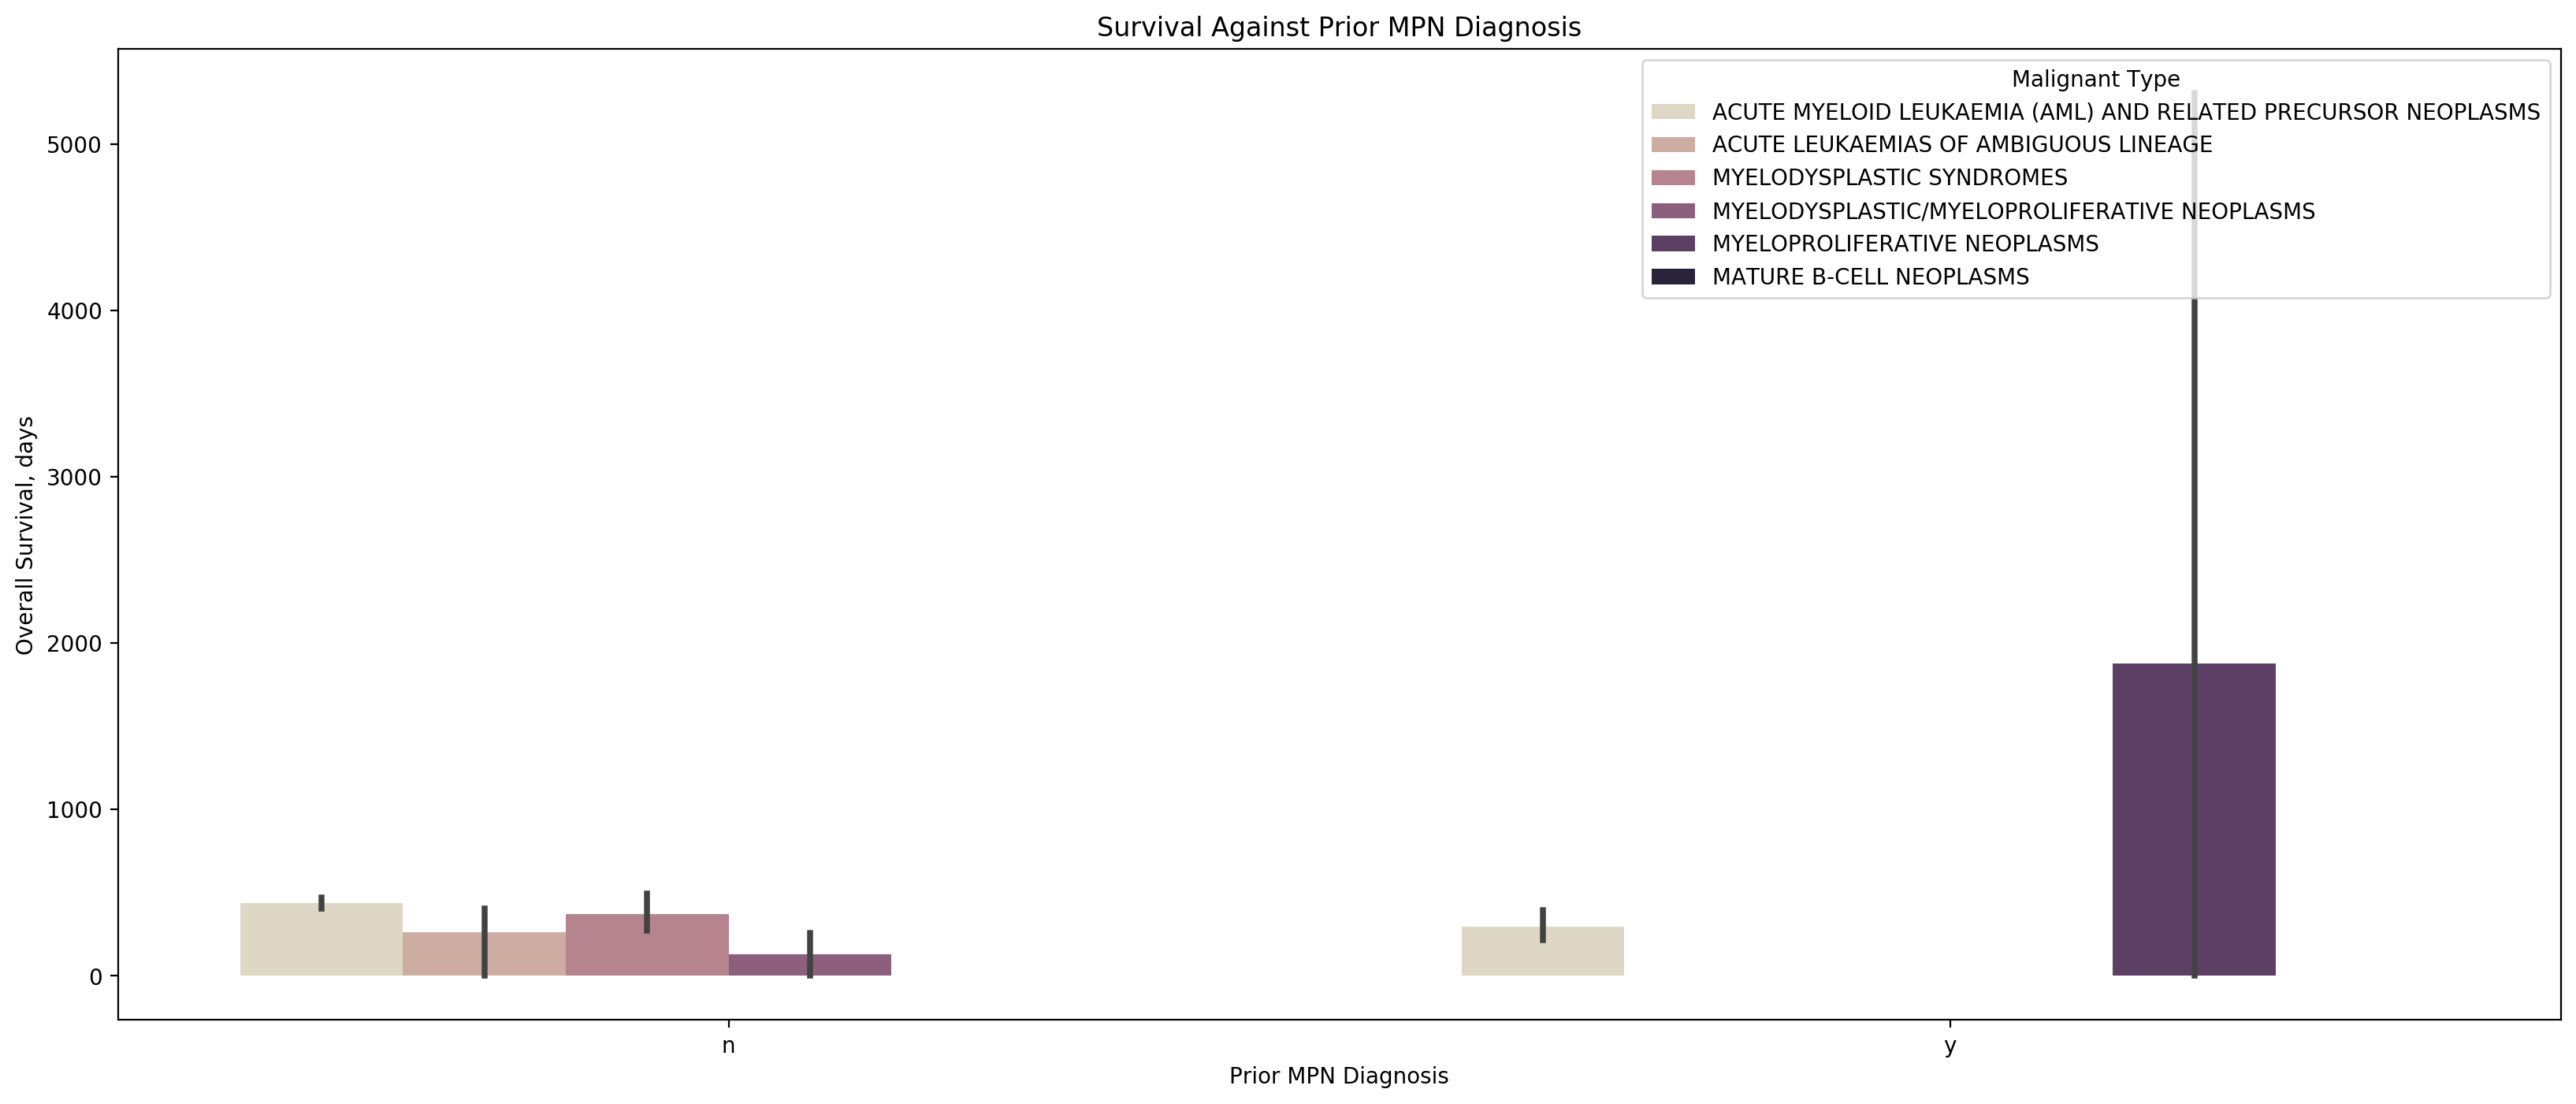

In [88]:
sns.barplot(data= clsm_cut,x = 'priorMPN', y = 'overallSurvival', 
            hue = 'dxAtSpecimenAcquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Prior MPN Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior MPN Diagnosis")

Text(0.5, 1.0, '%Blast in Peripheral Blood against Prior NPM1 Mutation')

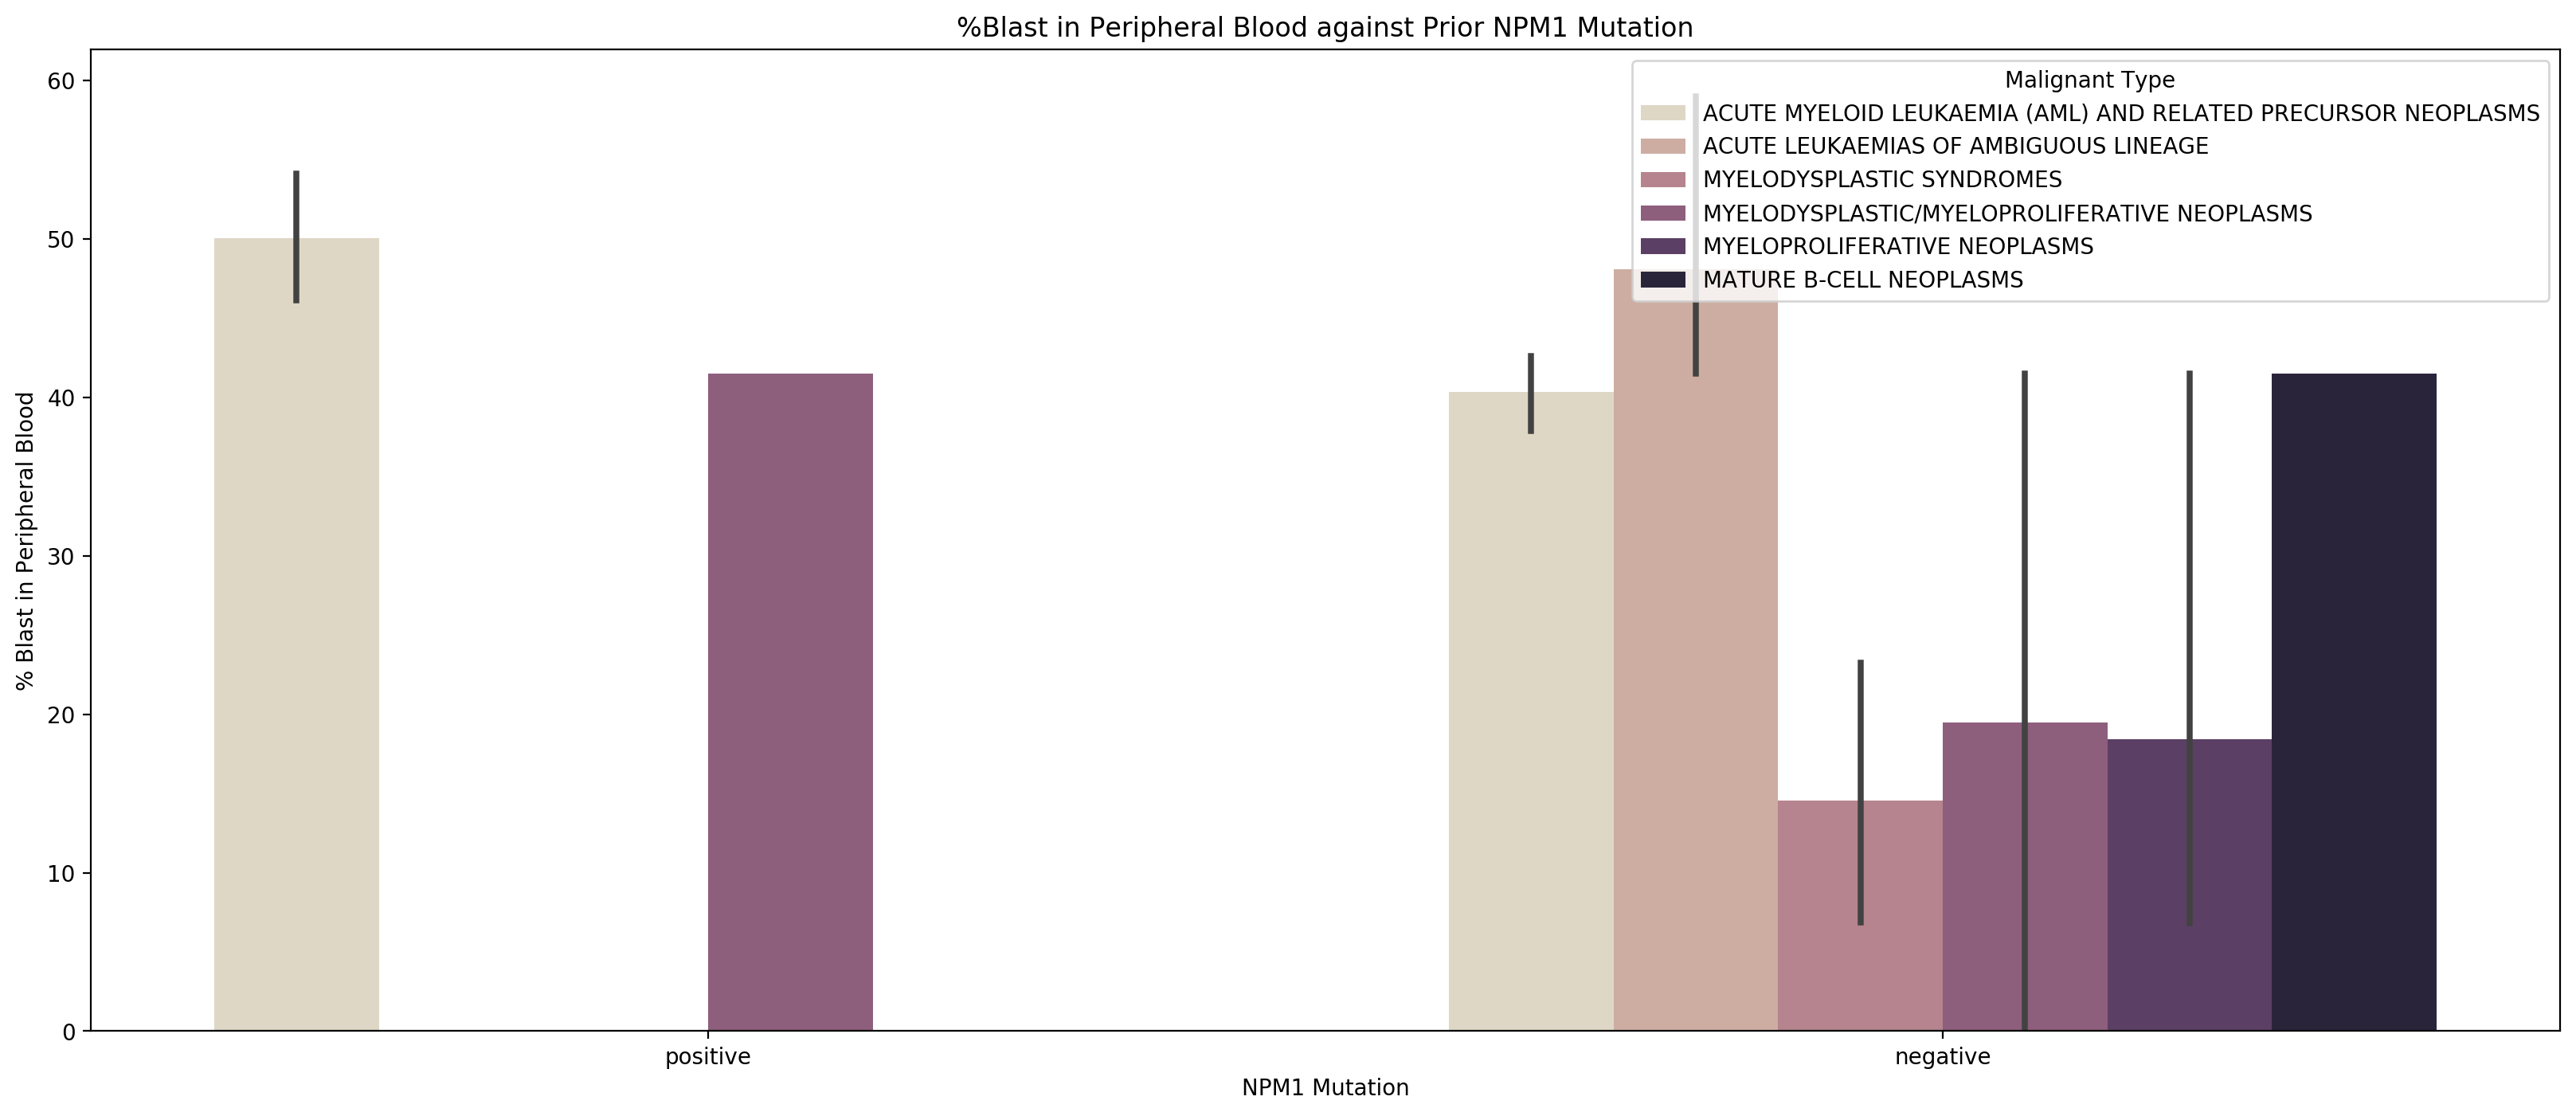

In [89]:
sns.barplot(data= clsm_cut,x = 'NPM1', y = '%.Blasts.in.PB', 
            hue = 'dxAtSpecimenAcquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Peripheral Blood')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("%Blast in Peripheral Blood against Prior NPM1 Mutation")


Text(0.5, 1.0, '%Blast in Bone Marrow Against NPM1 Mutation')

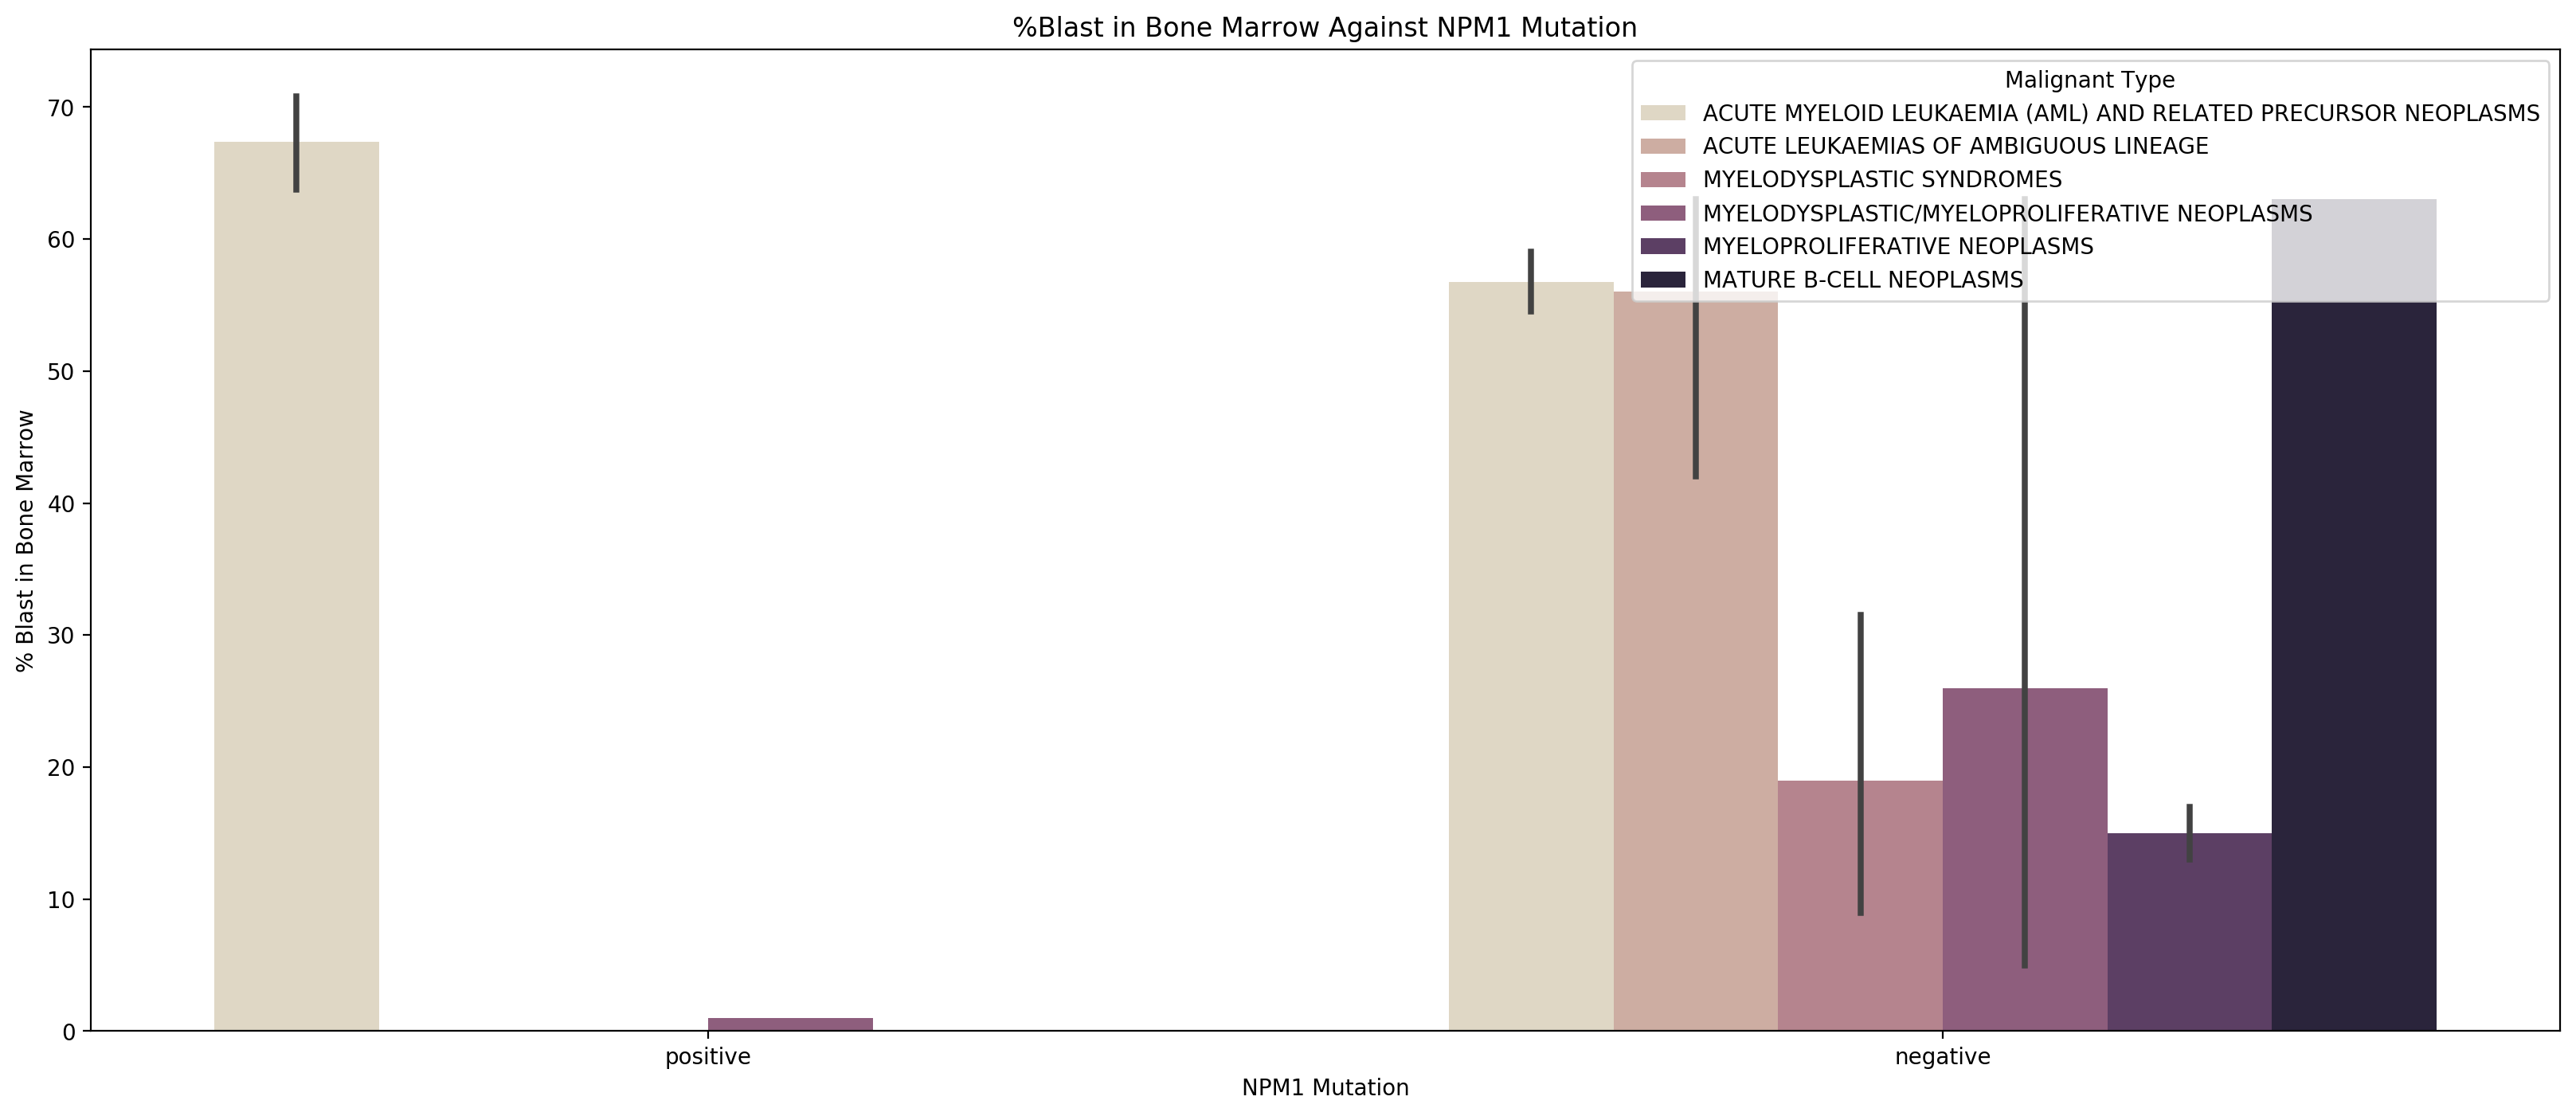

In [90]:
sns.barplot(data= clsm_cut,x = 'NPM1', y = '%.Blasts.in.BM', 
            hue = 'dxAtSpecimenAcquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Bone Marrow')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("%Blast in Bone Marrow Against NPM1 Mutation")

Text(0.5, 1.0, '%Blast in Peripheral Blood against Prior NPM1 Mutation')

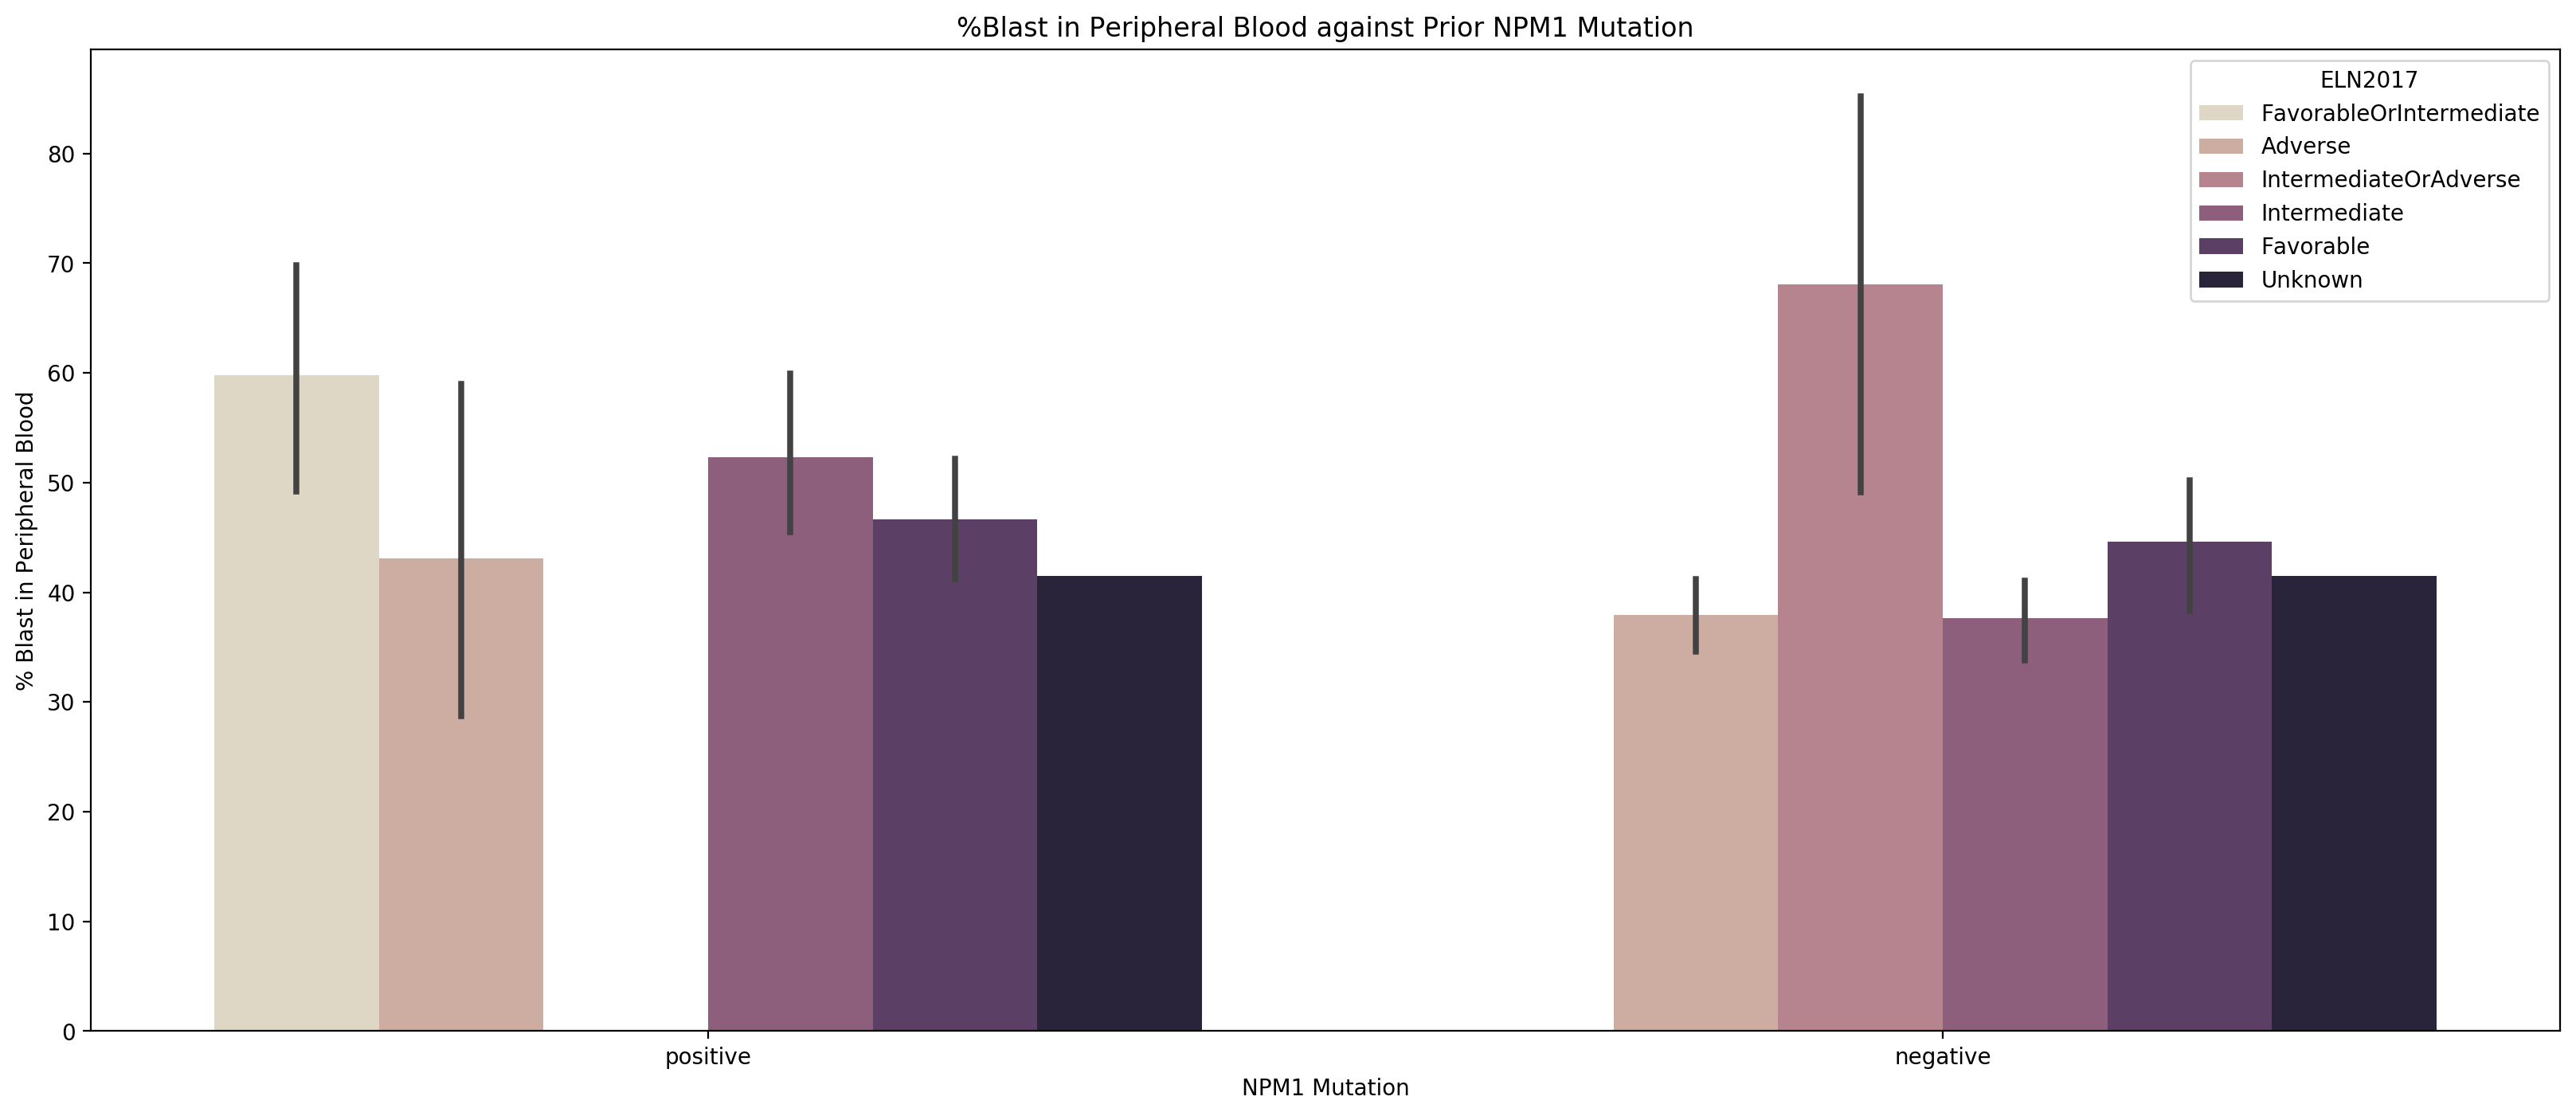

In [91]:
sns.barplot(data= clsm_cut,x = 'NPM1', y = '%.Blasts.in.PB', 
            hue = 'ELN2017', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Peripheral Blood')
plt.legend(loc='upper right', title = 'ELN2017')
plt.title("%Blast in Peripheral Blood against Prior NPM1 Mutation")

Text(0.5, 1.0, '%Blast in Bone Marrow Against NPM1 Mutation')

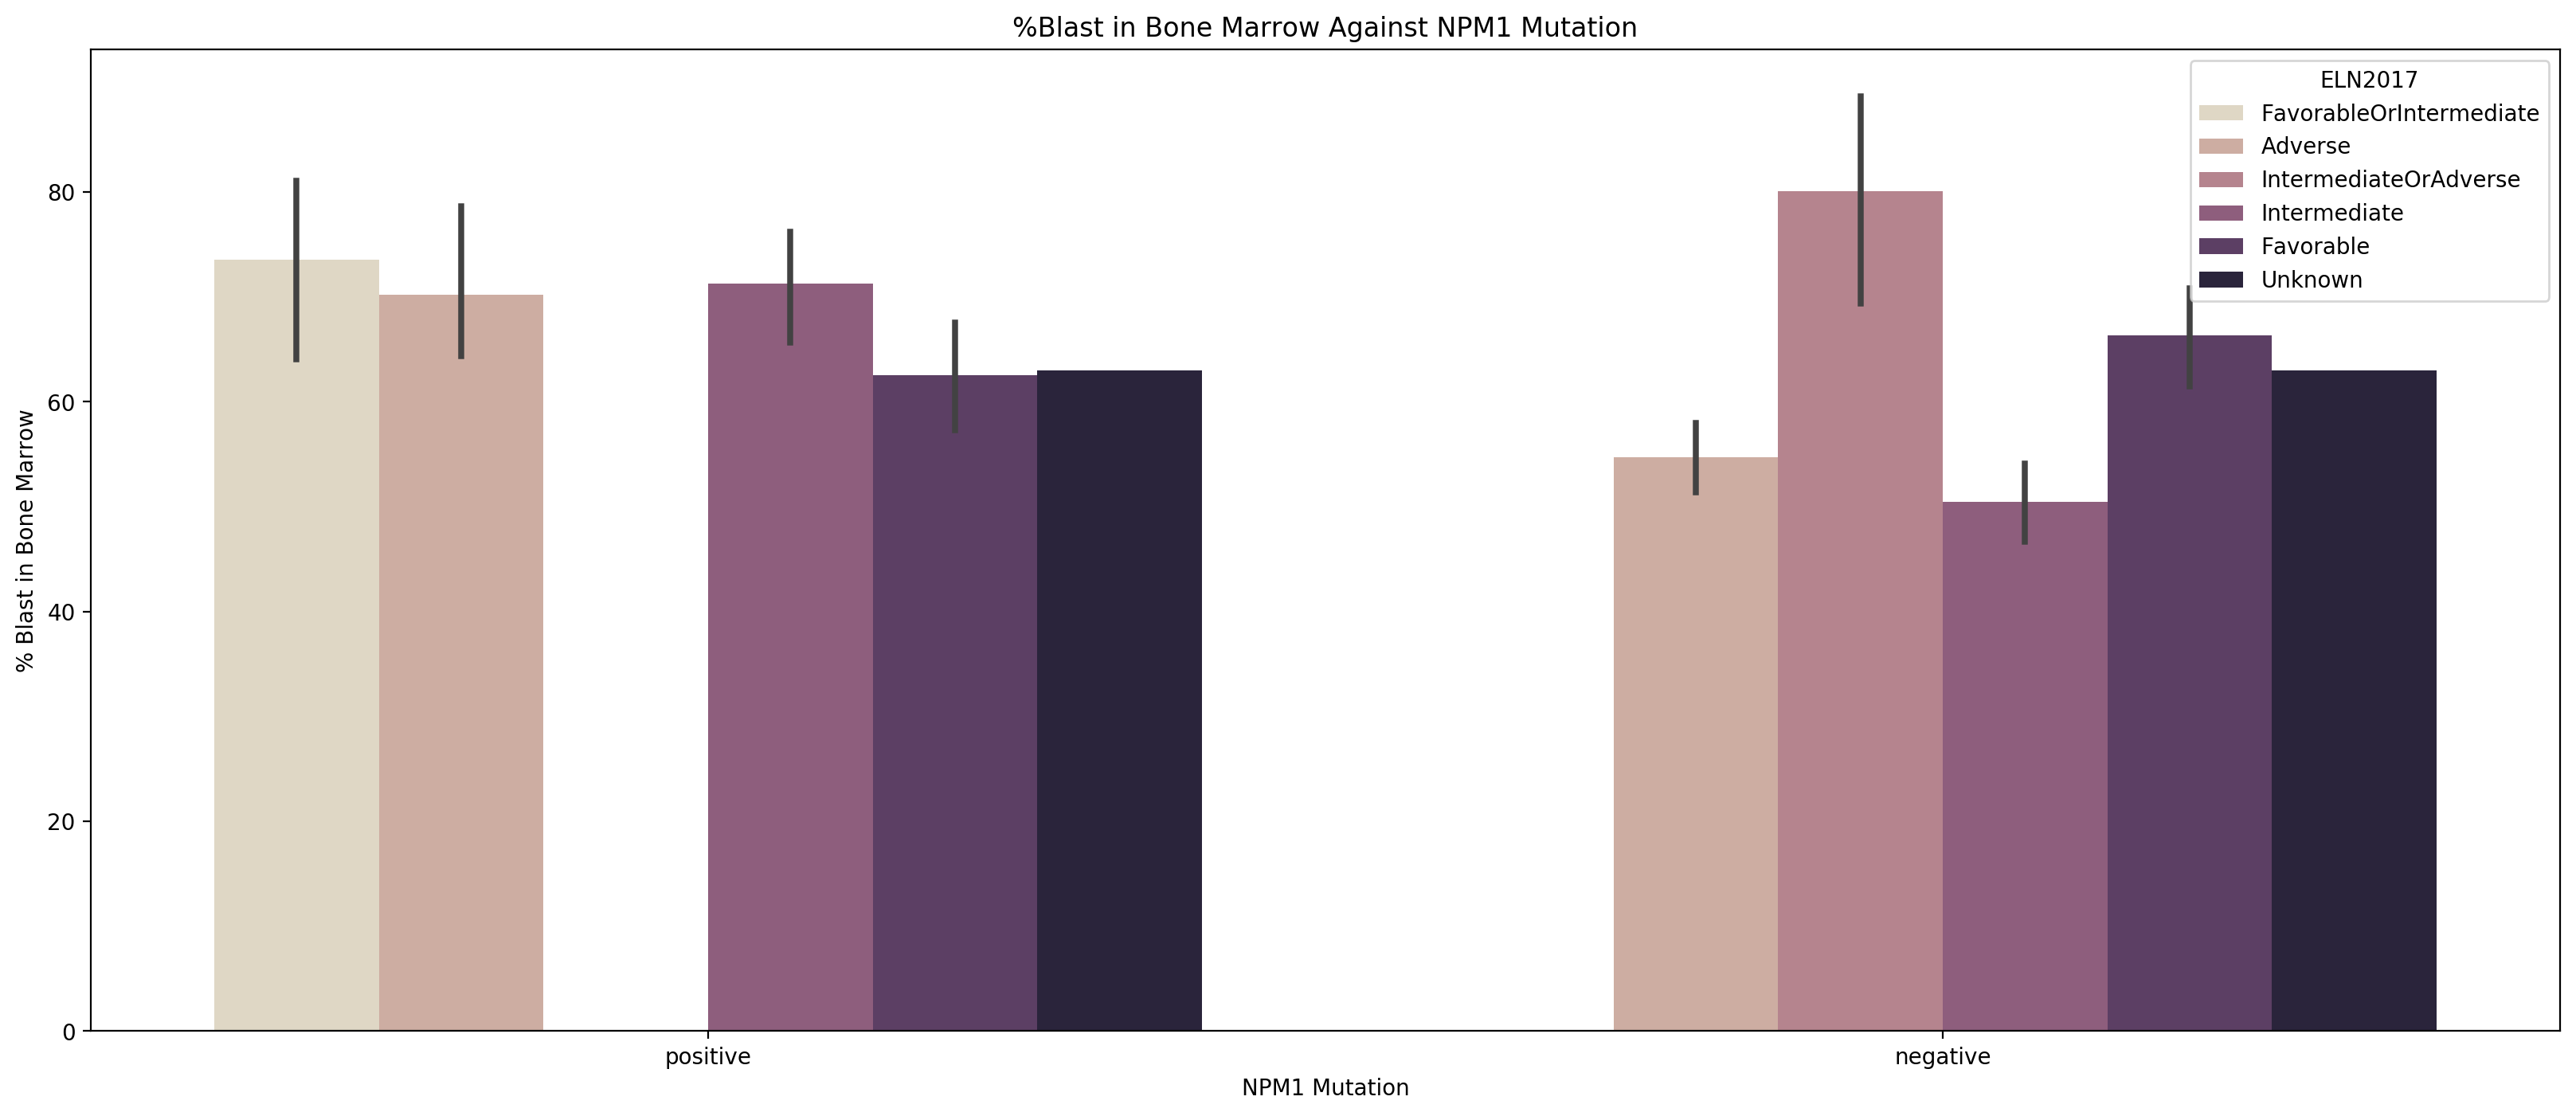

In [92]:
sns.barplot(data= clsm_cut,x = 'NPM1', y = '%.Blasts.in.BM', 
            hue = 'ELN2017', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Bone Marrow')
plt.legend(loc='upper right', title = 'ELN2017')
plt.title("%Blast in Bone Marrow Against NPM1 Mutation")

### Transformation: Final Prep prior to Data Modeling

### Create Target Variable

In [93]:
clsm_cut['dxAtSpecimenAcquisition'].value_counts()

ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PRECURSOR NEOPLASMS    646
MYELODYSPLASTIC SYNDROMES                                         15
MYELODYSPLASTIC/MYELOPROLIFERATIVE NEOPLASMS                       4
ACUTE LEUKAEMIAS OF AMBIGUOUS LINEAGE                              3
MYELOPROLIFERATIVE NEOPLASMS                                       3
MATURE B-CELL NEOPLASMS                                            1
Name: dxAtSpecimenAcquisition, dtype: int64

In [94]:
#create column for AML detected
clsm_cut['AML_detected'] = ['yes' if x == 'ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PRECURSOR NEOPLASMS' else 'no' for x in clsm_cut['dxAtSpecimenAcquisition']]
clsm_cut.head()

LabId  PatientId consensus_sex inferred_ethnicity  isRelapse  \
0  09-00705        163          Male              White      False   
1  10-00136        174          Male              White      False   
2  10-00172        175        Female              White      False   
3  10-00507         45        Female              White      False   
4  10-00542        174          Male              White       True   

   isTransformed priorMalignancyNonMyeloid priorMDS priorMDSMPN priorMPN  \
0          False                         n        n           n        n   
1          False                         n        n           n        n   
2          False                         n        n           n        n   
3          False                         n        n           n        n   
4          False                         n        n           n        n   

                   ELN2017                            dxAtSpecimenAcquisition  \
0  FavorableOrIntermediate  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
1                  Adverse  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
2    IntermediateOrAdverse  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
3  FavorableOrIntermediate  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   
4                  Adverse  ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...   

  vitalStatus  overallSurvival  %.Blasts.in.BM  %.Blasts.in.PB  FLT3-ITD  \
0        Dead            425.0            94.0            97.0  positive   
1        Dead            419.0            80.0            19.0  positive   
2        Dead            541.0            91.0            99.0  positive   
3        Dead            511.0            97.0            97.0  positive   
4        Dead            419.0            87.0            80.0  positive   

       NPM1 AML_detected  
0  positive          yes  
1  negative          yes  
2  negative          yes  
3  positive          yes  
4  negative          yes

In [95]:
clsm_cut['AML_detected'].value_counts()

yes    646
no      26
Name: AML_detected, dtype: int64

### New Dataframe for SageMaker JumpStart Regression Model
#### Transform select categorical attributes to numerical:

In [96]:
#AML_detected
clsm_cut['AML_detected'].replace(['no', 'yes'],
                        [0, 1], inplace=True)
#npm1
clsm_cut['NPM1'].replace(['negative', 'positive'],
                        [0, 1], inplace=True)
#flt3-itd
clsm_cut['FLT3-ITD'].replace(['negative', 'positive'],
                        [0, 1], inplace=True)
#priormalignancynonmyeloid
clsm_cut['priorMalignancyNonMyeloid'].replace(['n', 'y'],
                        [0, 1], inplace=True)
#priormds
clsm_cut['priorMDS'].replace(['n', 'y'],
                        [0, 1], inplace=True)
#priormdsmpn
clsm_cut['priorMDSMPN'].replace(['n', 'y'],
                        [0, 1], inplace=True)
#priormpn
clsm_cut['priorMPN'].replace(['n', 'y'],
                        [0, 1], inplace=True)

In [97]:
#Create new dataframe with transformed attributes and necessary attributes
clsm_cut_transform = pd.DataFrame(clsm_cut[['AML_detected', 'NPM1', 'FLT3-ITD', 'isRelapse', 'isTransformed',
                                'priorMalignancyNonMyeloid', 'priorMDS', 'priorMDSMPN', 'priorMPN',
                                '%.Blasts.in.PB', '%.Blasts.in.BM', 'overallSurvival']])

In [98]:
#Transform data type:
clsm_cut_transform['NPM1'] = clsm_cut['NPM1'].astype(int)
clsm_cut_transform['FLT3-ITD'] = clsm_cut['FLT3-ITD'].astype(int)
clsm_cut_transform['isRelapse'] = clsm_cut['isRelapse'].astype(int)
clsm_cut_transform['isTransformed'] = clsm_cut['isTransformed'].astype(int)

### New Numerical Dataframe Correlation Matrix

In [99]:
clsm_cut_transform.corr()

AML_detected      NPM1  FLT3-ITD  isRelapse  \
AML_detected                   1.000000  0.098997  0.077525   0.054383   
NPM1                           0.098997  1.000000  0.333543   0.140481   
FLT3-ITD                       0.077525  0.333543  1.000000   0.107818   
isRelapse                      0.054383  0.140481  0.107818   1.000000   
isTransformed                  0.089238 -0.148233 -0.092782  -0.072971   
priorMalignancyNonMyeloid     -0.072452 -0.012577 -0.072284  -0.009623   
priorMDS                      -0.291204 -0.177102 -0.127276  -0.060514   
priorMDSMPN                   -0.127707 -0.019763  0.022049  -0.020414   
priorMPN                      -0.057154 -0.059377 -0.054524  -0.037020   
%.Blasts.in.PB                 0.155752  0.174675  0.271851   0.020293   
%.Blasts.in.BM                 0.265724  0.201114  0.242420   0.069284   
overallSurvival               -0.022216 -0.006728 -0.008150   0.210147   

                           isTransformed  priorMalignancyNonMyeloid  \
AML_detected                    0.089238              -7.245182e-02   
NPM1                           -0.148233              -1.257739e-02   
FLT3-ITD                       -0.092782              -7.228395e-02   
isRelapse                      -0.072971              -9.623173e-03   
isTransformed                   1.000000              -5.562376e-02   
priorMalignancyNonMyeloid      -0.055624               1.000000e+00   
priorMDS                        0.620018              -1.056121e-17   
priorMDSMPN                     0.346275              -9.820928e-03   
priorMPN                        0.472862              -1.913898e-02   
%.Blasts.in.PB                 -0.141930               2.215108e-02   
%.Blasts.in.BM                 -0.128224              -5.402601e-02   
overallSurvival                -0.113017              -4.893419e-02   

                               priorMDS  priorMDSMPN  priorMPN  \
AML_detected              -2.912038e-01    -0.127707 -0.057154   
NPM1                      -1.771024e-01    -0.019763 -0.059377   
FLT3-ITD                  -1.272762e-01     0.022049 -0.054524   
isRelapse                 -6.051426e-02    -0.020414 -0.037020   
isTransformed              6.200179e-01     0.346275  0.472862   
priorMalignancyNonMyeloid -1.056121e-17    -0.009821 -0.019139   
priorMDS                   1.000000e+00    -0.044057 -0.042272   
priorMDSMPN               -4.405654e-02     1.000000 -0.045111   
priorMPN                  -4.227151e-02    -0.045111  1.000000   
%.Blasts.in.PB            -1.739113e-01    -0.103580 -0.061838   
%.Blasts.in.BM            -2.015171e-01    -0.087142 -0.105951   
overallSurvival           -4.466673e-02    -0.106423 -0.000754   

                           %.Blasts.in.PB  %.Blasts.in.BM  overallSurvival  
AML_detected                     0.155752        0.265724        -0.022216  
NPM1                             0.174675        0.201114        -0.006728  
FLT3-ITD                         0.271851        0.242420        -0.008150  
isRelapse                        0.020293        0.069284         0.210147  
isTransformed                   -0.141930       -0.128224        -0.113017  
priorMalignancyNonMyeloid        0.022151       -0.054026        -0.048934  
priorMDS                        -0.173911       -0.201517        -0.044667  
priorMDSMPN                     -0.103580       -0.087142        -0.106423  
priorMPN                        -0.061838       -0.105951        -0.000754  
%.Blasts.in.PB                   1.000000        0.563923        -0.059324  
%.Blasts.in.BM                   0.563923        1.000000        -0.048439  
overallSurvival                 -0.059324       -0.048439         1.000000

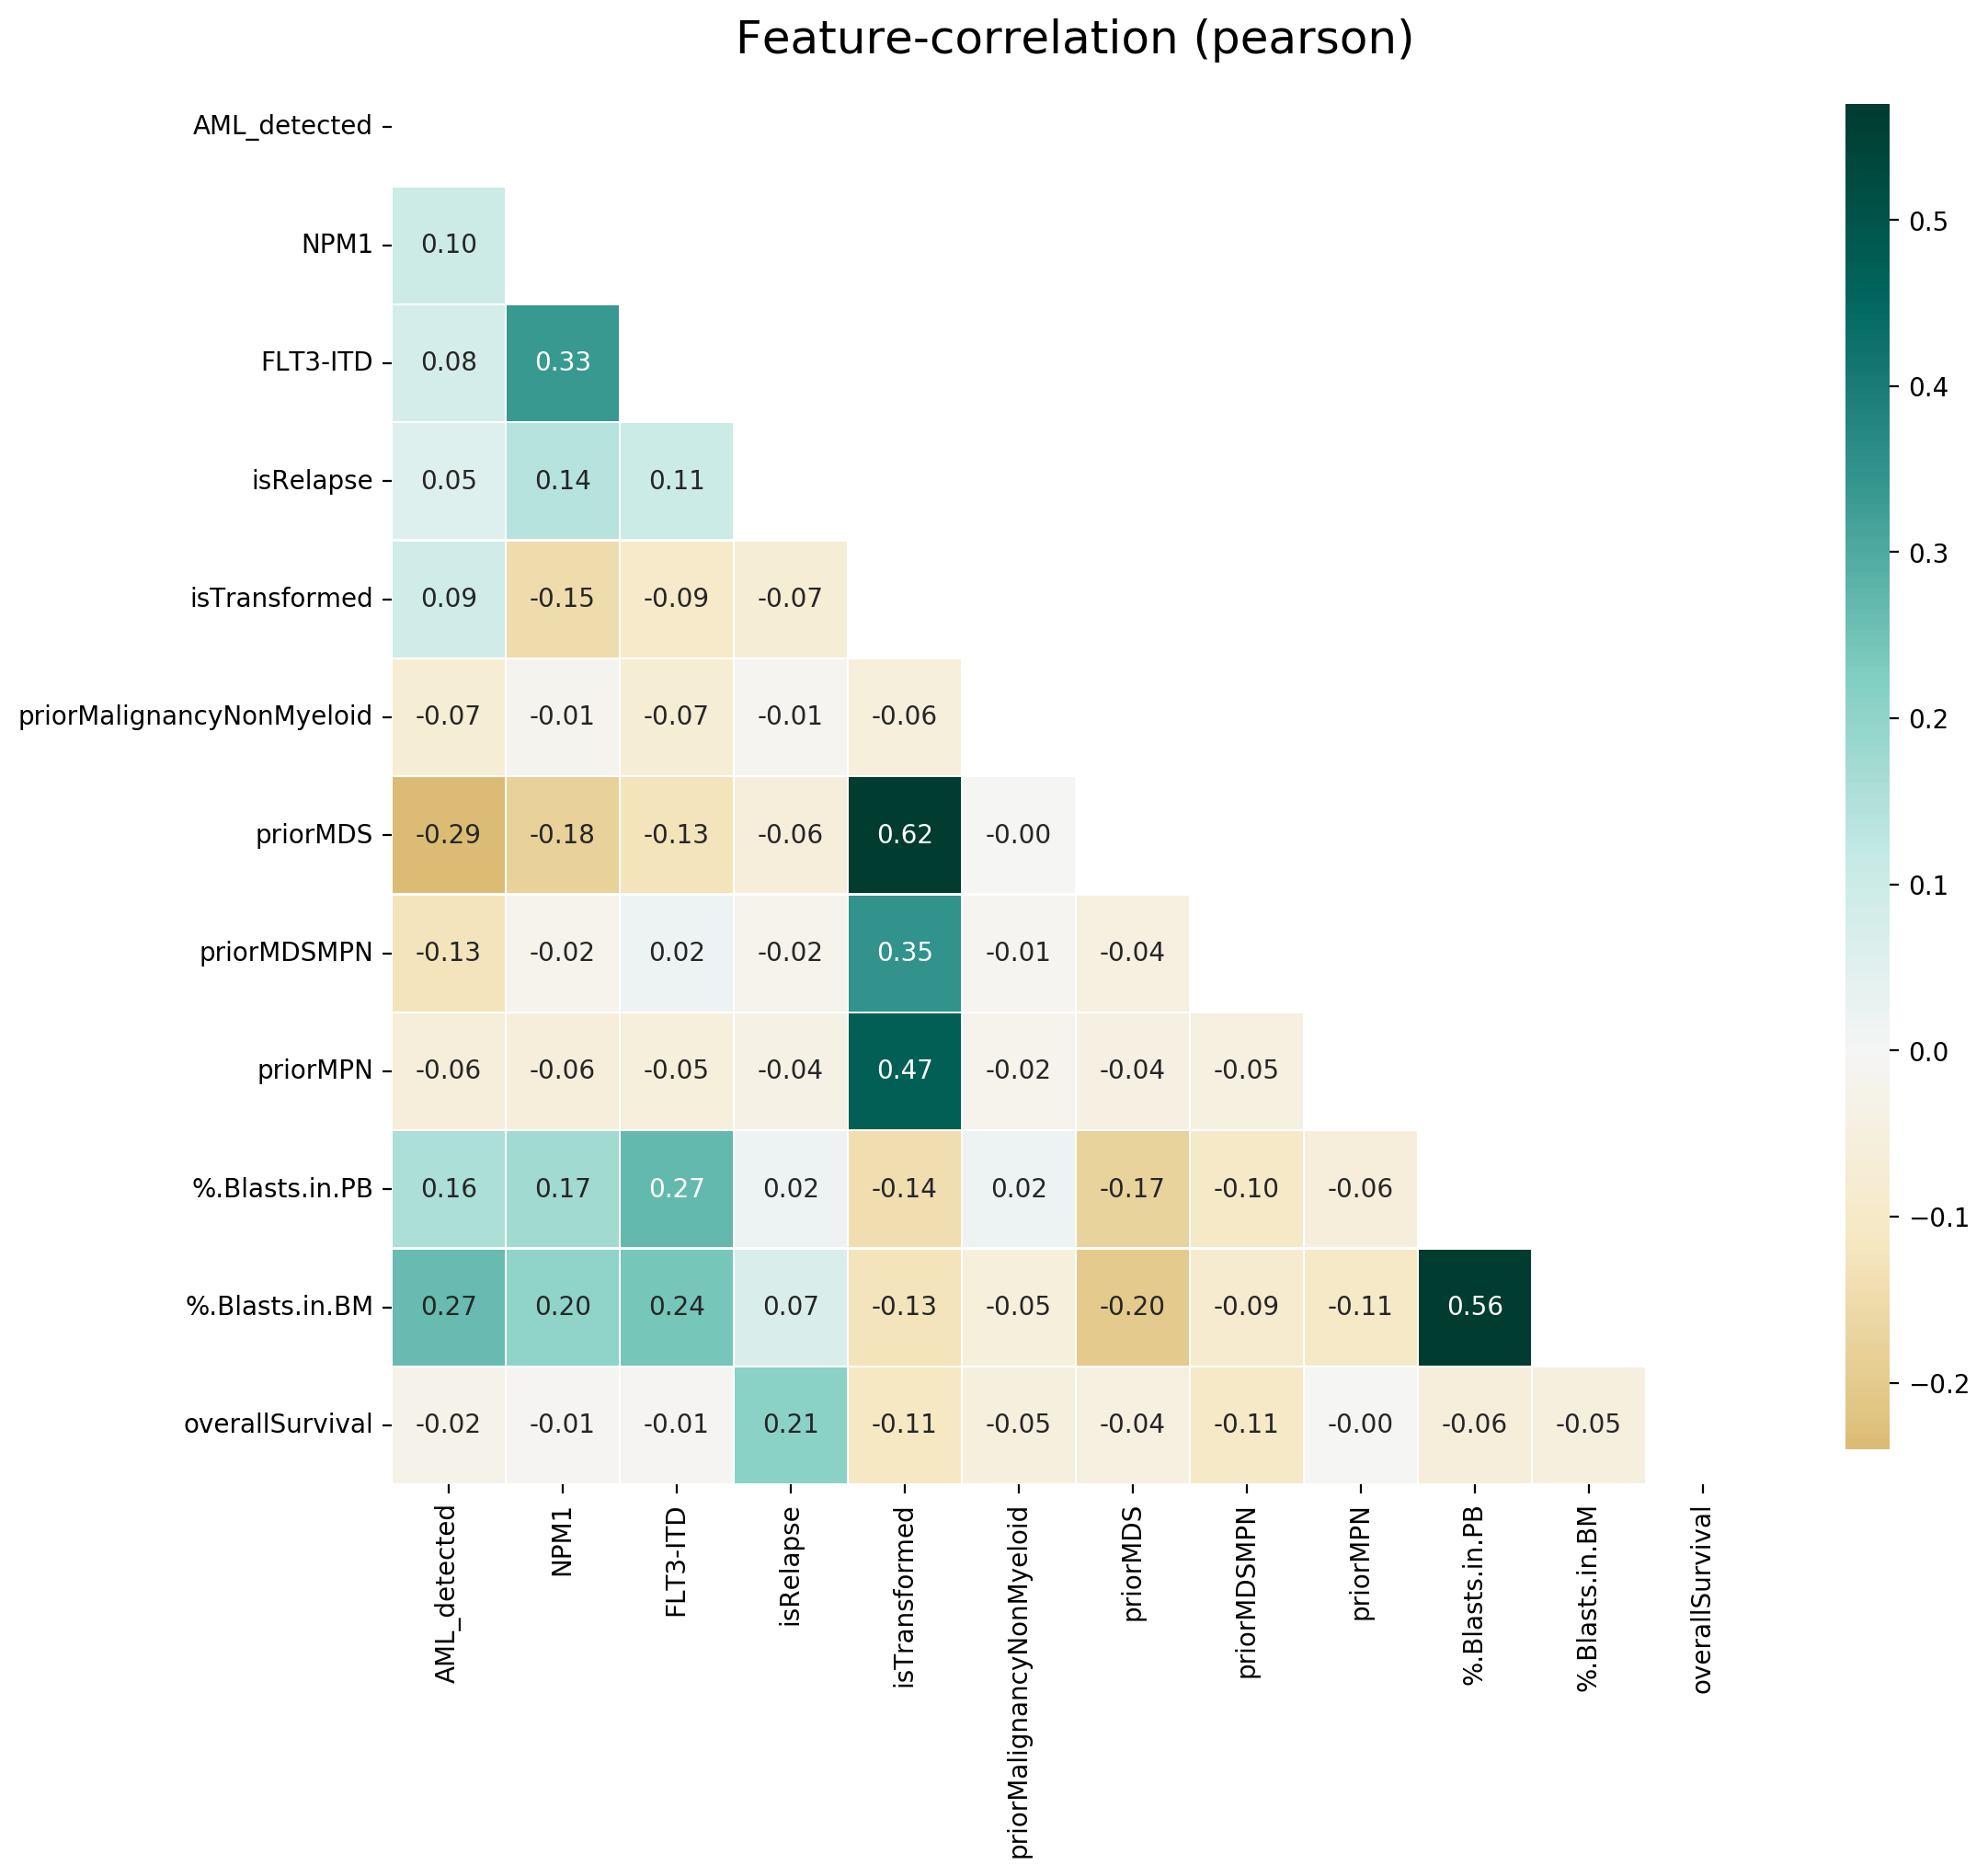

In [100]:
klib.corr_plot(clsm_cut_transform)

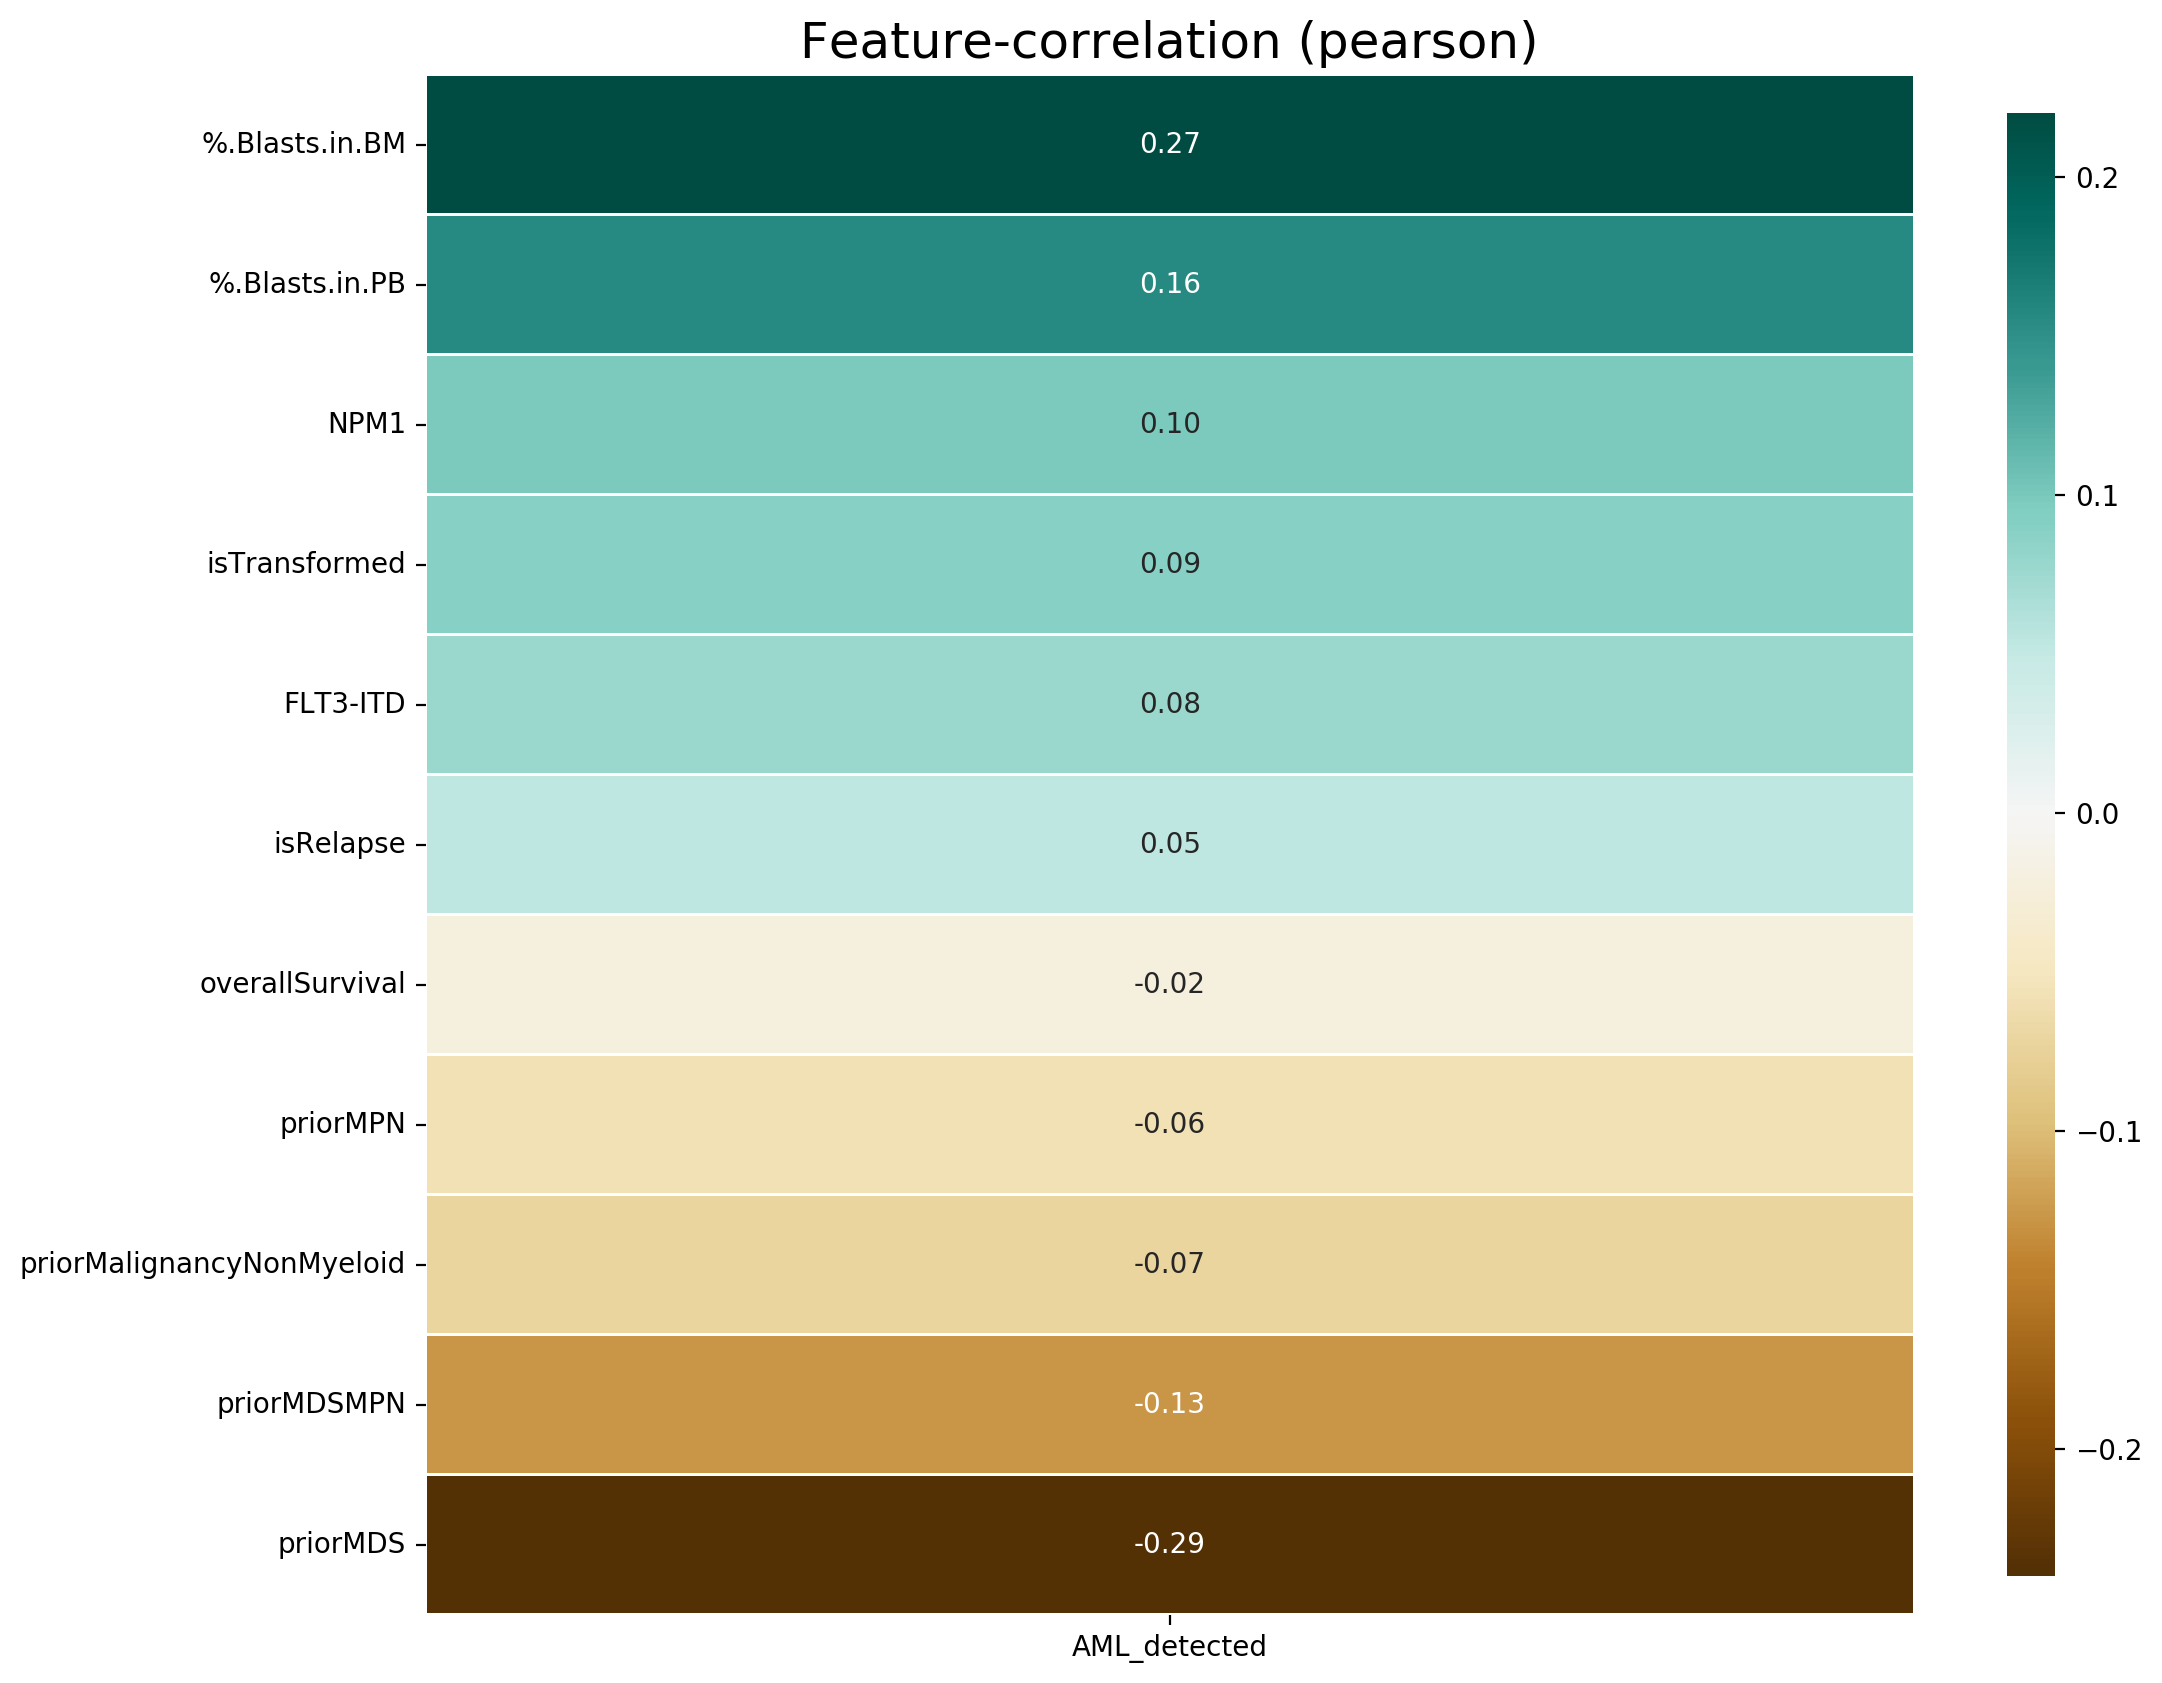

In [101]:
klib.corr_plot(clsm_cut_transform, target='AML_detected')

## One-Hot Encoding

In [102]:
clsm_t = pd.get_dummies(clsm_cut_transform, columns= ['NPM1', 'FLT3-ITD', 'priorMalignancyNonMyeloid', 
                                                    'priorMDS', 'priorMDSMPN', 'priorMPN', 'isRelapse', 
                                                    'isTransformed'])

In [103]:
clsm_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AML_detected                 672 non-null    int64  
 1   %.Blasts.in.PB               672 non-null    float64
 2   %.Blasts.in.BM               672 non-null    float64
 3   overallSurvival              672 non-null    float64
 4   NPM1_0                       672 non-null    uint8  
 5   NPM1_1                       672 non-null    uint8  
 6   FLT3-ITD_0                   672 non-null    uint8  
 7   FLT3-ITD_1                   672 non-null    uint8  
 8   priorMalignancyNonMyeloid_0  672 non-null    uint8  
 9   priorMalignancyNonMyeloid_1  672 non-null    uint8  
 10  priorMDS_0                   672 non-null    uint8  
 11  priorMDS_1                   672 non-null    uint8  
 12  priorMDSMPN_0                672 non-null    uint8  
 13  priorMDSMPN_1       

In [104]:
clsm_t.head()

AML_detected  %.Blasts.in.PB  %.Blasts.in.BM  overallSurvival  NPM1_0  \
0             1            97.0            94.0            425.0       0   
1             1            19.0            80.0            419.0       1   
2             1            99.0            91.0            541.0       1   
3             1            97.0            97.0            511.0       0   
4             1            80.0            87.0            419.0       1   

   NPM1_1  FLT3-ITD_0  FLT3-ITD_1  priorMalignancyNonMyeloid_0  \
0       1           0           1                            1   
1       0           0           1                            1   
2       0           0           1                            1   
3       1           0           1                            1   
4       0           0           1                            1   

   priorMalignancyNonMyeloid_1  priorMDS_0  priorMDS_1  priorMDSMPN_0  \
0                            0           1           0              1   
1                            0           1           0              1   
2                            0           1           0              1   
3                            0           1           0              1   
4                            0           1           0              1   

   priorMDSMPN_1  priorMPN_0  priorMPN_1  isRelapse_0  isRelapse_1  \
0              0           1           0            1            0   
1              0           1           0            1            0   
2              0           1           0            1            0   
3              0           1           0            1            0   
4              0           1           0            0            1   

   isTransformed_0  isTransformed_1  
0                1                0  
1                1                0  
2                1                0  
3                1                0  
4                1                0

In [105]:
clsm_t = clsm_t.rename(columns={ '%.Blasts.in.PB': 'Feature_1', '%.Blasts.in.BM': 'Feature_2', 
                                           'overallSurvival': 'Feature_3', 
                                            'NPM1_0': 'Feature_4', 'NPM1_1': 'Feature_5', 
                                           'FLT3-ITD_0': 'Feature_6', 'FLT3-ITD_1': 'Feature_7', 
                                            'priorMalignancyNonMyeloid_0': 'Feature_8', 'priorMalignancyNonMyeloid_1': 'Feature_9', 
                                            'priorMDS_0': 'Feature_10', 'priorMDS_1': 'Feature_11', 
                                           'priorMDSMPN_0': 'Feature_12', 'priorMDSMPN_1': 'Feature_13', 
                                            'priorMPN_0': 'Feature_14', 'priorMPN_1': 'Feature_15', 
                                            'isRelapse_0': 'Feature_16', 'isRelapse_1': 'Feature_17', 
                                           'isTransformed_0': 'Feature_18', 'isTransformed_1': 'Feature_19' })

In [106]:
clsm_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AML_detected  672 non-null    int64  
 1   Feature_1     672 non-null    float64
 2   Feature_2     672 non-null    float64
 3   Feature_3     672 non-null    float64
 4   Feature_4     672 non-null    uint8  
 5   Feature_5     672 non-null    uint8  
 6   Feature_6     672 non-null    uint8  
 7   Feature_7     672 non-null    uint8  
 8   Feature_8     672 non-null    uint8  
 9   Feature_9     672 non-null    uint8  
 10  Feature_10    672 non-null    uint8  
 11  Feature_11    672 non-null    uint8  
 12  Feature_12    672 non-null    uint8  
 13  Feature_13    672 non-null    uint8  
 14  Feature_14    672 non-null    uint8  
 15  Feature_15    672 non-null    uint8  
 16  Feature_16    672 non-null    uint8  
 17  Feature_17    672 non-null    uint8  
 18  Feature_18    672 non-null    

## Save New Pre-Processed clsm Dataframe to S3

In [107]:
clsm_t.to_csv('clsm_t.csv')

In [108]:
#Manually upload into S3
!aws s3 ls s3://ads508rawdatasets/CSV/

                           PRE OHSU_BeatAML_ClinicalSummary/
                           PRE OpenCell_ProteinInteraction/
2023-03-27 03:13:15          0 


In [109]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/team4rawdatasets?region=us-east-1&prefix=CSV/Input/&showversions=false">S3 Output Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

### Split the Data into Train, Test, and Validation Sets

In [110]:
clsm_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AML_detected  672 non-null    int64  
 1   Feature_1     672 non-null    float64
 2   Feature_2     672 non-null    float64
 3   Feature_3     672 non-null    float64
 4   Feature_4     672 non-null    uint8  
 5   Feature_5     672 non-null    uint8  
 6   Feature_6     672 non-null    uint8  
 7   Feature_7     672 non-null    uint8  
 8   Feature_8     672 non-null    uint8  
 9   Feature_9     672 non-null    uint8  
 10  Feature_10    672 non-null    uint8  
 11  Feature_11    672 non-null    uint8  
 12  Feature_12    672 non-null    uint8  
 13  Feature_13    672 non-null    uint8  
 14  Feature_14    672 non-null    uint8  
 15  Feature_15    672 non-null    uint8  
 16  Feature_16    672 non-null    uint8  
 17  Feature_17    672 non-null    uint8  
 18  Feature_18    672 non-null    

In [111]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
clsm_train, clsm_holdout = train_test_split(clsm_t, test_size=0.10, random_state=42)

# Split holdout data into 50% validation and 50% test
clsm_validation, clsm_test = train_test_split(clsm_holdout, test_size=0.50, random_state=42)

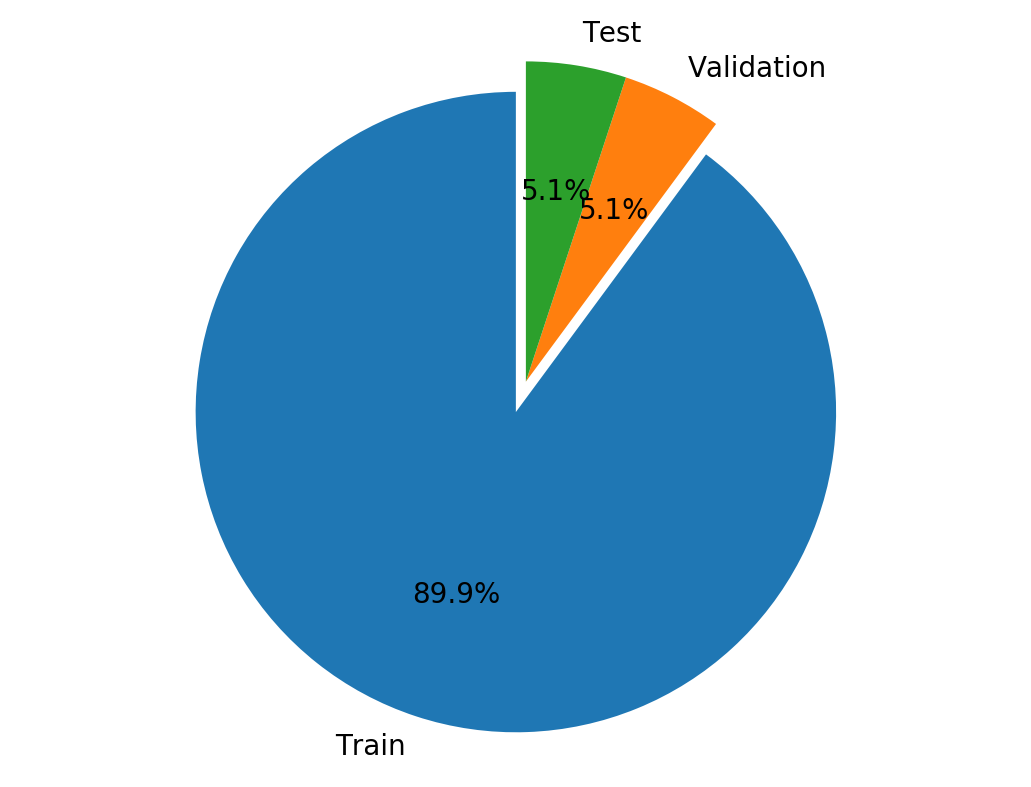

In [112]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(clsm_train.index), len(clsm_validation.index), len(clsm_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

In [113]:
#Show 90% Train Data Split
clsm_train.shape

(604, 20)

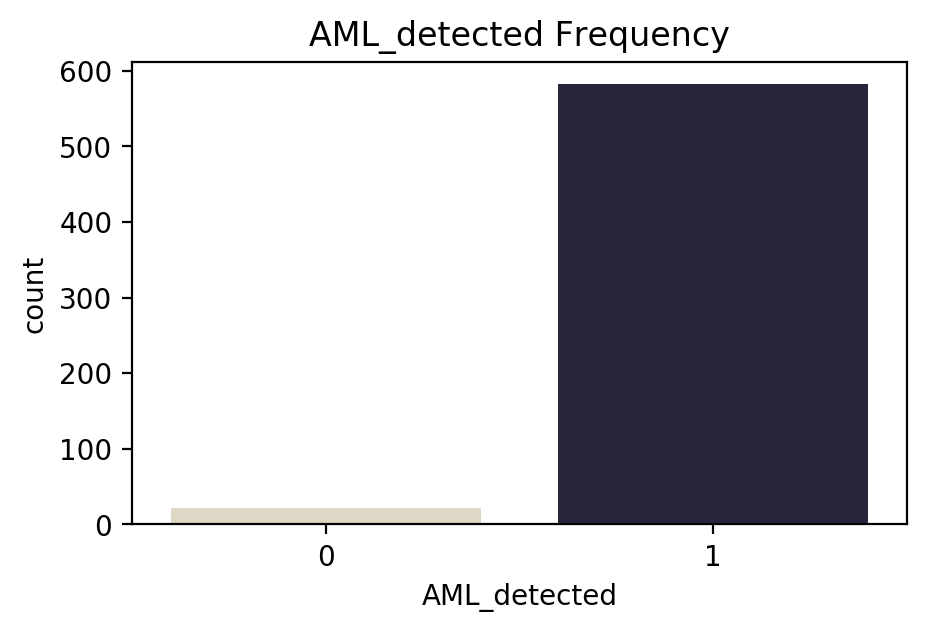

In [114]:
sns.countplot(x=clsm_train["AML_detected"], palette = "ch:s=-.2,r=.6")
plt.xlabel('AML_detected')
plt.title('AML_detected Frequency')
plt.gcf().set_size_inches(5, 3)

In [115]:
#Show 5% Validation Data Split
clsm_validation.shape

(34, 20)

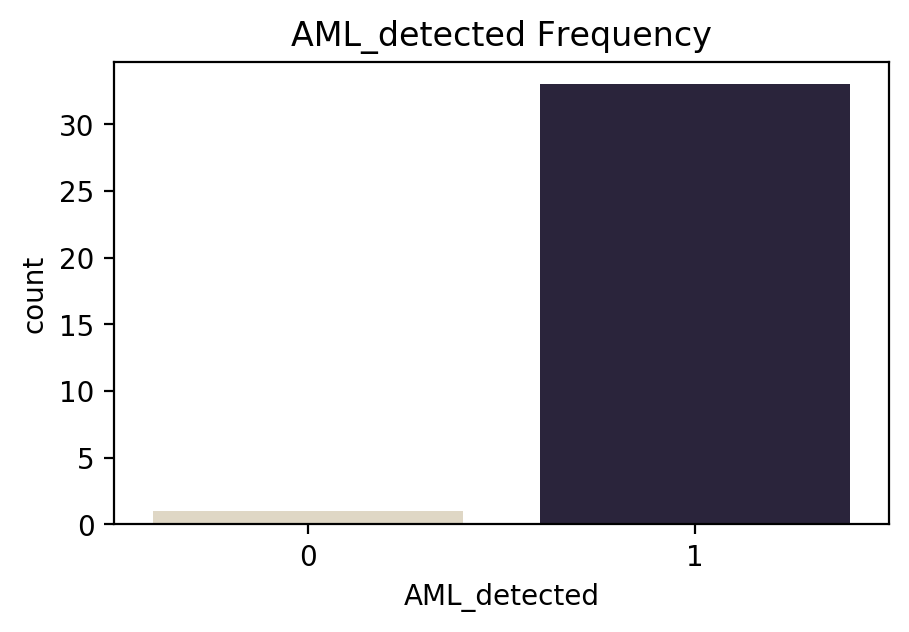

In [116]:
sns.countplot(x=clsm_validation["AML_detected"], palette = "ch:s=-.2,r=.6")
plt.xlabel('AML_detected')
plt.title('AML_detected Frequency')
plt.gcf().set_size_inches(5, 3)

In [117]:
clsm_validation.to_csv('clsm_validation.csv')

In [118]:
!aws s3 ls s3://ads508rawdatasets/CSV/

                           PRE OHSU_BeatAML_ClinicalSummary/
                           PRE OpenCell_ProteinInteraction/
2023-03-27 03:13:15          0 


In [119]:
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/clsm?prefix=tabular_regressonehot/&region=us-east-1">S3 Output Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

In [120]:
#Show 5% Test Data Split
clsm_test.shape

(34, 20)

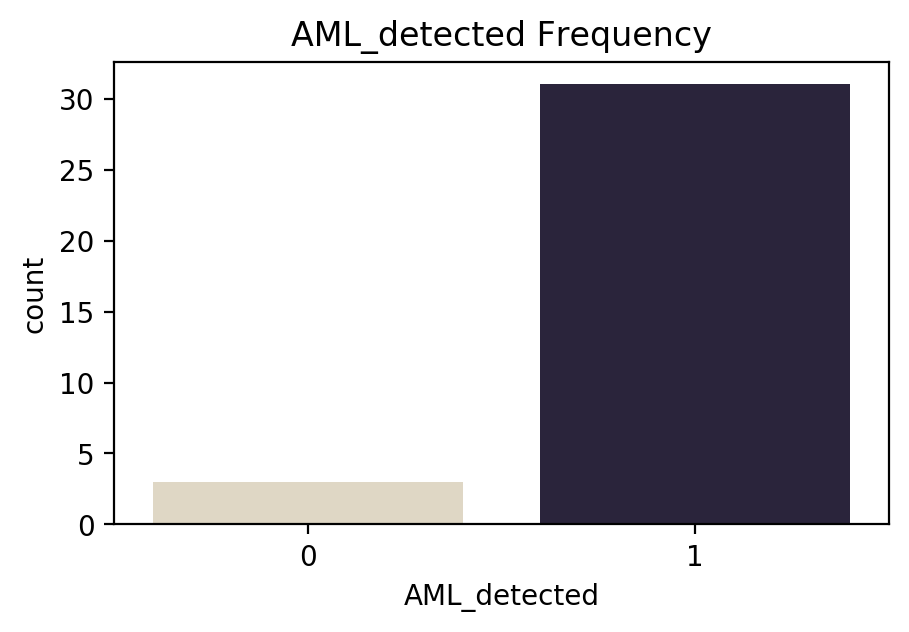

In [121]:
sns.countplot(x=clsm_test["AML_detected"], palette = "ch:s=-.2,r=.6")
plt.xlabel('AML_detected')
plt.title('AML_detected Frequency')
plt.gcf().set_size_inches(5, 3)

In [122]:
clsm_test.to_csv('clsm_test.csv')

In [123]:
#Manually upload into S3
!aws s3 ls s3://ads508rawdatasets/CSV/

                           PRE OHSU_BeatAML_ClinicalSummary/
                           PRE OpenCell_ProteinInteraction/
2023-03-27 03:13:15          0 


In [124]:
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/clsm?prefix=tabular_regressonehot/&region=us-east-1">S3 Output Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

In [125]:
clsm_train['AML_detected'].value_counts()

1    582
0     22
Name: AML_detected, dtype: int64

In [126]:
#resampling of training data set
to_resample= clsm_train.loc[clsm_train['AML_detected'] == 0] #isolate all records of AML_detected
our_resample=to_resample.sample(n=560, replace=True) #sample w/ replacement
clsm_t_rebal=pd.concat([clsm_train, our_resample]) #combine original training set w/ resampled records
clsm_t_rebal['AML_detected'].value_counts()

1    582
0    582
Name: AML_detected, dtype: int64

In [127]:
clsm_t_rebal.shape

(1164, 20)

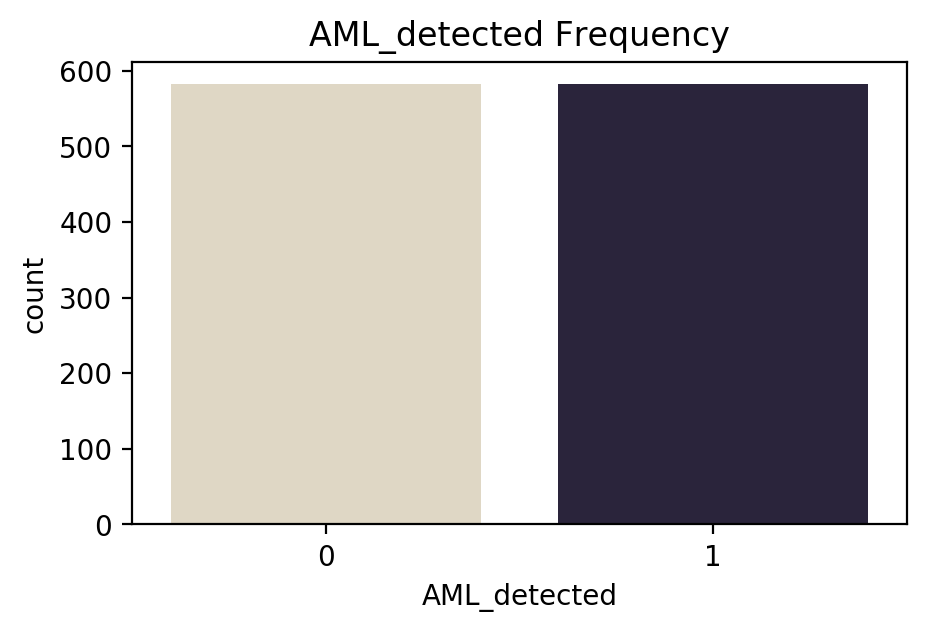

In [128]:
sns.countplot(x=clsm_t_rebal["AML_detected"], palette = "ch:s=-.2,r=.6")
plt.xlabel('AML_detected')
plt.title('AML_detected Frequency')
plt.gcf().set_size_inches(5, 3)

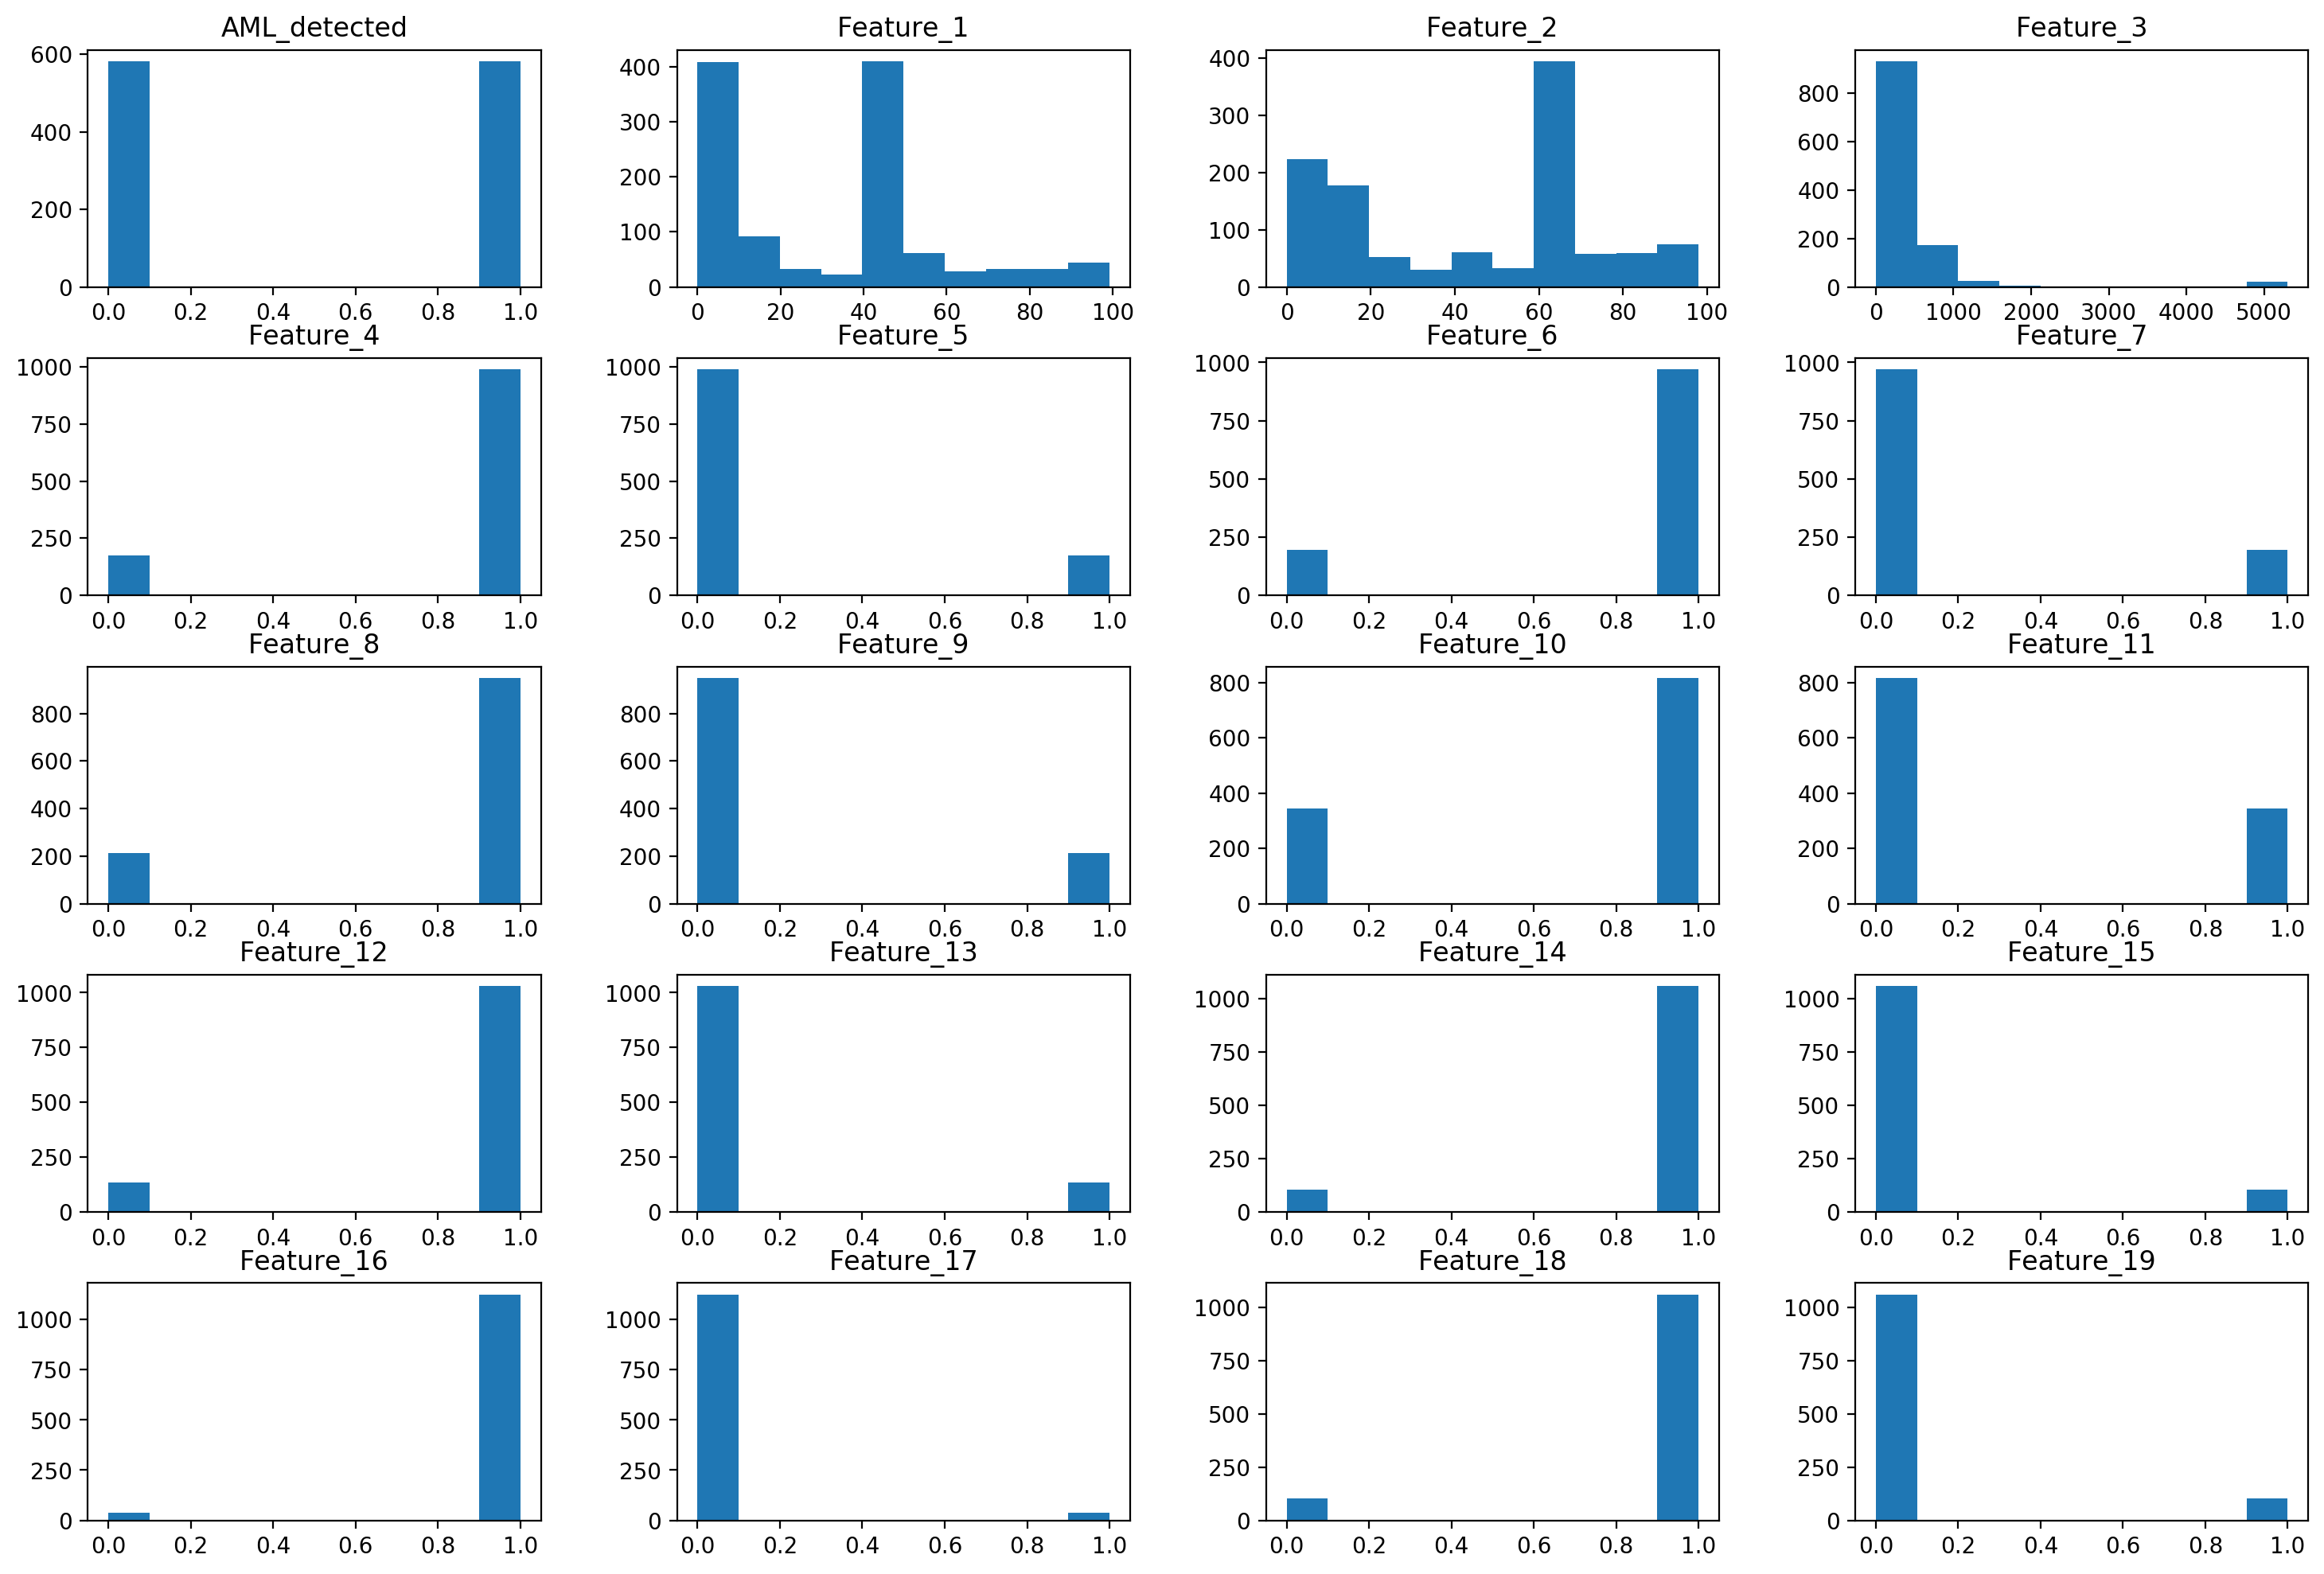

In [129]:
clsm_t_rebal.hist(grid=False, figsize=(18,12))
plt.show()

In [130]:
clsm_t_rebal.head()

AML_detected  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
60              1       29.0       55.0     1001.0          1          0   
133             1       41.5       63.0      323.0          0          1   
30              1       33.0       34.0      309.0          1          0   
69              1       64.0       62.0     1011.0          1          0   
292             1       30.0       63.0      450.0          1          0   

     Feature_6  Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  \
60           1          0          1          0           1           0   
133          1          0          1          0           1           0   
30           0          1          1          0           1           0   
69           1          0          1          0           1           0   
292          0          1          1          0           1           0   

     Feature_12  Feature_13  Feature_14  Feature_15  Feature_16  Feature_17  \
60            1           0           1           0           1           0   
133           1           0           1           0           1           0   
30            1           0           1           0           1           0   
69            1           0           1           0           1           0   
292           1           0           1           0           1           0   

     Feature_18  Feature_19  
60            1           0  
133           1           0  
30            1           0  
69            1           0  
292           1           0

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix, roc_curve
import statistics as stats

In [132]:
#Define/List the features
X_var = list(clsm_t.columns)
X_var

['AML_detected',
 'Feature_1',
 'Feature_2',
 'Feature_3',
 'Feature_4',
 'Feature_5',
 'Feature_6',
 'Feature_7',
 'Feature_8',
 'Feature_9',
 'Feature_10',
 'Feature_11',
 'Feature_12',
 'Feature_13',
 'Feature_14',
 'Feature_15',
 'Feature_16',
 'Feature_17',
 'Feature_18',
 'Feature_19']

In [133]:
#Define the target
target ='AML_detected'
X_var.remove(target)

x_train = clsm_t_rebal[X_var]
y_train = clsm_t_rebal[target]
x_test = clsm_test[X_var]
y_test = clsm_test[target]
x_valid = clsm_validation[X_var]
y_valid = clsm_validation[target]

In [134]:
x_train.shape

(1164, 19)

In [135]:
x_valid.shape

(34, 19)

In [136]:
x_test.shape

(34, 19)

In [139]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [140]:
x_train_scaled

array([[-0.07328539,  0.38458471,  0.7296354 , ..., -0.18618987,
         0.31157379, -0.31157379],
       [ 0.40512383,  0.65709823, -0.15454083, ..., -0.18618987,
         0.31157379, -0.31157379],
       [ 0.07980556, -0.33076329, -0.17279815, ..., -0.18618987,
         0.31157379, -0.31157379],
       ...,
       [ 0.40512383,  0.65709823, -0.57576343, ..., -0.18618987,
         0.31157379, -0.31157379],
       [ 0.49315113, -0.05824977, -0.07368695, ..., -0.18618987,
         0.31157379, -0.31157379],
       [-1.18319478, -1.31862481, -0.57576343, ..., -0.18618987,
         0.31157379, -0.31157379]])

In [141]:
x_test_scaled

array([[-0.0479659 ,  0.32405462,  0.72126902, -1.66666667,  1.66666667,
         0.64549722, -0.64549722,  0.50917508, -0.50917508,  0.4152274 ,
        -0.4152274 ,  0.17407766, -0.17407766,  0.31108551, -0.31108551,
         0.36514837, -0.36514837,  0.4152274 , -0.4152274 ],
       [-0.7457583 ,  1.26189238,  1.74407548, -1.66666667,  1.66666667,
         0.64549722, -0.64549722,  0.50917508, -0.50917508,  0.4152274 ,
        -0.4152274 ,  0.17407766, -0.17407766,  0.31108551, -0.31108551,
         0.36514837, -0.36514837,  0.4152274 , -0.4152274 ],
       [-1.26411836, -1.55162091, -0.21983397,  0.6       , -0.6       ,
         0.64549722, -0.64549722, -1.96396101,  1.96396101, -2.40831892,
         2.40831892,  0.17407766, -0.17407766,  0.31108551, -0.31108551,
         0.36514837, -0.36514837,  0.4152274 , -0.4152274 ],
       [ 2.08528515,  1.43556604, -1.1911975 ,  0.6       , -0.6       ,
        -1.54919334,  1.54919334,  0.50917508, -0.50917508,  0.4152274 ,
        -0.415

Untuned Logistic Regression Model
Accuracy Score
0.9705882352941176
Cross Validation: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.97      1.00      0.99        33

    accuracy                           0.97        34
   macro avg       0.49      0.50      0.49        34
weighted avg       0.94      0.97      0.96        34



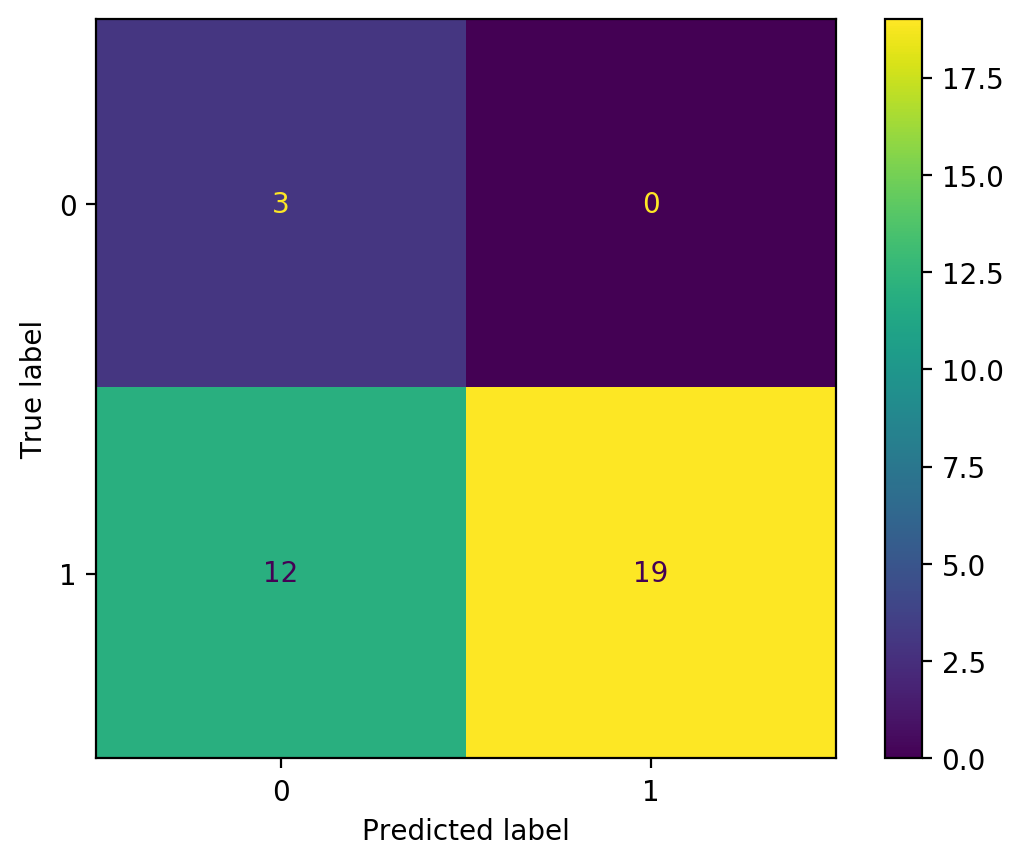

In [142]:
#Untuned Logistic Regression Model
logit_reg = LogisticRegression(random_state=27)
logit_reg.fit(x_train_scaled, y_train)
y_pred = logit_reg.predict(x_test)
                               
#Predict on validation set
logit_reg_pred1 = logit_reg.predict(x_valid)

plot_confusion_matrix(logit_reg, x_test_scaled, y_test)
plt.grid(False)

#accuracy and classification report on untuned model
print('Untuned Logistic Regression Model')
print('Accuracy Score')
print(accuracy_score(y_valid, logit_reg_pred1))
print('Cross Validation: \n', 
      classification_report(y_valid, logit_reg_pred1))

In [143]:
#Tune logistic regression model using RandomizedSearchCV() and cross validate with repeated stratified kfold with five splits and two repeats
#Generate overall best accuracy score with optimal hyperparameters
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform
model1 = LogisticRegression(random_state=27)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=27)

space = dict()

# define search space
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)

# define search
search = RandomizedSearchCV(model1, space, 
                            scoring='accuracy', 
n_jobs=-1, cv=cv, random_state=777)

# execute search
result = search.fit(x_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9093976616841795
Best Hyperparameters: {'C': 0.005198849908368508, 'penalty': 'none', 'solver': 'lbfgs'}


## Release Resources

In [96]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [132]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>